In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [ ]:
# Import dataset
data = pd.read_csv('train.csv')

In [ ]:
!pip install kmodes
!pip install pyod

     |████████████████████████████████| 116 kB 4.2 MB/s 
  Created wheel for pyod: filename=pyod-0.9.9-py3-none-any.whl size=139325 sha256=1c62081ce3e5e4ec55dc0f6727569e0d83ed2cf3412b6a0111f603d078d73e4b
  Stored in directory: /root/.cache/pip/wheels/68/32/f0/0dc3050775e77b6661a116b70817b02b4305fa253269d6d998
Successfully built pyod


Missing Values Treatment

As Genetic Disorder column is directly related to the Disorder Subclass, the rows with missing values in Genetic Disorder was directly filled with values based on the Disorder Subclass according to the table below.

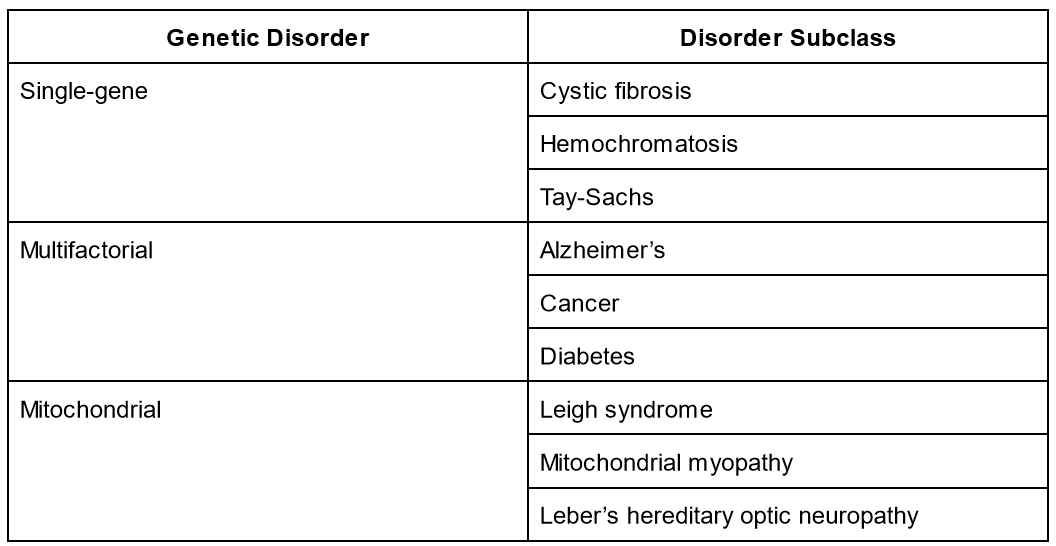


To fill in missing values in other predictors, both simply filling in with the mode of the predictor column using SimpleImputer (another notebook) and iterative imputation of missing values using IterativeImputer were tested. IterativeImputer uses the multivariate imputation by chained equations approach whereby each predictor is modelled as a function of other predictors and the missing values were predicted imputed. Naïve Bayes model was used in iterative imputation as label encoding was done initially just for imputation purpose and Naïve Bayes can ignore ordinality of data. The process repeats until the maximum number of iterations decided is reached or convergence occurs whereby there are hardly any more changes in values as compared to the previous iteration. IterativeImputer and SimpleImputer yielded similarity in this dataset and hence either one can be used in this dataset.

In [ ]:
# Drop useless columns
drop_columns = ["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name", "Location of Institute", "Parental consent", "Place of birth"]
data_drop = data.drop(drop_columns,axis = 1)

data_drop = data_drop.dropna(subset = ['Disorder Subclass'], axis = 'rows').reset_index()

# Fill missing values in Genetic Disorder based on Disorder Subclass
for i in range(len(data_drop)):
    if data_drop.loc[i, "Disorder Subclass"] in ["Cystic fibrosis", "Hemochromatosis", "Tay-Sachs"]:
        data_drop.loc[i, "Genetic Disorder"] = "Single-gene inheritance diseases"
    elif data_drop.loc[i, "Disorder Subclass"] in ["Alzheimer's", "Cancer", "Diabetes"]:
        data_drop.loc[i, "Genetic Disorder"] = "Multifactorial genetic inheritance disorders"
    else:
        data_drop.loc[i, "Genetic Disorder"] = "Mitochondrial genetic inheritance disorders"
data_drop.drop('index', axis = 1, inplace = True)        

# Bin the continous variables to convert into ordinal categorical variables
pa_edges = np.histogram_bin_edges(data_drop['Patient Age'].dropna(), bins = 5)
data_drop['Patient Age'] = pd.cut(data_drop['Patient Age'], bins = pa_edges, labels = [x for x in range(len(pa_edges) - 1)])

ma_edges = np.histogram_bin_edges(data_drop['Mother\'s age'].dropna(), bins = 6)
data_drop['Mother\'s age'] = pd.cut(data_drop['Mother\'s age'], bins = ma_edges, labels = [x for x in range(len(ma_edges) - 1)])

fa_edges = np.histogram_bin_edges(data_drop['Father\'s age'].dropna(), bins = 6)
data_drop['Father\'s age'] = pd.cut(data_drop['Father\'s age'], bins = fa_edges, labels = [x for x in range(len(fa_edges) - 1)])

bcc_edges = np.histogram_bin_edges(data_drop['Blood cell count (mcL)'].dropna(), bins = 4)
data_drop['Blood cell count (mcL)'] = pd.cut(data_drop['Blood cell count (mcL)'], bins = bcc_edges, labels = [x for x in range(len(bcc_edges) - 1)])

wbcc_edges = np.histogram_bin_edges(data_drop['White Blood cell count (thousand per microliter)'].dropna(), bins = 4)
data_drop['White Blood cell count (thousand per microliter)'] = pd.cut(data_drop['White Blood cell count (thousand per microliter)'], bins = wbcc_edges, labels = [x for x in range(len(wbcc_edges) - 1)])

In [ ]:
# Import libraries
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split

# Label encode all variables
encoder = defaultdict(LabelEncoder)
encoded_data = data_drop.apply(lambda series: pd.Series(encoder[series.name].fit_transform(series[series.notnull()]), index = series[series.notnull()].index))
encoded_data.head()

# Separate into predictors and response variables
X = encoded_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis = 1)
y = encoded_data[['Genetic Disorder', 'Disorder Subclass']]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

# Iterative imputation based on Multivariate Imputation by Chained Equations (MICE) using Naive Bayes model
# Use Naive Bayes as it disregards ordinality so that it is easier to impute all in one go
imputer_nb = IterativeImputer(estimator = CategoricalNB(), initial_strategy='constant', max_iter = 200)

X_train_imp_nb = pd.DataFrame()
X_test_imp_nb = pd.DataFrame()

X_train_imp_nb[X_train.columns] = imputer_nb.fit_transform(X_train)
X_test_imp_nb[X_test.columns] = imputer_nb.transform(X_test)

# Decode back to original values from label encoder
imputed_unenc_X_train = pd.DataFrame()
for x in X_train_imp_nb:
  imputed_unenc_X_train[x] = list(encoder[x].inverse_transform(X_train_imp_nb[x].apply(lambda y: int(y))))

imputed_unenc_X_test = pd.DataFrame()
for x in X_test_imp_nb:
  imputed_unenc_X_test[x] = list(encoder[x].inverse_transform(X_test_imp_nb[x].apply(lambda y: int(y))))

unenc_y_train = pd.DataFrame()
for x in y_train:
  unenc_y_train[x] = list(encoder[x].inverse_transform(y_train[x].apply(lambda y: int(y))))

unenc_y_test = pd.DataFrame()
for x in y_test:
  unenc_y_test[x] = list(encoder[x].inverse_transform(y_test[x].apply(lambda y: int(y))))

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [ ]:
### Supervised
## One-hot encoding

# Reform whole imputed dataset
data_drop_imputed = pd.concat([pd.concat([imputed_unenc_X_train, unenc_y_train],axis = 1),pd.concat([imputed_unenc_X_test, unenc_y_test],axis = 1)],axis =0)

ordinal_converter = {'Birth defects':['Singular','Multiple']}
for k, v in ordinal_converter.items():
  data_drop_imputed[k] = [v.index(x) for x in data_drop_imputed[k]]

# Classify nominal and ordinal data
ordinal = []
nominal = []
for i in data_drop_imputed:
  if isinstance(list(data_drop_imputed[i].unique())[0], np.int64) or isinstance(list(data_drop_imputed[i].unique())[0], np.float64):
    ordinal.append(i)
  else:
    nominal.append(i)

# One Hot encoding to all to account for nominal data
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
encoder = defaultdict(OneHotEncoder)
data_drop_encoded = data_drop_imputed.copy()
nominal.remove('Disorder Subclass')
nominal.remove('Genetic Disorder')
data_drop_encoded.drop(labels = nominal, axis = 1, inplace = True)
for i in nominal:
  data_drop_encoded = pd.concat([data_drop_encoded, pd.DataFrame(encoder[i].fit_transform(data_drop_imputed[[i]]).toarray(), index = data_drop_imputed[[i]].index, columns = encoder[i].get_feature_names_out ())], axis = 1)

X = data_drop_encoded.drop(['Disorder Subclass', 'Genetic Disorder'], axis = 1)
y = data_drop_encoded[['Disorder Subclass', 'Genetic Disorder']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

# Stratify by Disorder Subclass

Imbalance dataset

Performance of models created were evaluated using original imbalance data. The results serve as a control to compare with other imbalance treatment methods. The imbalance dataset was hypothesised to produce the worse performing models.


Naive Bayes

Naive Bayes is a probabilistic model which can be used in Multiclass Classification, suitable for prediction of Genetic Disorder and Disorder Subclass. 
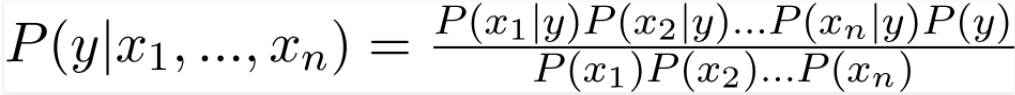

The Bayes Theorem allows the finding of probability of a Genetic Disorder class (hypothesis) happening given a certain set of predictor values (evidence). The assumption of Bayes Theorem is that the predictors are independent and that all predictors have equal effect on the outcome. Due to the denominator being a constant, it can be removed in the above equation to give the equation below.

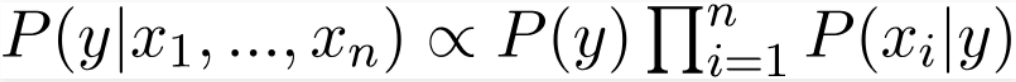
The class of Genetic Disorder can then be assigned by finding the class with the highest probability with the given predictors.

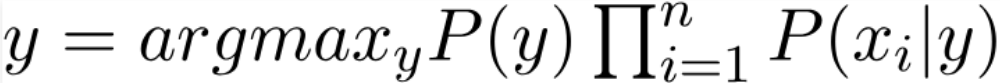
In general, Naive Bayes did not work as well as other supervised learning models in this project and thus was not chosen to be used in the final model.


In [ ]:
# Naive Bayes Genetic Disorder

# Import libraries
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB
# Iterate the model for 30 times to get average performance
all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract out Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.539457        0.529936          0.526488         0.496745
std           0.001809        0.005440          0.001840         0.007286
min           0.535400        0.517951          0.521968         0.487069
25%           0.538303        0.526362          0.525357         0.490215
50%           0.539951        0.529500          0.526551         0.495485
75%           0.540626        0.533392          0.527978         0.501252
max           0.542932        0.540798          0.529751         0.511936

Support Vector Machine

The Support Vector Machine breaks the multiclass problem into multiple binary classification problems through the one-to-one approach. The model finds a hyperplane that best separates between every two classes, and is optimised by maximising the margin. However, the large genetic disorder dataset with about 20000 rows meant that training time using SVM was high so it was not used as the final model. 
SVM Training time complexity = O(n3)
Random forest Training time complexity = O(n*log(n)*d*k)
Where n = number of training sample, k = number of decision trees, d = dimensionality of the data.

SVM was not carried out for SMOTE and Oversampling treatment on dataset with train test split stratified against Disorder Subclass due to immense runtime required.


In [ ]:
# Support Vector Machine
from sklearn import svm

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo') # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)
count        30.000000       30.000000
mean          0.543631        0.526755
std           0.003017        0.002092
min           0.538664        0.523726
25%           0.541395        0.525295
50%           0.543592        0.526111
75%           0.545914        0.528182
max           0.548581        0.532011

Random Forest

Random Forest utilises the ensemble technique and is suitable for a Multiclass problem. By creating a bunch of decision trees that use different variables and data points for training, collaborative learning can be achieved and the class assigned ultimately will be via a “vote” whereby the class will be the one that is predicted by most decision trees. Random Forest was found to be the best performing model out of all supervised learning models and was used for the final models.


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder 
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3, n_jobs = -1) # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean())   # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01      3.000000e+01        30.000000
mean      5.128044e-01    5.129300e-01      5.128044e-01         0.512947
std       2.258405e-16    2.258405e-16      2.258405e-16         0.000064
min       5.128044e-01    5.129300e-01      5.128044e-01         0.512930
25%       5.128044e-01    5.129300e-01      5.128044e-01         0.512930
50%       5.128044e-01    5.129300e-01      5.128044e-01         0.512930
75%       5.128044e-01    5.129300e-01      5.128044e-01         0.512930
max       5.128044e-01    5.129300e-01      5.128044e-01         0.513181

In [ ]:
# Change depth of Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  for i in range(30):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01      3.000000e+01     3.000000e+01
mean      5.128044e-01    5.129300e-01      5.128044e-01     5.129299e-01
std       2.258405e-16    2.258405e-16      2.258405e-16     2.712326e-07
min       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
25%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
50%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
75%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
max       5.128044e-01    5.129300e-01      5.128044e-01     5.129304e-01

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01      3.000000e+01     3.000000e+01
mean      5.128044e-01    5.129300e-01      5.128044e-01     5.129299e-01
std       2.258405e-16    2.258405e-16      2.258405e-16     2.565135e-07
min       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
25%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
50%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
75%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
max       5.128044e-01    5.129300e-01      5.128044e-01     5.129304e-01

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000      3.000000e+01        30.000000
mean          0.512815        0.512947      5.128044e-01         0.512947
std           0.000057        0.000092      2.258405e-16         0.000064
min           0.512804        0.512930      5.128044e-01         0.512930
25%           0.512804        0.512930      5.128044e-01         0.512930
50%           0.512804        0.512930      5.128044e-01         0.512930
75%           0.512804        0.512930      5.128044e-01         0.512930
max           0.513118        0.513432      5.128044e-01         0.513182

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.515849        0.515097          0.515673         0.514528
std           0.001377        0.001171          0.000632         0.001374
min           0.513871        0.513181          0.514185         0.512929
25%           0.514954        0.513997          0.515394         0.513495
50%           0.515409        0.515190          0.515692         0.514186
75%           0.516225        0.516131          0.515943         0.515189
max           0.519081        0.517198          0.517386         0.519458

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.523697        0.522671          0.521320         0.519140
std           0.002127        0.002774          0.001073         0.002731
min           0.519144        0.518704          0.519081         0.512931
25%           0.522408        0.520525          0.520666         0.517449
50%           0.523632        0.522345          0.521058         0.519081
75%           0.524432        0.524102          0.522063         0.520711
max           0.527868        0.529751          0.524040         0.526739

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.535714        0.528245          0.528322         0.522713
std           0.002050        0.002633          0.001486         0.002779
min           0.531634        0.523475          0.525420         0.516444
25%           0.534145        0.526299          0.527429         0.521278
50%           0.535589        0.528371          0.528308         0.522722
75%           0.537142        0.529500          0.529077         0.524353
max           0.540673        0.534773          0.531446         0.528244

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.558066        0.536421          0.534744         0.527768
std           0.002884        0.003241          0.001864         0.004559
min           0.553226        0.528998          0.530882         0.520214
25%           0.555564        0.535024          0.533470         0.524607
50%           0.558530        0.536405          0.534679         0.527115
75%           0.560350        0.538476          0.535965         0.531131
max           0.562202        0.543811          0.538665         0.536280

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.600766        0.543769          0.541267         0.529726
std           0.003710        0.004104          0.002176         0.005331
min           0.591765        0.537535          0.537346         0.518454
25%           0.598638        0.541363          0.539825         0.526737
50%           0.600584        0.542681          0.541489         0.529503
75%           0.603393        0.546447          0.542838         0.532389
max           0.608398        0.551845          0.544941         0.542052

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.674310        0.550364          0.547464         0.529166
std           0.002856        0.004590          0.001892         0.006651
min           0.667964        0.543560          0.543560         0.515437
25%           0.672938        0.546385          0.546494         0.524793
50%           0.674335        0.549962          0.546981         0.528999
75%           0.675872        0.553854          0.549084         0.533135
max           0.679262        0.560633          0.551720         0.542306

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.785716        0.554164          0.551751         0.527401
std           0.003105        0.004535          0.002445         0.006858
min           0.778810        0.545569          0.545004         0.512683
25%           0.783988        0.551720          0.550841         0.521719
50%           0.785275        0.554356          0.551594         0.528744
75%           0.788790        0.557871          0.553273         0.531696
max           0.790673        0.561135          0.555800         0.540048

In [ ]:
# Change number of trees of Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  for i in range(30):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 7, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.557268        0.536103          0.534568         0.528654
std           0.002099        0.003183          0.002136         0.004869
min           0.552724        0.529249          0.529500         0.520717
25%           0.555941        0.534333          0.532937         0.524603
50%           0.556992        0.535652          0.534804         0.528746
75%           0.558703        0.538539          0.536217         0.532013
max           0.561951        0.541803          0.537535         0.540803

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.557312        0.536045          0.534451         0.527558
std           0.002176        0.002371          0.001602         0.005409
min           0.552975        0.531509          0.531509         0.518956
25%           0.556255        0.534082          0.533062         0.522972
50%           0.557055        0.536279          0.534584         0.526866
75%           0.558295        0.537974          0.535793         0.531194
max           0.563081        0.540547          0.537660         0.540795

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.556417        0.536288          0.534530         0.527717
std           0.002084        0.003579          0.001251         0.004532
min           0.552661        0.529500          0.532638         0.515941
25%           0.554811        0.534522          0.533596         0.525546
50%           0.556365        0.536405          0.534459         0.527489
75%           0.558169        0.538225          0.535259         0.530630
max           0.560193        0.546573          0.537032         0.539293

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.557049        0.535811          0.534871         0.527484
std           0.002629        0.002028          0.001389         0.003703
min           0.551594        0.531258          0.532576         0.518955
25%           0.555109        0.534082          0.533518         0.525484
50%           0.556929        0.536028          0.534584         0.528119
75%           0.559016        0.536970          0.536013         0.529940
max           0.563018        0.539292          0.537409         0.535024

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.557045        0.536723          0.534451         0.526580
std           0.002744        0.003078          0.001719         0.003699
min           0.552222        0.527241          0.531634         0.519458
25%           0.555188        0.535087          0.533141         0.524544
50%           0.557745        0.536656          0.534365         0.526612
75%           0.558891        0.538978          0.535652         0.528874
max           0.563206        0.542054          0.538288         0.534274

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.556664        0.536129          0.534292         0.527149
std           0.001763        0.002772          0.001552         0.004491
min           0.553226        0.530505          0.530316         0.517696
25%           0.555502        0.535087          0.533533         0.524101
50%           0.556333        0.536279          0.534176         0.527116
75%           0.557589        0.537911          0.535511         0.530380
max           0.560507        0.541301          0.536969         0.536028

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.556381        0.535995          0.534405         0.527843
std           0.002299        0.002718          0.001704         0.003386
min           0.552347        0.529751          0.531069         0.520463
25%           0.554403        0.534020          0.533298         0.525861
50%           0.556647        0.535777          0.534710         0.527993
75%           0.558357        0.538225          0.535589         0.530253
max           0.560633        0.540798          0.536970         0.533266

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.556570        0.535652          0.534145         0.528211
std           0.001766        0.002832          0.001304         0.004171
min           0.553226        0.529751          0.531321         0.519207
25%           0.555203        0.534522          0.533266         0.525923
50%           0.556553        0.535652          0.533832         0.527743
75%           0.557698        0.536970          0.535008         0.530756
max           0.560947        0.543309          0.536719         0.534271

AdaBoost

Boosting algorithm aims to improve the prediction power by converting a number of weak learners to strong learners. For AdaBoost, decision trees with 1 levels were used as the weak models known as decision stumps. 

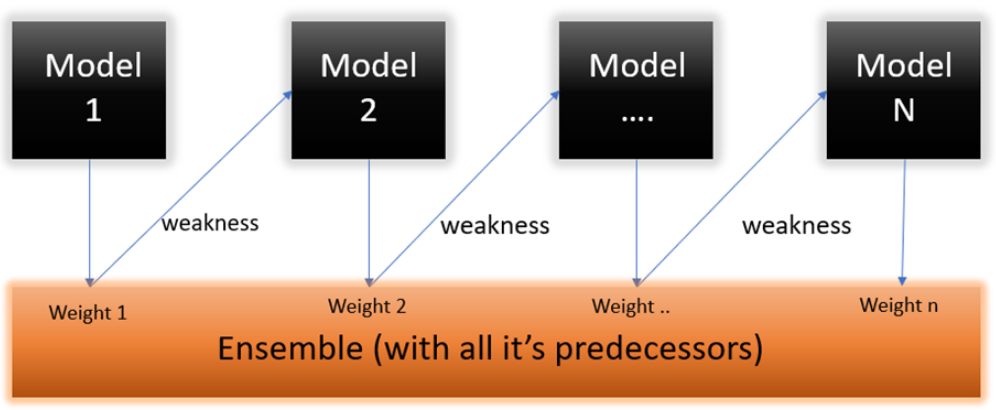

A model is first built and equal weights were given to all the data points. Higher weights were then assigned to points that were wrongly classified. Points with higher weight were then given more importance in the subsequent model as they will be oversampled within the new dataset picked. The process will continue until the error is minimised. AdaBoost as a model to predict Genetic Disorder classes was found to perform better than Naive Bayes in general but underperformed in comparison to Random Forest and Support Vector Machine. 


In [ ]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 1) # Choose Decision Tree as weak model
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main, cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.520123        0.517098          0.515738         0.495783
std           0.001247        0.002762          0.001678         0.004351
min           0.517198        0.511424          0.512805         0.483549
25%           0.519395        0.515001          0.514452         0.493158
50%           0.520148        0.516821          0.516068         0.495860
75%           0.520933        0.518893          0.517026         0.499373
max           0.522973        0.523224          0.518454         0.502889

Anomaly Detection - KNN

Using the K-Nearest Neighbour model, the anomalies of the dataset were extracted out after one-hot encoding. The model hyperparameter was set such that a data point distance to its kth nearest neighbour is viewed as the outlying score and it can be interpreted as a measure of density. The contamination was set to change from 0.01 to 0.1. Interestingly, Multifactorial genetic inheritance disorders were a lot less likely to be flagged as outliers.

Contamination = 0.01
Mitochondrial genetic inheritance disorders     94
Multifactorial genetic inheritance disorders    12
Single-gene inheritance diseases                58
Name: Genetic Disorder, dtype: int64

Contamination = 0.02
Mitochondrial genetic inheritance disorders     94
Multifactorial genetic inheritance disorders    12
Single-gene inheritance diseases                58
Name: Genetic Disorder, dtype: int64

Contamination = 0.03
Mitochondrial genetic inheritance disorders     94
Multifactorial genetic inheritance disorders    12
Single-gene inheritance diseases                58
Name: Genetic Disorder, dtype: int64

Contamination = 0.04
Mitochondrial genetic inheritance disorders     94
Multifactorial genetic inheritance disorders    12
Single-gene inheritance diseases                58
Name: Genetic Disorder, dtype: int64

Contamination = 0.05
Mitochondrial genetic inheritance disorders     432
Multifactorial genetic inheritance disorders     84
Single-gene inheritance dis

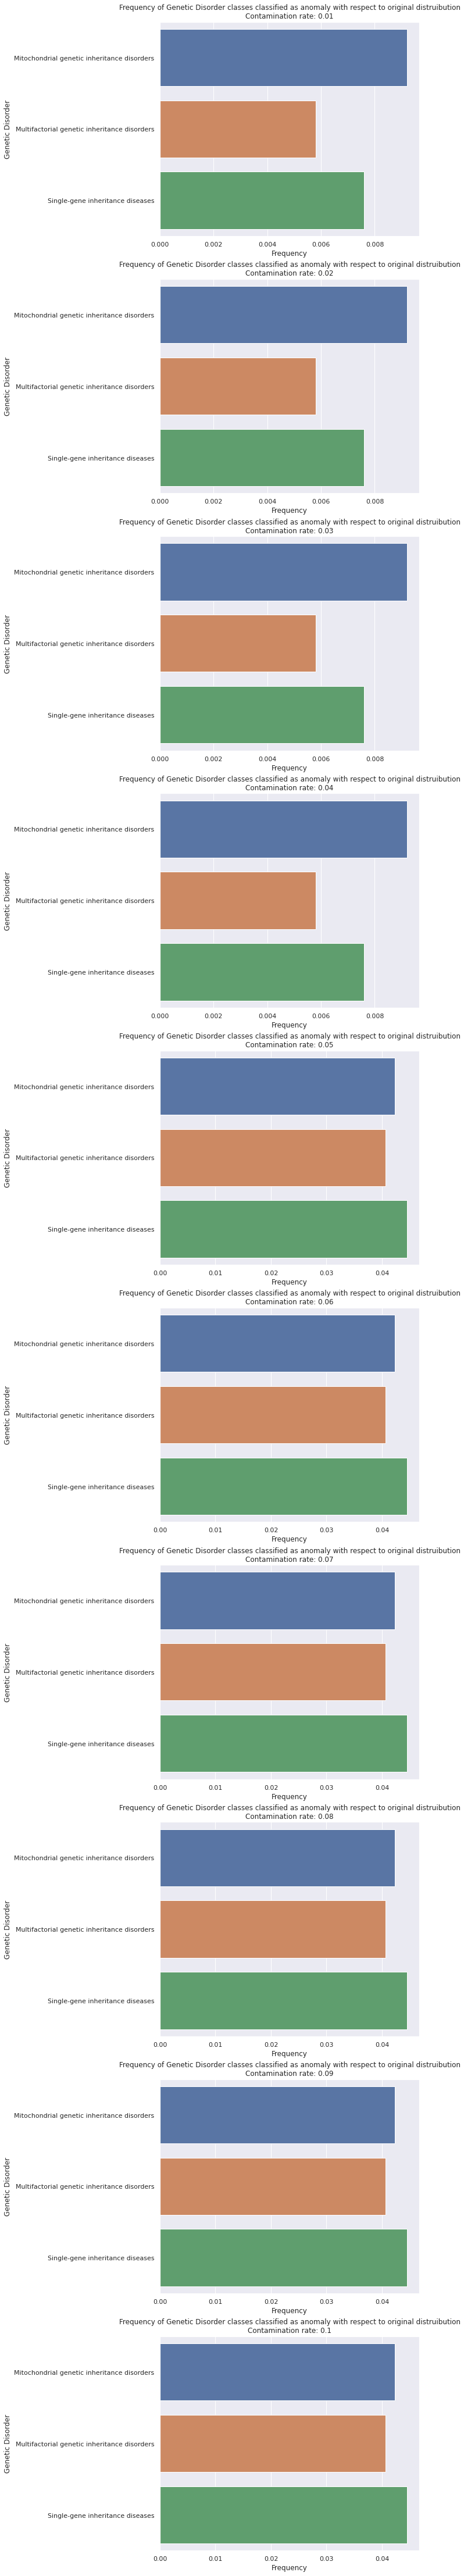

In [ ]:
# KNN anomaly detection

from pyod.models.knn import KNN
count = 0
fig, ax = plt.subplots(10,1, figsize = (8,80))
for i in np.linspace(0.01,0.1,10):
  KNN_model = KNN(contamination = round(i,2))
  KNN_model.fit(X)  # Fit model
  outlier_labels = KNN_model.labels_
  outliers = pd.concat([X, y],axis = 1).iloc[outlier_labels == 1]
  print('Contamination =', round(i,2))
  print(outliers['Genetic Disorder'].value_counts().sort_index(),end = '\n\n')
  g = sb.barplot(y =  outliers['Genetic Disorder'].value_counts().sort_index().index, x = [outliers['Genetic Disorder'].value_counts().sort_index().to_list()[num] / y['Genetic Disorder'].value_counts().sort_index().to_list()[num] for num in range(3)], ax = ax[count])
  ax[count].set_title('Frequency of Genetic Disorder classes classified as anomaly with respect to original distruibution\nContamination rate: ' + str(round(i,2)))
  ax[count].set_xlabel('Frequency')
  ax[count].set_ylabel('Genetic Disorder')
  count += 1

Undersampling

The majority classes, from Genetic Disorder or Genetic Subclass, were undersampled randomly without replacement. The sampling strategy was set to use “not minority” which resamples all classes except the minority class. One benefit of using this imbalance treatment would be the shorter computational time for model training as dataset size was reduced. However, it may risk removing important data points that should have been used for model training. 


In [ ]:
## Undersampling
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Naive Bayes
# Undersampling based on Disorder Subclass

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values 
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main['Genetic Disorder'])  # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, X_train, y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.492407        0.405524          0.398985         0.368762
std           0.015717        0.028767          0.021047         0.046851
min           0.469914        0.348571          0.343782         0.302857
25%           0.479585        0.385714          0.389951         0.332857
50%           0.492120        0.411429          0.395432         0.360000
75%           0.502865        0.417143          0.413690         0.397143
max           0.530086        0.474286          0.436989         0.457143

In [ ]:
#Support Vector Machine
# Undersampling based on Disorder Subclass

from sklearn import svm

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_svm = svm.SVC(decision_function_shape='ovo')# Instantiate model
    main_class_svm.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())   # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.648711        0.395048          0.407015         0.365524
std           0.016535        0.028855          0.016546         0.042431
min           0.608883        0.337143          0.356752         0.251429
25%           0.641834        0.377143          0.400370         0.350000
50%           0.648281        0.388571          0.406927         0.365714
75%           0.663324        0.410000          0.415108         0.398571
max           0.676218        0.462857          0.438438         0.428571

In [ ]:
# Random Forest
# Undersampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3) # Instantiate model
    randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.583047        0.459429          0.450148         0.389524
std           0.013479        0.027897          0.015918         0.043882
min           0.557307        0.417143          0.421202         0.297143
25%           0.575931        0.440000          0.439838         0.355714
50%           0.580229        0.454286          0.448433         0.382857
75%           0.591691        0.478571          0.460971         0.415714
max           0.610315        0.531429          0.482713         0.480000

In [ ]:
# Change depth of Random Forest
# Undersampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      undersample = RandomUnderSampler(sampling_strategy = 'not minority')
      x_under, y_under = undersample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.466762        0.418857          0.413030         0.382095
std           0.018298        0.033527          0.021082         0.038951
min           0.426934        0.360000          0.359599         0.314286
25%           0.453797        0.400000          0.402849         0.355714
50%           0.468481        0.405714          0.417595         0.377143
75%           0.479943        0.442857          0.428024         0.411429
max           0.510029        0.491429          0.452713         0.474286

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.522302        0.458286          0.443115         0.384952
std           0.013889        0.029191          0.023097         0.037948
min           0.494269        0.400000          0.386835         0.314286
25%           0.514327        0.435714          0.428343         0.360000
50%           0.520057        0.457143          0.444096         0.385714
75%           0.529370        0.478571          0.461601         0.411429
max           0.558739        0.508571          0.488561         0.451429

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.579370        0.459048          0.457255         0.396381
std           0.014948        0.030025          0.017664         0.036620
min           0.554441        0.405714          0.422621         0.314286
25%           0.568052        0.435714          0.447318         0.377143
50%           0.581662        0.460000          0.455581         0.388571
75%           0.590258        0.485714          0.473435         0.421429
max           0.607450        0.514286          0.488571         0.474286

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.680372        0.468190          0.458071         0.401333
std           0.014446        0.028746          0.019146         0.050638
min           0.651862        0.411429          0.424111         0.274286
25%           0.673352        0.447143          0.447017         0.365714
50%           0.679799        0.465714          0.458448         0.405714
75%           0.690544        0.485714          0.469504         0.432857
max           0.707736        0.525714          0.504358         0.502857

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.816189        0.474857          0.462511         0.412190
std           0.018185        0.038387          0.024079         0.040676
min           0.777937        0.394286          0.419723         0.308571
25%           0.802650        0.458571          0.441714         0.395714
50%           0.816619        0.480000          0.464224         0.417143
75%           0.825215        0.501429          0.481359         0.444286
max           0.861032        0.548571          0.498664         0.485714

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.924928        0.478095          0.471147         0.407238
std           0.009380        0.030985          0.017895         0.032496
min           0.895415        0.422857          0.436948         0.348571
25%           0.920129        0.457143          0.459186         0.382857
50%           0.925501        0.477143          0.473402         0.408571
75%           0.928367        0.501429          0.481339         0.427143
max           0.941261        0.548571          0.504286         0.474286

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.982856        0.481714          0.465911         0.385905
std           0.005068        0.030650          0.017007         0.045732
min           0.971347        0.428571          0.435560         0.297143
25%           0.979943        0.462857          0.455933         0.355714
50%           0.983524        0.477143          0.464892         0.391429
75%           0.986390        0.501429          0.477772         0.417143
max           0.991404        0.554286          0.504255         0.468571

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.997564        0.467619          0.456155         0.393714
std           0.001887        0.029256          0.023888         0.050251
min           0.992837        0.405714          0.412590         0.285714
25%           0.995702        0.447143          0.438828         0.365714
50%           0.997851        0.468571          0.453422         0.385714
75%           0.998567        0.490000          0.474263         0.422857
max           1.000000        0.525714          0.508602         0.474286

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.999809        0.479048          0.465592         0.386286
std           0.000622        0.047717          0.020830         0.036715
min           0.997135        0.388571          0.426999         0.314286
25%           1.000000        0.454286          0.451639         0.355714
50%           1.000000        0.480000          0.461377         0.391429
75%           1.000000        0.508571          0.478106         0.415714
max           1.000000        0.577143          0.518571         0.445714

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count             30.0       30.000000         30.000000        30.000000
mean               1.0        0.456762          0.458596         0.405143
std                0.0        0.039245          0.017870         0.037527
min                1.0        0.365714          0.427020         0.354286
25%                1.0        0.428571          0.443451         0.382857
50%                1.0        0.462857          0.456280         0.400000
75%                1.0        0.485714          0.472086         0.425714
max                1.0        0.531429          0.495683         0.514286

In [ ]:
# Change number of trees of Random Forest
# Undersampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      undersample = RandomUnderSampler(sampling_strategy = 'not minority')
      x_under, y_under = undersample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 2, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.521251        0.452762          0.446450         0.388381
std           0.014376        0.025320          0.017148         0.036155
min           0.495702        0.411429          0.415478         0.325714
25%           0.507521        0.435714          0.431683         0.367143
50%           0.524355        0.448571          0.444805         0.382857
75%           0.530086        0.467143          0.455146         0.421429
max           0.547278        0.502857          0.478428         0.462857

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.532474        0.451429          0.441812         0.387238
std           0.013546        0.021169          0.017514         0.049854
min           0.514327        0.411429          0.398171         0.302857
25%           0.521490        0.440000          0.431490         0.347143
50%           0.531519        0.454286          0.444106         0.388571
75%           0.539040        0.468571          0.455270         0.421429
max           0.560172        0.491429          0.471357         0.485714

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.535626        0.457143          0.449544         0.400571
std           0.013015        0.031656          0.016097         0.049937
min           0.511461        0.388571          0.412631         0.302857
25%           0.526146        0.434286          0.440283         0.378571
50%           0.537966        0.462857          0.449085         0.394286
75%           0.544054        0.482857          0.460588         0.428571
max           0.570201        0.502857          0.484255         0.502857

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.531184        0.458286          0.445999         0.392000
std           0.014355        0.029422          0.016048         0.042856
min           0.495702        0.394286          0.414111         0.308571
25%           0.518983        0.434286          0.433129         0.365714
50%           0.531519        0.462857          0.447734         0.388571
75%           0.540831        0.482857          0.459496         0.417143
max           0.564470        0.502857          0.469918         0.508571

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.532617        0.453143          0.442938         0.391048
std           0.013616        0.037189          0.022604         0.037954
min           0.514327        0.377143          0.395447         0.320000
25%           0.521848        0.430000          0.434802         0.367143
50%           0.528653        0.457143          0.446269         0.388571
75%           0.543696        0.480000          0.456632         0.417143
max           0.564470        0.542857          0.478520         0.474286

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.533238        0.459238          0.447366         0.376000
std           0.012532        0.023320          0.018067         0.036832
min           0.514327        0.411429          0.412610         0.274286
25%           0.523639        0.451429          0.436945         0.360000
50%           0.532235        0.460000          0.444815         0.380000
75%           0.542622        0.474286          0.458720         0.402857
max           0.560172        0.514286          0.484296         0.457143

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.535482        0.458857          0.451045         0.386857
std           0.013004        0.028081          0.021448         0.045421
min           0.510029        0.405714          0.416948         0.302857
25%           0.527221        0.441429          0.438081         0.347143
50%           0.534384        0.465714          0.449126         0.382857
75%           0.544054        0.474286          0.467359         0.414286
max           0.568768        0.514286          0.492888         0.497143

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.534479        0.456571          0.446027         0.397333
std           0.011014        0.030876          0.019522         0.033107
min           0.501433        0.371429          0.412569         0.331429
25%           0.529011        0.440000          0.431585         0.368571
50%           0.535817        0.457143          0.446269         0.405714
75%           0.541547        0.478571          0.456570         0.421429
max           0.554441        0.514286          0.492898         0.462857

In [ ]:
# AdaBoost
# Undersampling based on Disorder Subclass

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 1) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.467287        0.383238          0.380422         0.360952
std           0.015932        0.037932          0.018280         0.044392
min           0.434097        0.297143          0.345211         0.268571
25%           0.459885        0.357143          0.363862         0.332857
50%           0.469198        0.380000          0.381835         0.357143
75%           0.475287        0.405714          0.393600         0.387143
max           0.507163        0.474286          0.419774         0.457143

Contamination = 0.01
Mitochondrial genetic inheritance disorders     27
Single-gene inheritance diseases                20
Multifactorial genetic inheritance disorders    12
Name: Genetic Disorder, dtype: int64

Contamination = 0.02
Mitochondrial genetic inheritance disorders     27
Single-gene inheritance diseases                20
Multifactorial genetic inheritance disorders    12
Name: Genetic Disorder, dtype: int64

Contamination = 0.03
Mitochondrial genetic inheritance disorders     27
Single-gene inheritance diseases                20
Multifactorial genetic inheritance disorders    12
Name: Genetic Disorder, dtype: int64

Contamination = 0.04
Mitochondrial genetic inheritance disorders     27
Single-gene inheritance diseases                20
Multifactorial genetic inheritance disorders    12
Name: Genetic Disorder, dtype: int64

Contamination = 0.05
Mitochondrial genetic inheritance disorders     108
Single-gene inheritance diseases                104
Multifactorial genetic inhe

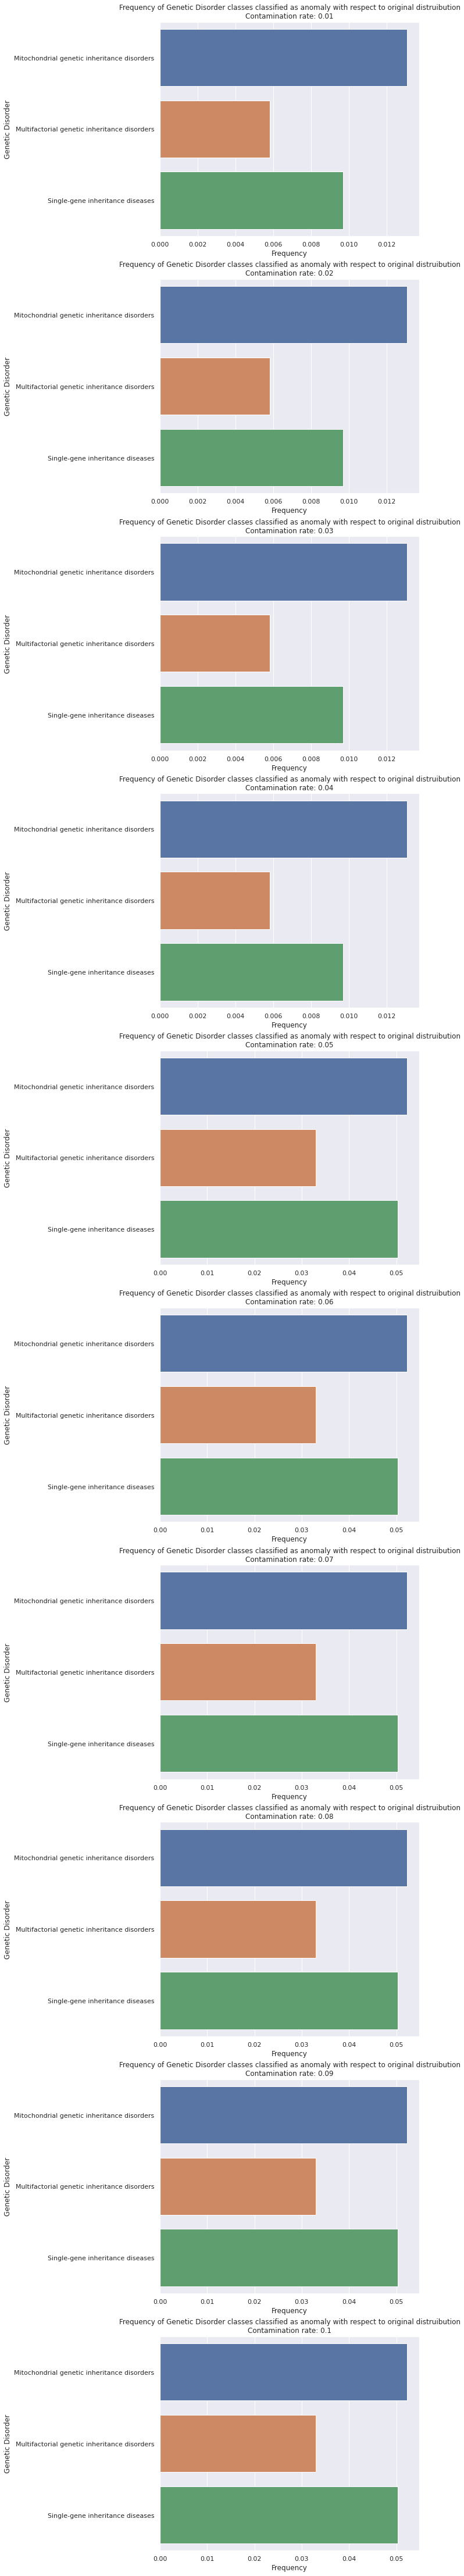

In [ ]:
# KNN anomaly detection
from pyod.models.knn import KNN
y_GD = data_drop_encoded[['Genetic Disorder']]

from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy = 'not minority')
x_under, y_under = undersample.fit_resample(X, y_GD)

count = 0
fig, ax = plt.subplots(10,1, figsize = (8,80))
for i in np.linspace(0.01,0.1,10):
  KNN_model = KNN(contamination = round(i,2))
  KNN_model.fit(x_under) # Fit model
  outlier_labels = KNN_model.labels_
  outliers = pd.concat([x_under, y_under],axis = 1).iloc[outlier_labels == 1]
  print('Contamination =', round(i,2))
  print(outliers['Genetic Disorder'].value_counts(),end = '\n\n')
  g = sb.barplot(y =  outliers['Genetic Disorder'].value_counts().sort_index().index, x = [outliers['Genetic Disorder'].value_counts().sort_index().to_list()[num] / y_under['Genetic Disorder'].value_counts().sort_index().to_list()[num] for num in range(3)], ax = ax[count])
  ax[count].set_title('Frequency of Genetic Disorder classes classified as anomaly with respect to original distruibution\nContamination rate: ' + str(round(i,2)))
  ax[count].set_xlabel('Frequency')
  ax[count].set_ylabel('Genetic Disorder')
  count += 1

Oversampling

The minority classes, from Genetic Disorder or Genetic Subclass, were oversampled by picking samples at random with replacement. The sampling strategy was defaulted to use “not majority” which resample all classes but the majority class. One benefit of using this imbalance treatment would be avoiding the removal of important data points as done in undersampling. However, computational runtime was significantly increased. 


In [ ]:
## Oversampling
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Naive Bayes
# Oversampling based on Disorder Subclass

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, X_train, y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.431680        0.428858          0.429063         0.427024
std           0.002802        0.004973          0.002172         0.003991
min           0.425764        0.419143          0.425226         0.417528
25%           0.429977        0.425872          0.427366         0.424932
50%           0.431942        0.427972          0.428967         0.427273
75%           0.433651        0.431605          0.430778         0.429426
max           0.436854        0.440245          0.432790         0.437122

In [ ]:
# Support Vector Machine
# Oversampling based on Disorder Subclass

from sklearn import svm
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_svm = svm.SVC(decision_function_shape='ovo') # Instantiate model
    main_class_svm.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

In [ ]:
# Random Forest
# Oversampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)


    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3) # Instantiate model
    randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.480289        0.479511          0.477752         0.478137
std           0.003194        0.006266          0.002214         0.005286
min           0.476233        0.468777          0.472491         0.469425
25%           0.477814        0.474537          0.476058         0.474995
50%           0.479422        0.479813          0.478103         0.477552
75%           0.482208        0.482854          0.479409         0.480297
max           0.487322        0.494940          0.481993         0.494079

In [ ]:
# Change depth of Random Forest
# Oversampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      oversample = RandomOverSampler()
      X_over, y_over = oversample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())


Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.428333        0.428280          0.425786         0.426149
std           0.007824        0.009352          0.004741         0.006797
min           0.413410        0.411391          0.414809         0.413761
25%           0.423813        0.421888          0.422925         0.420893
50%           0.429048        0.427595          0.424984         0.424151
75%           0.434263        0.433301          0.428288         0.431119
max           0.441161        0.446705          0.434055         0.438954

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.472897        0.470919          0.471204         0.471493
std           0.004125        0.005568          0.002304         0.003648
min           0.465735        0.458872          0.466193         0.466408
25%           0.470331        0.466893          0.470109         0.468775
50%           0.472195        0.471092          0.471563         0.471361
75%           0.475304        0.475102          0.472518         0.473380
max           0.483150        0.482235          0.475425         0.480619

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.483754        0.481356          0.481013         0.480918
std           0.005149        0.004717          0.003305         0.003683
min           0.476933        0.474053          0.474887         0.471899
25%           0.480331        0.478386          0.479476         0.478953
50%           0.482599        0.481320          0.480768         0.481159
75%           0.486656        0.484012          0.482881         0.483929
max           0.500242        0.495263          0.489233         0.487943

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.517883        0.514704          0.514589         0.514941
std           0.006654        0.008053          0.003407         0.004470
min           0.502584        0.492786          0.506541         0.507969
25%           0.514757        0.509394          0.512516         0.511843
50%           0.517684        0.515827          0.514912         0.514265
75%           0.522347        0.521372          0.516284         0.518787
max           0.531654        0.526270          0.521937         0.523686

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.553177        0.549117          0.547755         0.548780
std           0.004304        0.005548          0.002573         0.003502
min           0.546162        0.539298          0.542743         0.540805
25%           0.550253        0.545354          0.545677         0.546996
50%           0.553241        0.548503          0.547467         0.548557
75%           0.554600        0.552433          0.549782         0.551761
max           0.564653        0.561047          0.553187         0.555233

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.597687        0.586398          0.586899         0.583014
std           0.004022        0.005345          0.002131         0.004072
min           0.588744        0.574074          0.581907         0.575907
25%           0.595627        0.582822          0.585312         0.579753
50%           0.596886        0.587048          0.586658         0.583009
75%           0.600634        0.589982          0.588891         0.586026
max           0.607262        0.596684          0.590197         0.593021

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.643646        0.624494          0.623231         0.617116
std           0.002091        0.003795          0.002063         0.004951
min           0.640208        0.617894          0.618971         0.606805
25%           0.641944        0.621716          0.622181         0.613290
50%           0.643667        0.624085          0.623398         0.617034
75%           0.645039        0.627692          0.624233         0.620962
max           0.648444        0.632321          0.628876         0.629629

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.694140        0.657023          0.656214         0.645880
std           0.002725        0.003882          0.002121         0.003928
min           0.689922        0.646964          0.650894         0.637597
25%           0.692426        0.655362          0.654783         0.643116
50%           0.693354        0.656977          0.656169         0.645672
75%           0.695595        0.659561          0.657690         0.647986
max           0.699935        0.663975          0.659776         0.654716

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.766230        0.699813          0.697079         0.673091
std           0.002404        0.003417          0.001623         0.003976
min           0.760982        0.692506          0.693852         0.664728
25%           0.764696        0.699074          0.696107         0.669978
50%           0.766190        0.699882          0.697405         0.673666
75%           0.768169        0.701335          0.697829         0.675737
max           0.771775        0.709410          0.700474         0.682818

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.854613        0.754084          0.747445         0.692273
std           0.001519        0.003926          0.001456         0.005261
min           0.851206        0.745155          0.743701         0.681094
25%           0.853588        0.751427          0.746777         0.689411
50%           0.854449        0.754414          0.747376         0.692452
75%           0.855842        0.756379          0.748251         0.695146
max           0.856912        0.760982          0.751238         0.704780

In [ ]:
# Change number of trees of Random Forest
# Oversampling based on Disorder Subclass

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

for num_tree in range(100,501,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      oversample = RandomOverSampler()
      X_over, y_over = oversample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 6, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5, n_jobs = -1).mean())  # Test set 5-fold cross-validation
  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.591946        0.582720          0.580352         0.578273
std           0.004385        0.005524          0.002777         0.005255
min           0.582257        0.570306          0.572998         0.566430
25%           0.589033        0.578704          0.578630         0.575662
50%           0.591731        0.583495          0.580090         0.578436
75%           0.594443        0.586509          0.582034         0.580912
max           0.599779        0.593885          0.587398         0.589256

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.593337        0.582346          0.581763         0.578754
std           0.003774        0.004275          0.002641         0.003403
min           0.584195        0.571705          0.578111         0.571059
25%           0.591334        0.579269          0.579827         0.576576
50%           0.592512        0.582580          0.581099         0.577682
75%           0.595365        0.585164          0.582802         0.581236
max           0.599779        0.593239          0.587505         0.585057

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.593346        0.583258          0.580806         0.578596
std           0.003304        0.004979          0.002412         0.005021
min           0.585056        0.573966          0.575581         0.568689
25%           0.591449        0.579619          0.579316         0.574775
50%           0.592727        0.582364          0.581005         0.579082
75%           0.594847        0.586725          0.582149         0.581986
max           0.600937        0.595392          0.586348         0.590655

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.592685        0.582393          0.581169         0.579324
std           0.002691        0.005231          0.002545         0.004123
min           0.586456        0.573643          0.574585         0.571704
25%           0.591227        0.578515          0.579787         0.576578
50%           0.592848        0.582257          0.581261         0.578919
75%           0.594470        0.585648          0.582876         0.582579
max           0.597464        0.594854          0.585971         0.587104

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.592632        0.580455          0.581482         0.578463
std           0.003964        0.006119          0.002752         0.003672
min           0.586806        0.568152          0.576201         0.571703
25%           0.590244        0.575877          0.579606         0.575716
50%           0.592270        0.581449          0.581584         0.578918
75%           0.593952        0.584222          0.582903         0.581156
max           0.602175        0.593023          0.587533         0.585810

In [ ]:
# AdaBoost
# Oversampling based on Disorder Subclass

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 1) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())   # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.407238        0.404457          0.404814         0.403302
std           0.003065        0.003901          0.002750         0.006131
min           0.400409        0.396641          0.398417         0.389427
25%           0.405537        0.402885          0.402959         0.399331
50%           0.407555        0.404608          0.404823         0.403961
75%           0.409170        0.406761          0.406741         0.406947
max           0.413275        0.415590          0.410288         0.415482

Contamination = 0.01
Mitochondrial genetic inheritance disorders     52
Single-gene inheritance diseases                43
Multifactorial genetic inheritance disorders     1
Name: Genetic Disorder, dtype: int64

Contamination = 0.02
Mitochondrial genetic inheritance disorders     278
Single-gene inheritance diseases                252
Multifactorial genetic inheritance disorders     11
Name: Genetic Disorder, dtype: int64

Contamination = 0.03
Mitochondrial genetic inheritance disorders     278
Single-gene inheritance diseases                252
Multifactorial genetic inheritance disorders     11
Name: Genetic Disorder, dtype: int64

Contamination = 0.04
Mitochondrial genetic inheritance disorders     278
Single-gene inheritance diseases                252
Multifactorial genetic inheritance disorders     11
Name: Genetic Disorder, dtype: int64

Contamination = 0.05
Mitochondrial genetic inheritance disorders     278
Single-gene inheritance diseases                252
Multifactorial gen

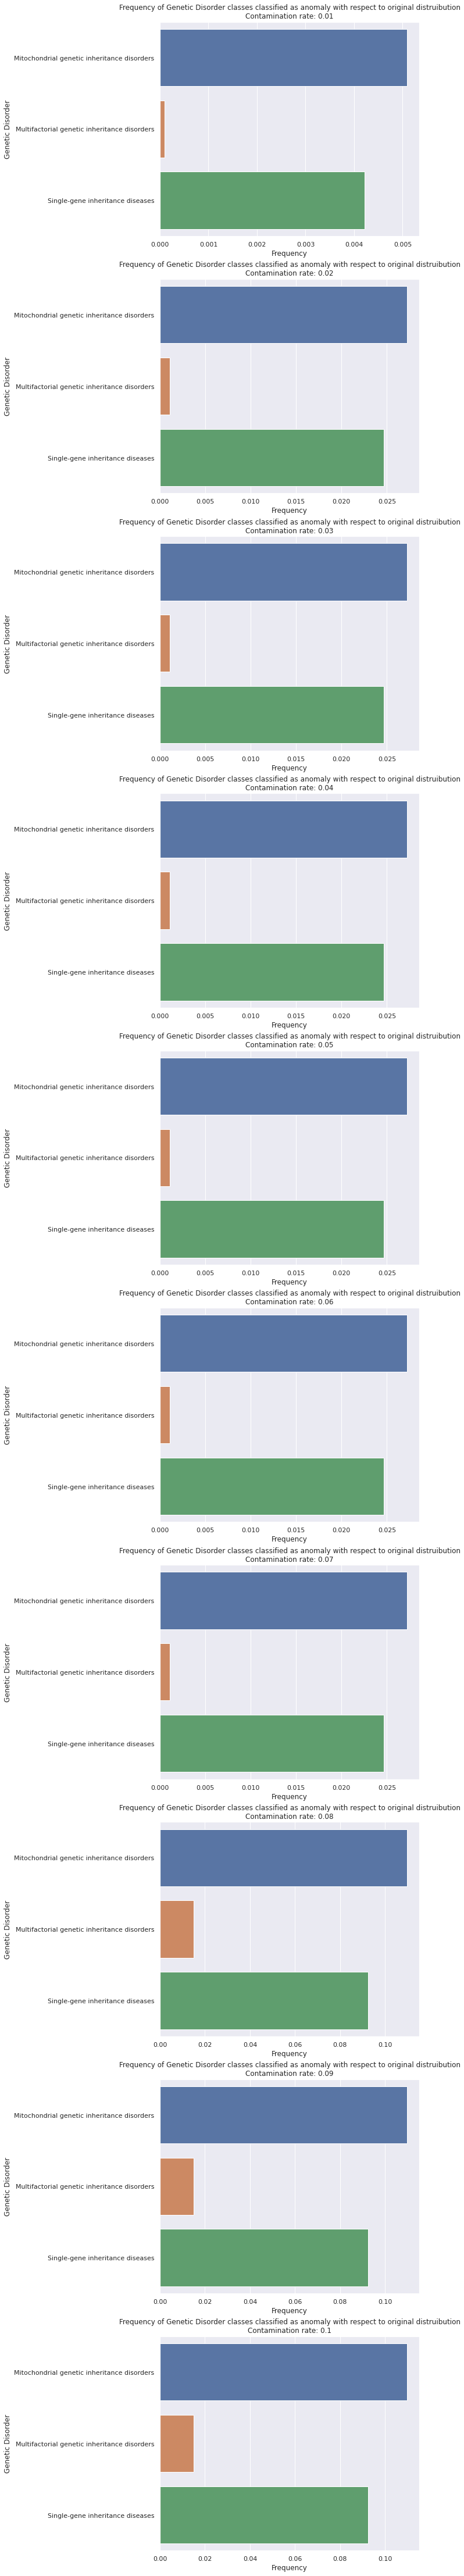

In [ ]:
# KNN anomaly detection
from pyod.models.knn import KNN
from imblearn.over_sampling import RandomOverSampler

y_GD = data_drop_encoded[['Genetic Disorder']]

from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy = 'not majority')
X_over, y_over = oversample.fit_resample(X, y_GD)

fig, ax = plt.subplots(10,1, figsize = (8,80))
count = 0
for i in np.linspace(0.01,0.1,10):
  KNN_model = KNN(contamination = round(i,2))
  KNN_model.fit(X_over) # Fit model
  outlier_labels = KNN_model.labels_
  outliers = pd.concat([X_over, y_over],axis = 1).iloc[outlier_labels == 1]
  print('Contamination =', round(i,2))
  print(outliers['Genetic Disorder'].value_counts(),end = '\n\n')
  g = sb.barplot(y =  outliers['Genetic Disorder'].value_counts().sort_index().index, x = [outliers['Genetic Disorder'].value_counts().sort_index().to_list()[num] / y_over['Genetic Disorder'].value_counts().sort_index().to_list()[num] for num in range(3)], ax = ax[count])
  ax[count].set_title('Frequency of Genetic Disorder classes classified as anomaly with respect to original distruibution\nContamination rate: ' + str(round(i,2)))
  ax[count].set_xlabel('Frequency')
  ax[count].set_ylabel('Genetic Disorder')
  count += 1

SMOTE

Instead of oversampling minority class by duplication, SMOTE synthesize new examples from the minority class which are close in the feature space. This helps to provide additional information to the model. The sampling strategy was defaulted to use “not majority” which resample all classes but the majority class. This method was found to be the best imbalance treatment method amongst the ones tried.


In [ ]:
##SMOTE oversampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [ ]:
# Naive Bayes 
# SMOTE based on Disorder Subclass statification

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, X_train, y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())   # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.520480        0.519857          0.519307         0.517883
std           0.001611        0.004672          0.001557         0.004387
min           0.517980        0.511843          0.516715         0.509367
25%           0.519239        0.516904          0.518249         0.515102
50%           0.520295        0.520080          0.519138         0.517764
75%           0.521479        0.522879          0.520114         0.519972
max           0.524952        0.531115          0.523040         0.528317

In [ ]:
# Support Vector Machine
# SMOTE based on Disorder Subclass statification

from sklearn import svm
y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    main_class_svm = svm.SVC(decision_function_shape='ovo') # Instantiate model
    main_class_svm.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

In [ ]:
# Random Forest
# SMOTE based on Disorder Subclass statification

from sklearn.ensemble import RandomForestClassifier

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3) # Instantiate model
    randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.536099        0.533961          0.534877         0.533614
std           0.007808        0.007643          0.004655         0.006263
min           0.521829        0.519165          0.525140         0.520566
25%           0.531667        0.530146          0.531997         0.529797
50%           0.535059        0.533053          0.535046         0.533862
75%           0.537986        0.536849          0.536781         0.538330
max           0.557924        0.559324          0.545839         0.547696

In [ ]:
# Change depth of Random Forest
# SMOTE based on Disorder Subclass statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder


for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean())  # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.469711        0.468562          0.470256         0.467636
std           0.004889        0.005704          0.003161         0.005227
min           0.459814        0.458441          0.462182         0.452088
25%           0.465870        0.465305          0.468326         0.465897
50%           0.469854        0.468454          0.470540         0.467700
75%           0.472552        0.472814          0.472330         0.471821
max           0.479759        0.480405          0.476879         0.475667

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.511151        0.509033          0.510107         0.508118
std           0.003285        0.004540          0.001989         0.003996
min           0.502934        0.502153          0.505491         0.499569
25%           0.509286        0.505841          0.508566         0.506084
50%           0.511345        0.507860          0.510134         0.508130
75%           0.513297        0.511816          0.511372         0.511090
max           0.516204        0.518411          0.513593         0.514320

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.538212        0.536208          0.537383         0.532605
std           0.005669        0.006566          0.003941         0.006622
min           0.528505        0.525517          0.530200         0.520565
25%           0.534433        0.531169          0.535119         0.528209
50%           0.536297        0.535368          0.537630         0.532786
75%           0.542750        0.541828          0.540153         0.535854
max           0.550684        0.549096          0.543982         0.553298

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.592156        0.587170          0.586967         0.582659
std           0.003090        0.004879          0.002002         0.004685
min           0.587129        0.577842          0.583064         0.573536
25%           0.590338        0.583253          0.585870         0.579216
50%           0.592377        0.587425          0.586698         0.581503
75%           0.594194        0.590493          0.587976         0.586643
max           0.597626        0.598407          0.591893         0.590225

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.615250        0.609381          0.608708         0.603628
std           0.003761        0.005559          0.002533         0.003877
min           0.608662        0.599160          0.603224         0.594315
25%           0.612269        0.604866          0.607013         0.600369
50%           0.614947        0.609927          0.608675         0.604220
75%           0.617154        0.613668          0.610230         0.606860
max           0.623654        0.619617          0.613856         0.609280

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.641498        0.628915          0.629096         0.621296
std           0.002912        0.004704          0.002388         0.005493
min           0.636655        0.620801          0.623950         0.607450
25%           0.639676        0.625888          0.627497         0.617813
50%           0.641473        0.628338          0.628970         0.621932
75%           0.643532        0.631729          0.630746         0.623492
max           0.649063        0.637489          0.634044         0.632860

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.668671        0.648740          0.647434         0.636441
std           0.002567        0.004852          0.001760         0.004233
min           0.662145        0.637705          0.644245         0.628123
25%           0.667676        0.646264          0.645887         0.633559
50%           0.668860        0.647987          0.647583         0.636734
75%           0.670617        0.652239          0.648754         0.639212
max           0.672346        0.658484          0.650544         0.644702

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.704932        0.671221          0.667557         0.651565
std           0.002131        0.004019          0.002034         0.004193
min           0.701577        0.660422          0.662952         0.642228
25%           0.702997        0.669358          0.666788         0.647853
50%           0.704996        0.671619          0.667286         0.652293
75%           0.705844        0.673853          0.668921         0.655011
max           0.709921        0.677110          0.670973         0.658160

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.747972        0.690676          0.688555         0.664136
std           0.002539        0.004036          0.002041         0.004264
min           0.740983        0.679802          0.684566         0.655363
25%           0.746528        0.687204          0.687318         0.661660
50%           0.748560        0.691268          0.688630         0.662951
75%           0.749145        0.694041          0.689364         0.666396
max           0.752396        0.696275          0.693125         0.674094

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.809280        0.714517          0.711483         0.678057
std           0.002457        0.003760          0.001523         0.003800
min           0.804021        0.707903          0.709168         0.671297
25%           0.807897        0.711456          0.710399         0.675415
50%           0.809432        0.714309          0.711334         0.677487
75%           0.811134        0.716893          0.711900         0.680987
max           0.813792        0.721792          0.716354         0.687659

In [ ]:
# Change number of trees of Random Forest
# SMOTE based on Disorder Subclass statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder


for num_tree in range(100,601,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      # Remove Genetic Disorder from predictors
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 5) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.613966        0.607217          0.606640         0.602620
std           0.002963        0.004057          0.002401         0.004275
min           0.609765        0.600022          0.600398         0.595067
25%           0.611326        0.603790          0.604974         0.599941
50%           0.613964        0.607558          0.607235         0.601853
75%           0.615243        0.610142          0.608130         0.605164
max           0.621905        0.616925          0.611434         0.612294

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.616249        0.609091          0.608722         0.603714
std           0.002824        0.005482          0.002320         0.004690
min           0.609900        0.597115          0.604571         0.593348
25%           0.614408        0.604866          0.607444         0.601394
50%           0.616064        0.608527          0.608904         0.603088
75%           0.617356        0.613318          0.609866         0.605648
max           0.622847        0.620801          0.613830         0.615953

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.616101        0.608689          0.608804         0.603528
std           0.002883        0.004089          0.002072         0.004208
min           0.609173        0.600668          0.604813         0.596254
25%           0.613931        0.606966          0.607794         0.600883
50%           0.616885        0.608473          0.608500         0.602768
75%           0.618163        0.611003          0.609530         0.605728
max           0.621124        0.617033          0.615579         0.612837

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.616197        0.609869          0.609273         0.605398
std           0.002874        0.004083          0.001749         0.004529
min           0.611461        0.603467          0.606454         0.597223
25%           0.613715        0.606643          0.608231         0.602229
50%           0.615633        0.609550          0.609281         0.606320
75%           0.618567        0.612888          0.610465         0.608904
max           0.622793        0.617248          0.613264         0.613158

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.616162        0.608157          0.608811         0.603772
std           0.002316        0.003813          0.002162         0.004947
min           0.612376        0.597868          0.605136         0.590762
25%           0.614624        0.605755          0.607424         0.600963
50%           0.615431        0.608473          0.608325         0.604005
75%           0.617322        0.610788          0.609987         0.607019
max           0.621635        0.614664          0.614099         0.612401

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.616703        0.610458          0.609561         0.606155
std           0.002227        0.004114          0.001849         0.004994
min           0.612161        0.604543          0.606105         0.598833
25%           0.615175        0.607020          0.608096         0.601986
50%           0.616858        0.609442          0.609725         0.605727
75%           0.617975        0.614395          0.611178         0.610035
max           0.620505        0.620478          0.613210         0.616496

In [ ]:
# AdaBoost
# SMOTE based on Disorder Subclass statification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

y_SC = data_drop_encoded[['Disorder Subclass']] # Extract Disorder Subclass
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 1) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder']) # Convert encoded Genetic Disorder back to original values
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    # Remove Genetic Disorder from predictors
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())



Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.527673        0.524720          0.524246         0.520665
std           0.002123        0.003532          0.002150         0.005838
min           0.523983        0.517119          0.520779         0.506784
25%           0.526163        0.522125          0.522590         0.518248
50%           0.527172        0.524871          0.524427         0.520027
75%           0.528908        0.527213          0.525557         0.523769
max           0.532730        0.530792          0.529312         0.533053

Contamination = 0.01
Mitochondrial genetic inheritance disorders     162
Single-gene inheritance diseases                102
Multifactorial genetic inheritance disorders      2
Name: Genetic Disorder, dtype: int64

Contamination = 0.02
Mitochondrial genetic inheritance disorders     162
Single-gene inheritance diseases                102
Multifactorial genetic inheritance disorders      2
Name: Genetic Disorder, dtype: int64

Contamination = 0.03
Mitochondrial genetic inheritance disorders     542
Single-gene inheritance diseases                372
Multifactorial genetic inheritance disorders      6
Name: Genetic Disorder, dtype: int64

Contamination = 0.04
Mitochondrial genetic inheritance disorders     714
Single-gene inheritance diseases                501
Multifactorial genetic inheritance disorders     11
Name: Genetic Disorder, dtype: int64

Contamination = 0.05
Mitochondrial genetic inheritance disorders     722
Single-gene inheritance diseases                504
Multifactorial 

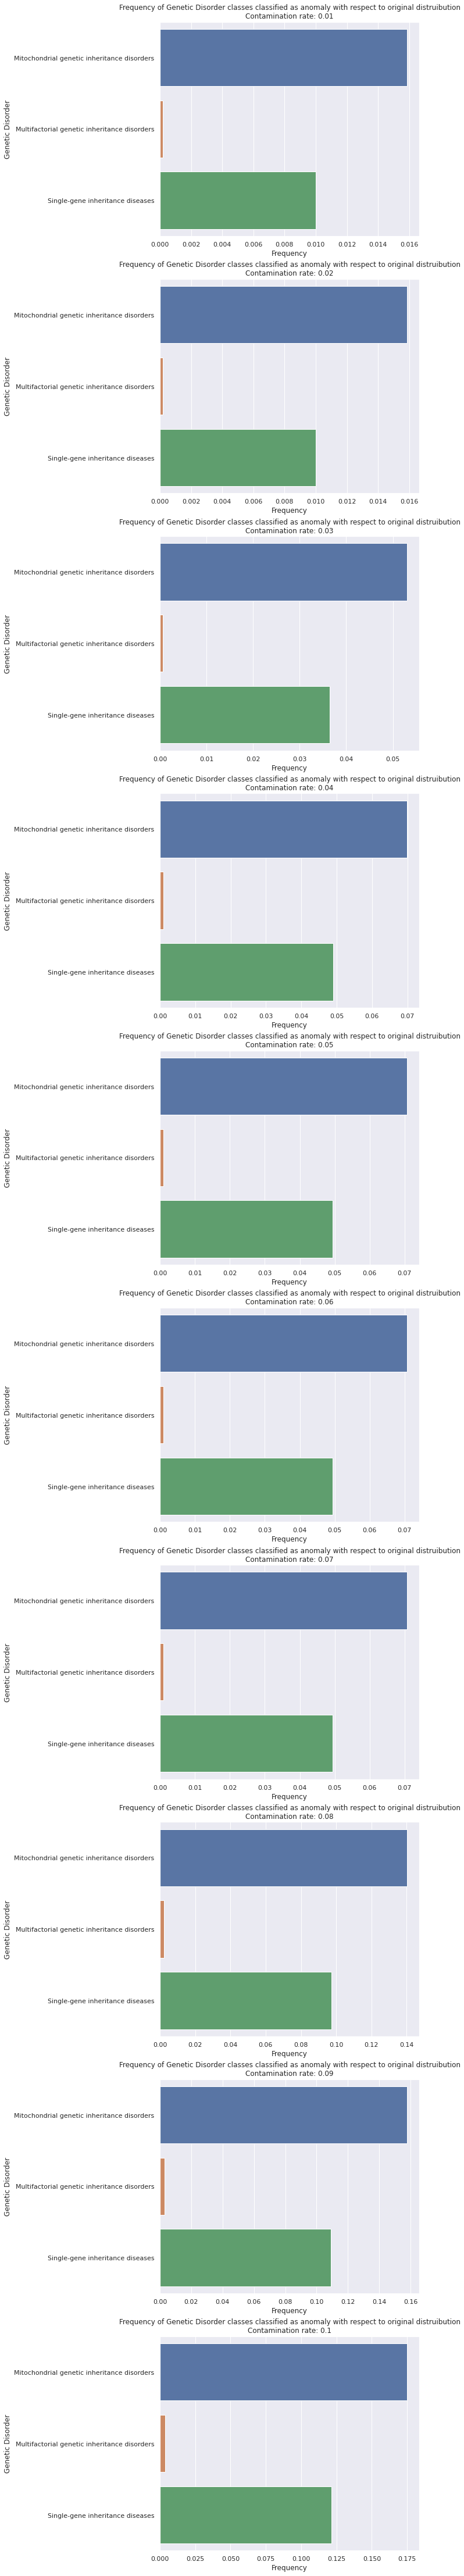

In [ ]:
# KNN anomaly detection
from pyod.models.knn import KNN
from imblearn.over_sampling import SMOTE

y_GD = data_drop_encoded[['Genetic Disorder']]

smote_sample = SMOTE()
X_over, y_over = smote_sample.fit_resample(X, y_GD)

fig, ax = plt.subplots(10,1, figsize = (8,80))
count = 0
for i in np.linspace(0.01,0.1,10):
  KNN_model = KNN(contamination = round(i,2))
  KNN_model.fit(X_over) # Fit model
  outlier_labels = KNN_model.labels_
  outliers = pd.concat([X_over, y_over],axis = 1).iloc[outlier_labels == 1]
  print('Contamination =', round(i,2))
  print(outliers['Genetic Disorder'].value_counts(),end = '\n\n')
  g = sb.barplot(y =  outliers['Genetic Disorder'].value_counts().sort_index().index, x = [outliers['Genetic Disorder'].value_counts().sort_index().to_list()[num] / y_over['Genetic Disorder'].value_counts().sort_index().to_list()[num] for num in range(3)], ax = ax[count])
  ax[count].set_title('Frequency of Genetic Disorder classes classified as anomaly with respect to original distruibution\nContamination rate: ' + str(round(i,2)))
  ax[count].set_xlabel('Frequency')
  ax[count].set_ylabel('Genetic Disorder')
  count += 1

# Stratify by Genetic Disorder

Imbalance

Performance of models created were evaluated using original imbalance data. The results serve as a control to compare with other imbalance treatment methods. The imbalance dataset was hypothesised to produce the worse performing models.


In [ ]:
# Naive Bayes

from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB()  # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.537152        0.529576          0.524967         0.496184
std           0.002292        0.005238          0.002565         0.008138
min           0.533643        0.519960          0.520273         0.482049
25%           0.535322        0.525797          0.523679         0.488887
50%           0.536907        0.527868          0.524636         0.497869
75%           0.538727        0.534020          0.526535         0.502192
max           0.542493        0.543058          0.530379         0.511426

In [ ]:
# Support Vector Machine
from sklearn import svm

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo')  # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)
count        30.000000       30.000000
mean          0.543596        0.527408
std           0.003252        0.002305
min           0.537535        0.523726
25%           0.541348        0.525734
50%           0.543152        0.527241
75%           0.545506        0.528935
max           0.550716        0.531509

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3, n_jobs = -1) # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01         30.000000        30.000000
mean      5.128044e-01    5.129300e-01          0.512809         0.512989
std       2.258405e-16    2.258405e-16          0.000023         0.000215
min       5.128044e-01    5.129300e-01          0.512742         0.512679
25%       5.128044e-01    5.129300e-01          0.512804         0.512930
50%       5.128044e-01    5.129300e-01          0.512804         0.512930
75%       5.128044e-01    5.129300e-01          0.512804         0.512930
max       5.128044e-01    5.129300e-01          0.512867         0.513934

In [ ]:
# Change depth of Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01      3.000000e+01     3.000000e+01
mean      5.128044e-01    5.129300e-01      5.128044e-01     5.129299e-01
std       2.258405e-16    2.258405e-16      2.258405e-16     2.565135e-07
min       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
25%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
50%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
75%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
max       5.128044e-01    5.129300e-01      5.128044e-01     5.129304e-01

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01      3.000000e+01     3.000000e+01
mean      5.128044e-01    5.129300e-01      5.128044e-01     5.129300e-01
std       2.258405e-16    2.258405e-16      2.258405e-16     3.090311e-07
min       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
25%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
50%       5.128044e-01    5.129300e-01      5.128044e-01     5.129298e-01
75%       5.128044e-01    5.129300e-01      5.128044e-01     5.129304e-01
max       5.128044e-01    5.129300e-01      5.128044e-01     5.129304e-01

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count     3.000000e+01    3.000000e+01         30.000000        30.000000
mean      5.128044e-01    5.129300e-01          0.512804         0.512955
std       2.258405e-16    2.258405e-16          0.000016         0.000121
min       5.128044e-01    5.129300e-01          0.512742         0.512679
25%       5.128044e-01    5.129300e-01          0.512804         0.512930
50%       5.128044e-01    5.129300e-01          0.512804         0.512930
75%       5.128044e-01    5.129300e-01          0.512804         0.512930
max       5.128044e-01    5.129300e-01          0.512867         0.513432

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.515482        0.515734          0.515489         0.515349
std           0.001141        0.001082          0.000829         0.001693
min           0.513871        0.513432          0.514311         0.513181
25%           0.514687        0.514938          0.514829         0.514186
50%           0.515284        0.515692          0.515221         0.514687
75%           0.515990        0.516445          0.516162         0.516131
max           0.518516        0.517700          0.517261         0.519459

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524266        0.522881          0.522362         0.519985
std           0.002124        0.002179          0.001035         0.003738
min           0.520839        0.518956          0.520839         0.514939
25%           0.522816        0.521027          0.521498         0.517512
50%           0.523977        0.522722          0.522376         0.518580
75%           0.525483        0.524416          0.523145         0.522031
max           0.530505        0.527241          0.524730         0.530003

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.536405        0.529785          0.529111         0.524513
std           0.002548        0.002514          0.001245         0.004723
min           0.530505        0.524730          0.526676         0.515442
25%           0.535134        0.528308          0.528198         0.521968
50%           0.537032        0.530128          0.529187         0.524104
75%           0.538272        0.531007          0.529987         0.527619
max           0.541112        0.535777          0.532388         0.534019

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.558936        0.538028          0.536421         0.526839
std           0.002922        0.003357          0.002094         0.006059
min           0.552661        0.530254          0.531383         0.512424
25%           0.556710        0.536530          0.535039         0.523790
50%           0.559503        0.538037          0.536311         0.525862
75%           0.561103        0.539920          0.537958         0.528875
max           0.564085        0.545067          0.540547         0.543058

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.599646        0.544205          0.542926         0.530764
std           0.003116        0.003247          0.001839         0.006695
min           0.591514        0.537786          0.539230         0.518959
25%           0.598575        0.542116          0.541410         0.526488
50%           0.599579        0.544313          0.543152         0.529754
75%           0.601855        0.546510          0.544047         0.534018
max           0.605072        0.551594          0.546322         0.548830

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.673169        0.549661          0.548899         0.529308
std           0.002914        0.004303          0.002491         0.007476
min           0.667587        0.540296          0.544438         0.517197
25%           0.671275        0.546824          0.547655         0.524480
50%           0.672609        0.549335          0.549052         0.527871
75%           0.674445        0.552787          0.550088         0.534211
max           0.680831        0.559879          0.553854         0.546066

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.786158        0.555277          0.552768         0.528814
std           0.002605        0.005183          0.002903         0.007125
min           0.780065        0.544815          0.548205         0.516447
25%           0.784867        0.551783          0.550904         0.523854
50%           0.785934        0.556616          0.551971         0.526738
75%           0.787629        0.558938          0.554042         0.533698
max           0.791049        0.562892          0.560256         0.545318

In [ ]:
# Change number of trees of Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 5, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.523801        0.522931          0.521960         0.519801
std           0.001449        0.001775          0.001259         0.004194
min           0.520399        0.519207          0.519332         0.513430
25%           0.523302        0.522031          0.521090         0.516571
50%           0.523977        0.522722          0.521717         0.519585
75%           0.524573        0.523977          0.522643         0.521905
max           0.526237        0.526488          0.524667         0.529750

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524289        0.522948          0.522163         0.518964
std           0.001560        0.001960          0.001032         0.003760
min           0.522094        0.520462          0.520148         0.512930
25%           0.522988        0.521529          0.521403         0.515755
50%           0.524071        0.522847          0.522314         0.517827
75%           0.525107        0.524165          0.522894         0.521341
max           0.527680        0.527492          0.524040         0.527491

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524125        0.522772          0.522094         0.518453
std           0.001560        0.001747          0.001228         0.003868
min           0.521403        0.520211          0.520399         0.513935
25%           0.522800        0.521717          0.520823         0.515692
50%           0.524008        0.522345          0.522188         0.517197
75%           0.524934        0.523914          0.523067         0.521153
max           0.526801        0.527492          0.524730         0.532009

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524249        0.522295          0.522102         0.519065
std           0.001225        0.001721          0.000887         0.002973
min           0.522470        0.518956          0.520588         0.513684
25%           0.523600        0.521027          0.521545         0.516697
50%           0.524134        0.522345          0.521874         0.518832
75%           0.524793        0.523161          0.522816         0.521340
max           0.527994        0.526237          0.524040         0.524227

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524159        0.522186          0.522291         0.517700
std           0.001246        0.001678          0.001104         0.003572
min           0.521592        0.519207          0.520399         0.510421
25%           0.523412        0.520776          0.521576         0.514751
50%           0.523914        0.521968          0.522062         0.517826
75%           0.525185        0.523600          0.523208         0.519646
max           0.526425        0.524981          0.524542         0.524479

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524247        0.521952          0.522234         0.517784
std           0.001092        0.001837          0.000962         0.003562
min           0.522345        0.517951          0.520211         0.512930
25%           0.523506        0.521090          0.521419         0.514499
50%           0.524354        0.522219          0.522251         0.517953
75%           0.524903        0.523098          0.522878         0.521026
max           0.526488        0.525232          0.524856         0.524227

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.524027        0.522922          0.521805         0.519366
std           0.001151        0.001755          0.001106         0.003759
min           0.521215        0.519207          0.520023         0.513182
25%           0.523349        0.522219          0.521105         0.517450
50%           0.524102        0.522722          0.521812         0.518327
75%           0.524714        0.524228          0.522502         0.521717
max           0.526425        0.525483          0.524605         0.528749

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.523969        0.522470          0.521759         0.519090
std           0.001211        0.001627          0.001011         0.003380
min           0.521906        0.518704          0.519959         0.514186
25%           0.523192        0.521529          0.520964         0.515755
50%           0.523883        0.522470          0.521874         0.519333
75%           0.524589        0.523475          0.522596         0.521279
max           0.527052        0.525734          0.523412         0.525485

In [ ]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 2) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.572470        0.547209          0.538633         0.484131
std           0.002543        0.006514          0.002367         0.007974
min           0.566596        0.535024          0.532639         0.469242
25%           0.570958        0.543372          0.537220         0.479413
50%           0.572653        0.546950          0.538288         0.483433
75%           0.574002        0.552410          0.540312         0.487760
max           0.576513        0.561888          0.542619         0.501380

KModes

As the predictors were mainly categorical variables to begin with and the few continuous variables were all converted to categorical variables, KMeans would no longer be an option to be used for clustering. KModes was used instead. It works by calculating dissimilarity between the data points. In the project, the optimal number of clusters, also the hyperparameter K, was determined by plotting an Elbow curve and the optimal number was chosen at the area where the curve bends. 6 was chosen for all KModes performed after different imbalance treatment methods. Therefore, 6 points were picked at random to label as clusters. Dissimilarities were then calculated and each observation was assigned to the closest cluster. New modes of clusters were redefined and the process repeats until there is no more re-assignment of points.
After clustering with all types of imbalance treatments, all were found to be ineffective in grouping the different Genetic Disorder classes, particularly between single-gene and mitochondrial disorders.


Best run was number 1
Best run was number 4
Best run was number 1
Best run was number 2
Best run was number 4
Best run was number 2
Best run was number 3
Best run was number 1
Best run was number 4
Best run was number 1
Best run was number 5
Best run was number 3
Best run was number 4
Best run was number 5
Best run was number 5
Best run was number 3
Best run was number 4
Best run was number 1
Best run was number 2
Best run was number 4
Best run was number 2
Best run was number 3
Best run was number 2
Best run was number 3
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 4
Best run was number 4
Best run was number 4


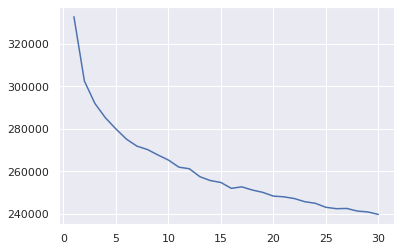

In [ ]:
# KModes
from kmodes.kmodes import KModes

pred_feat = list(data_drop_imputed.columns)
pred_feat.remove('Genetic Disorder')
pred_feat.remove('Disorder Subclass')
# Plot Elbow plot to decide optimal cluster number
cost = []
for i in range(1,31):
  km = KModes(n_clusters = i, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2)  # Instantiate model
  km.fit(data_drop_imputed[pred_feat]) # Fit model
  cost.append(km.cost_)

sb.lineplot(x = range(1,31), y = cost, estimator = None)

Best run was number 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Clusters                                         0     1     2     3     4  \
Genetic Disorder                                                             
Mitochondrial genetic inheritance disorders   1688  2406  1451  1413  1936   
Multifactorial genetic inheritance disorders   395   310   127   249   616   
Single-gene inheritance diseases              1264  1733  1225  1030  1418   

Clusters                                         5  
Genetic Disorder                                    
Mitochondrial genetic inheritance disorders   1319  
Multifactorial genetic inheritance disorders   369  
Single-gene inheritance diseases               966

Clusters                                              0          1          2  \
Genetic Disorder                                                                
Mitochondrial genetic inheritance disorders   16.527955  23.558210  14.207383   
Multifactorial genetic inheritance disorders  19.119071  15.004840   6.147144   
Single-gene inheritance diseases              16.553169  22.695128  16.042431   

Clusters                                              3          4          5  
Genetic Disorder                                                               
Mitochondrial genetic inheritance disorders   13.835308  18.956232  12.914912  
Multifactorial genetic inheritance disorders  12.052275  29.816070  17.860600  
Single-gene inheritance diseases              13.488738  18.569932  12.650602

Text(0, 0.5, 'Proportion')

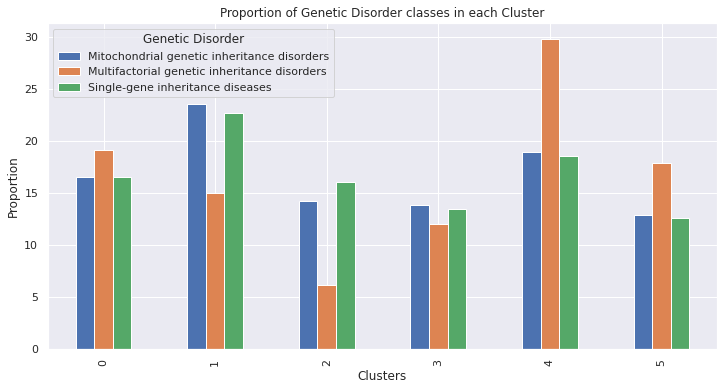

In [ ]:
# Check how cluster is defined based on Genetic Disorder 

km = KModes(n_clusters = 6, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2)  # Instantiate model
km.fit(data_drop_imputed[pred_feat]) # Fit model
clusters_X_train = km.predict(data_drop_imputed[pred_feat])

temp = data_drop_imputed[['Genetic Disorder']]
temp['Clusters'] = clusters_X_train
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack())
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1))
temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1).T.plot.bar(figsize = (12,6))
plt.title('Proportion of Genetic Disorder classes in each Cluster')
plt.ylabel('Proportion')

# Clustering seems random and no cluster can extract each Genetic Disorder cleanly

Undersampling

The majority classes, from Genetic Disorder or Genetic Subclass, were undersampled randomly without replacement. The sampling strategy was set to use “not minority” which resamples all classes except the minority class. One benefit of using this imbalance treatment would be the shorter computational time for model training as dataset size was reduced. However, it may risk removing important data points that should have been used for model training. 



In [ ]:
## Undersampling
from imblearn.under_sampling import RandomUnderSampler
y_GD = data_drop_encoded[['Genetic Disorder']]

In [ ]:
# Naive Bayes
# Undersampling based on Genetic Disorder statification

y_GD = data_drop_encoded[['Genetic Disorder']]

from imblearn.under_sampling import RandomUnderSampler

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB()  # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.554236        0.527339          0.522958         0.509086
std           0.007109        0.012231          0.008862         0.011943
min           0.539330        0.504839          0.508270         0.474194
25%           0.551029        0.521169          0.516989         0.501815
50%           0.553449        0.526210          0.523289         0.510887
75%           0.557685        0.537702          0.528137         0.517137
max           0.571400        0.548387          0.542148         0.532258

In [ ]:
# Support Vector Machine
# Undersampling based on Genetic Disorder statification

from sklearn import svm
from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo')  # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.663534        0.546694          0.541966         0.522581
std           0.005224        0.012778          0.007380         0.015023
min           0.653691        0.519355          0.526022         0.487903
25%           0.660347        0.538911          0.537214         0.510484
50%           0.663271        0.550000          0.543262         0.520968
75%           0.666852        0.555444          0.546488         0.533468
max           0.674869        0.574194          0.556073         0.550806

In [ ]:
# Random Forest
# Undersampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3) # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.598467        0.575914          0.568684         0.541317
std           0.008774        0.011844          0.008015         0.013151
min           0.583300        0.552419          0.555063         0.510484
25%           0.591620        0.570363          0.562121         0.533065
50%           0.597721        0.575403          0.568470         0.540726
75%           0.606091        0.582661          0.573871         0.551613
max           0.614361        0.597581          0.584910         0.566935

In [ ]:
# Change depth of Random Forest
# Undersampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
y_GD = data_drop_encoded[['Genetic Disorder']]

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      undersample = RandomUnderSampler(sampling_strategy = 'not minority')
      x_under, y_under = undersample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.533979        0.524812          0.525008         0.514382
std           0.011187        0.016384          0.009028         0.015567
min           0.507664        0.496774          0.510485         0.476613
25%           0.526220        0.514113          0.515733         0.504839
50%           0.536708        0.526210          0.524299         0.514113
75%           0.541297        0.534476          0.533376         0.527823
max           0.553247        0.560484          0.540543         0.545161

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.569658        0.555188          0.552144         0.532796
std           0.011266        0.015777          0.006291         0.015104
min           0.551029        0.525806          0.539129         0.504032
25%           0.561819        0.546169          0.548000         0.523387
50%           0.567366        0.553226          0.552546         0.530242
75%           0.575787        0.563508          0.557074         0.540323
max           0.594393        0.593548          0.563740         0.567742

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.594366        0.569059          0.564824         0.538091
std           0.007674        0.011527          0.006832         0.008982
min           0.574425        0.545161          0.549417         0.516129
25%           0.589250        0.560685          0.559397         0.532661
50%           0.594595        0.569355          0.564845         0.539516
75%           0.600696        0.575806          0.570338         0.544960
max           0.607100        0.591129          0.576645         0.550000

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.620983        0.580833          0.572166         0.541452
std           0.007238        0.011383          0.008704         0.015626
min           0.604881        0.550806          0.555468         0.495161
25%           0.615974        0.574395          0.565398         0.532056
50%           0.621521        0.580242          0.574426         0.541129
75%           0.625050        0.586895          0.578361         0.552218
max           0.636345        0.604032          0.583711         0.574194

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.647875        0.584328          0.578385         0.542500
std           0.004781        0.011236          0.005589         0.018701
min           0.636144        0.554032          0.566965         0.483871
25%           0.643606        0.580040          0.574375         0.531250
50%           0.649153        0.586694          0.578257         0.542339
75%           0.650615        0.591532          0.582391         0.552823
max           0.656716        0.600000          0.589141         0.585484

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.688591        0.582097          0.576463         0.540806
std           0.005541        0.010409          0.007264         0.016608
min           0.678499        0.558065          0.562530         0.502419
25%           0.685256        0.574395          0.570949         0.533266
50%           0.689290        0.584677          0.576841         0.538710
75%           0.692820        0.589315          0.579165         0.555242
max           0.701291        0.603226          0.596614         0.572581

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.748951        0.577473          0.575184         0.535860
std           0.006145        0.012025          0.005304         0.018866
min           0.737999        0.545161          0.565756         0.487097
25%           0.745311        0.570363          0.571654         0.525403
50%           0.747781        0.576613          0.575538         0.538306
75%           0.753983        0.586895          0.578457         0.546371
max           0.760992        0.598387          0.585517         0.589516

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.817218        0.575806          0.569827         0.529462
std           0.005188        0.010273          0.006329         0.012882
min           0.808189        0.560484          0.558087         0.501613
25%           0.813685        0.568952          0.565551         0.518750
50%           0.817063        0.575000          0.569985         0.529032
75%           0.819685        0.580242          0.574223         0.541935
max           0.828762        0.598387          0.582701         0.549194

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.879804        0.572231          0.565806         0.521613
std           0.004218        0.011335          0.007174         0.017715
min           0.868495        0.545968          0.545384         0.487097
25%           0.878580        0.564718          0.562124         0.509073
50%           0.879992        0.570968          0.566355         0.521774
75%           0.882967        0.579435          0.570492         0.533266
max           0.885841        0.600806          0.578256         0.551613

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.936325        0.569892          0.560709         0.523118
std           0.003469        0.011502          0.006761         0.015488
min           0.929810        0.543548          0.548809         0.481452
25%           0.933491        0.563105          0.557135         0.514113
50%           0.936567        0.570161          0.560710         0.524597
75%           0.939240        0.579435          0.564895         0.532460
max           0.942114        0.589516          0.573413         0.553226

In [ ]:
# Change number of trees of Random Forest
# Undersampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      undersample = RandomUnderSampler(sampling_strategy = 'not minority')
      x_under, y_under = undersample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 3, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.597371        0.569704          0.569860         0.538011
std           0.007055        0.014777          0.007694         0.015164
min           0.582090        0.548387          0.554257         0.500806
25%           0.592578        0.560081          0.564383         0.529839
50%           0.597620        0.567339          0.571605         0.539113
75%           0.601805        0.579839          0.575386         0.544960
max           0.611940        0.608065          0.581681         0.577419

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.600511        0.578548          0.570466         0.546532
std           0.006094        0.015561          0.007538         0.015123
min           0.589552        0.548387          0.558083         0.520161
25%           0.595452        0.570363          0.564542         0.533468
50%           0.600141        0.577823          0.569886         0.543145
75%           0.606495        0.586290          0.576439         0.558266
max           0.610932        0.621774          0.583297         0.575000

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.601089        0.573522          0.571979         0.542258
std           0.007592        0.014855          0.006777         0.016497
min           0.576846        0.543548          0.557692         0.516935
25%           0.598679        0.565927          0.568223         0.530645
50%           0.601351        0.575806          0.571505         0.541129
75%           0.605688        0.582863          0.576995         0.550806
max           0.613150        0.607258          0.585323         0.577419

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.598420        0.575672          0.569820         0.546505
std           0.007136        0.014377          0.006443         0.012308
min           0.583098        0.549194          0.552840         0.520161
25%           0.594191        0.567742          0.566158         0.538306
50%           0.599032        0.576210          0.571098         0.547581
75%           0.602864        0.584476          0.574128         0.553024
max           0.611739        0.612097          0.581486         0.571774

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.599987        0.574839          0.571096         0.546828
std           0.008529        0.016099          0.006939         0.013290
min           0.576039        0.543548          0.557280         0.525806
25%           0.594796        0.566331          0.566155         0.539516
50%           0.600645        0.572177          0.571099         0.547581
75%           0.604478        0.586895          0.573972         0.553831
max           0.616378        0.604032          0.588742         0.585484

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.600760        0.577930          0.571145         0.546210
std           0.005750        0.015223          0.006150         0.013486
min           0.586527        0.558065          0.557279         0.505645
25%           0.598023        0.564718          0.569481         0.541129
50%           0.600645        0.575403          0.571197         0.547984
75%           0.605234        0.585887          0.575384         0.553024
max           0.608915        0.613710          0.582084         0.568548

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.603146        0.572876          0.572894         0.542070
std           0.008931        0.015282          0.007534         0.018440
min           0.585720        0.535484          0.558290         0.487903
25%           0.597570        0.565323          0.566562         0.533871
50%           0.604377        0.575806          0.573518         0.546774
75%           0.608864        0.582863          0.578963         0.555645
max           0.621622        0.602419          0.587339         0.568548

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.603691        0.578360          0.573477         0.544892
std           0.007507        0.015079          0.006748         0.013711
min           0.587737        0.548387          0.558695         0.516935
25%           0.598628        0.566734          0.569130         0.533468
50%           0.604679        0.577016          0.573919         0.543952
75%           0.609470        0.590323          0.578760         0.557258
max           0.614562        0.607258          0.585321         0.566935

In [ ]:
# AdaBoost
# Undersampling based on Genetic Disorder statification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 2) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    undersample = RandomUnderSampler(sampling_strategy = 'not minority')
    x_under, y_under = undersample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size = 0.2, stratify = y_under['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.609110        0.517151          0.510165         0.469113
std           0.007067        0.011080          0.006354         0.014595
min           0.594998        0.497581          0.494760         0.444355
25%           0.605284        0.509073          0.506854         0.459274
50%           0.609923        0.516532          0.509884         0.466532
75%           0.614008        0.522984          0.514222         0.480040
max           0.623840        0.544355          0.520976         0.508065

Best run was number 1
Best run was number 5
Best run was number 2
Best run was number 2
Best run was number 3
Best run was number 2
Best run was number 4
Best run was number 2
Best run was number 4
Best run was number 4
Best run was number 5
Best run was number 2
Best run was number 3
Best run was number 3
Best run was number 5
Best run was number 1
Best run was number 4
Best run was number 5
Best run was number 1
Best run was number 3
Best run was number 4
Best run was number 1
Best run was number 2
Best run was number 5
Best run was number 5
Best run was number 1
Best run was number 4
Best run was number 5
Best run was number 5
Best run was number 5


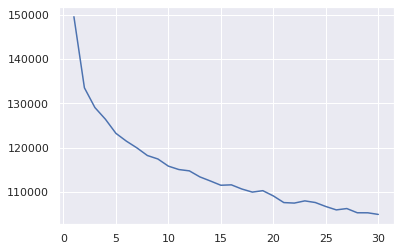

In [ ]:
# KModes
from kmodes.kmodes import KModes

undersample = RandomUnderSampler(sampling_strategy = 'not minority')
x_under, y_under = undersample.fit_resample(X, y_GD)


cost = []
for i in range(1,31):
  km = KModes(n_clusters = i, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2) # Instantiate model
  km.fit(x_under) # Fit model
  cost.append(km.cost_)

sb.lineplot(x = range(1,31), y = cost, estimator = None)

Best run was number 3


Clusters                                        0    1    2    3    4    5
Genetic Disorder                                                          
Mitochondrial genetic inheritance disorders   431  289  419  306  363  258
Multifactorial genetic inheritance disorders  596  405  183  353  184  345
Single-gene inheritance diseases              397  270  437  269  454  239

Clusters                                              0          1          2  \
Genetic Disorder                                                                
Mitochondrial genetic inheritance disorders   20.861568  13.988383  20.280736   
Multifactorial genetic inheritance disorders  28.848015  19.603098   8.857696   
Single-gene inheritance diseases              19.215876  13.068732  21.151985   

Clusters                                              3          4          5  
Genetic Disorder                                                               
Mitochondrial genetic inheritance disorders   14.811229  17.570184  12.487899  
Multifactorial genetic inheritance disorders  17.086157   8.906099  16.698935  
Single-gene inheritance diseases              13.020329  21.974831  11.568248

Text(0, 0.5, 'Proportion')

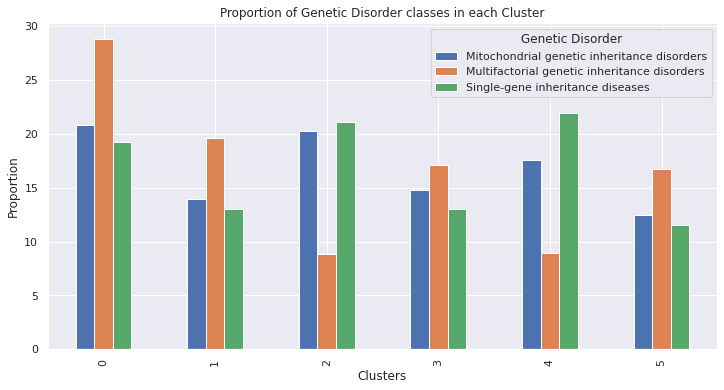

In [ ]:
km = KModes(n_clusters = 6, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2)  # Instantiate model

km.fit(x_under) # Fit model
clusters_X_under = km.predict(x_under)

temp = y_under
temp['Clusters'] = clusters_X_under
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack())
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1))
temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1).T.plot.bar(figsize = (12,6))
plt.title('Proportion of Genetic Disorder classes in each Cluster')
plt.ylabel('Proportion')

Oversampling

The minority classes, from Genetic Disorder or Genetic Subclass, were oversampled by picking samples at random with replacement. The sampling strategy was defaulted to use “not majority” which resample all classes but the majority class. One benefit of using this imbalance treatment would be avoiding the removal of important data points as done in undersampling. However, computational runtime was significantly increased. 


In [ ]:
## Oversampling
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Naive Bayes
# Oversampling based on Genetic Disorder statification

y_GD = data_drop_encoded[['Genetic Disorder']]

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.547924        0.539458          0.537438         0.528432
std           0.002621        0.005269          0.002923         0.007394
min           0.541308        0.527905          0.532128         0.514689
25%           0.546194        0.536798          0.535249         0.522726
50%           0.547897        0.538757          0.537126         0.528149
75%           0.549243        0.541735          0.539391         0.532188
max           0.553629        0.550261          0.543144         0.540140

In [ ]:
# Support Vector Machine
# Oversampling based on Genetic Disorder statification

from sklearn import svm

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler(sampling_strategy = 'not majority')
    X_over, y_over = oversample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo')  # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.675493        0.603476          0.595495         0.557153
std           0.001941        0.006045          0.002752         0.005990
min           0.670678        0.591221          0.589939         0.544878
25%           0.674381        0.600522          0.593754         0.551937
50%           0.675248        0.604520          0.595426         0.557197
75%           0.676890        0.607702          0.597130         0.562948
max           0.680388        0.612272          0.602383         0.565766

In [ ]:
# Random Forest
# Oversampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler(sampling_strategy = 'not majority')
    X_over, y_over = oversample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3)  # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.593282        0.587598          0.587925         0.572036
std           0.005750        0.009317          0.003563         0.006473
min           0.579984        0.565274          0.575783         0.558264
25%           0.590225        0.582001          0.586523         0.568782
50%           0.593897        0.589262          0.587920         0.571394
75%           0.597028        0.595015          0.590541         0.576005
max           0.603158        0.602154          0.593244         0.584208

In [ ]:
# Change depth of Random Forest
# Oversampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      oversample = RandomOverSampler(sampling_strategy = 'not majority')
      X_over, y_over = oversample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1)  # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())


Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.525869        0.524554          0.523913         0.525930
std           0.007096        0.007775          0.005142         0.007931
min           0.510342        0.510607          0.514341         0.515012
25%           0.520838        0.519501          0.519746         0.518441
50%           0.525397        0.523499          0.523744         0.525459
75%           0.530945        0.529945          0.527457         0.531253
max           0.538085        0.541939          0.532985         0.542266

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.565545        0.564475          0.561790         0.557131
std           0.006872        0.010830          0.003712         0.005762
min           0.547346        0.543734          0.554853         0.543572
25%           0.562278        0.555769          0.559636         0.552543
50%           0.565807        0.565519          0.561951         0.556300
75%           0.569561        0.571557          0.563308         0.561643
max           0.581249        0.589099          0.569010         0.570010

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.594602        0.589170          0.587567         0.570071
std           0.005155        0.007957          0.003271         0.005510
min           0.582269        0.568375          0.580310         0.557768
25%           0.591775        0.584367          0.585278         0.566458
50%           0.595100        0.589099          0.587287         0.569762
75%           0.597181        0.593260          0.590327         0.573067
max           0.603729        0.605091          0.595324         0.580615

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.608701        0.601567          0.600205         0.582697
std           0.004097        0.007907          0.003050         0.006558
min           0.601485        0.584693          0.593081         0.571478
25%           0.605065        0.595627          0.598925         0.577066
50%           0.608217        0.601664          0.600465         0.583794
75%           0.613041        0.606519          0.602036         0.587225
max           0.614663        0.624837          0.605973         0.597745

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.619273        0.607849          0.607729         0.584894
std           0.003107        0.006473          0.002362         0.006467
min           0.612297        0.594158          0.603280         0.575717
25%           0.617376        0.603908          0.606197         0.578656
50%           0.619049        0.608926          0.607564         0.585102
75%           0.621007        0.613047          0.609134         0.590936
max           0.625474        0.618473          0.613235         0.596279

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.633002        0.617319          0.614334         0.593048
std           0.002878        0.004831          0.001553         0.005394
min           0.625637        0.608355          0.610624         0.583876
25%           0.631400        0.613781          0.613541         0.589101
50%           0.632940        0.616841          0.614173         0.593505
75%           0.634633        0.621532          0.615326         0.595505
max           0.637877        0.625490          0.616703         0.603298

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.652593        0.624320          0.622662         0.596235
std           0.002838        0.005835          0.002463         0.006376
min           0.647016        0.613087          0.617559         0.583065
25%           0.650259        0.622226          0.620977         0.591876
50%           0.652646        0.623776          0.623088         0.596849
75%           0.654890        0.626591          0.624658         0.600478
max           0.658643        0.637239          0.626453         0.610639

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.689800        0.637582          0.636036         0.602622
std           0.003048        0.006610          0.001942         0.005919
min           0.682387        0.624510          0.630737         0.591058
25%           0.688885        0.632996          0.635317         0.598565
50%           0.690241        0.638463          0.636429         0.603052
75%           0.691465        0.641033          0.637387         0.605541
max           0.696177        0.655352          0.639549         0.614721

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.753587        0.662125          0.658243         0.612766
std           0.002561        0.005912          0.002142         0.005302
min           0.749623        0.648499          0.654114         0.602153
25%           0.751326        0.659391          0.657144         0.609579
50%           0.753519        0.661717          0.658663         0.612353
75%           0.755120        0.665552          0.659572         0.616717
max           0.759251        0.677056          0.662111         0.624512

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.835800        0.697193          0.689743         0.618130
std           0.003804        0.005407          0.002122         0.006534
min           0.829383        0.685379          0.686590         0.606233
25%           0.832657        0.695618          0.687804         0.614431
50%           0.835441        0.697944          0.689956         0.616676
75%           0.838521        0.700065          0.691455         0.621411
max           0.845620        0.706919          0.694015         0.635766

In [ ]:
# Change number of trees of Random Forest
# Oversampling based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_GD = data_drop_encoded[['Genetic Disorder']]

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      oversample = RandomOverSampler(sampling_strategy = 'not majority')
      X_over, y_over = oversample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 5, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.620104        0.610020          0.607130         0.586461
std           0.003059        0.005878          0.002458         0.005051
min           0.611032        0.598401          0.603484         0.574414
25%           0.618579        0.606234          0.605585         0.583222
50%           0.620375        0.609171          0.607095         0.586002
75%           0.622200        0.612761          0.608359         0.589101
max           0.625393        0.623858          0.613928         0.597751

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.623375        0.610547          0.611052         0.588779
std           0.002609        0.005177          0.002262         0.005252
min           0.618783        0.600196          0.606544         0.580126
25%           0.621252        0.608233          0.609950         0.584695
50%           0.623455        0.610966          0.610950         0.587875
75%           0.625240        0.614026          0.612449         0.592406
max           0.630370        0.619452          0.615356         0.601993

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.624593        0.612881          0.612180         0.589681
std           0.002545        0.005008          0.002226         0.005563
min           0.620252        0.601828          0.605647         0.573925
25%           0.622802        0.609416          0.611001         0.587793
50%           0.624230        0.613740          0.612113         0.589748
75%           0.627035        0.617289          0.614010         0.592200
max           0.629676        0.620920          0.615601         0.601668

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.625080        0.614306          0.612964         0.592107
std           0.002522        0.005170          0.001958         0.006167
min           0.617641        0.601338          0.609400         0.579961
25%           0.623822        0.611619          0.611705         0.588814
50%           0.625556        0.613577          0.612949         0.591873
75%           0.626708        0.617208          0.614153         0.594650
max           0.629309        0.624674          0.617029         0.605745

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.625291        0.616667          0.612922         0.593451
std           0.002214        0.005880          0.002170         0.005423
min           0.621639        0.606723          0.609278         0.583879
25%           0.623863        0.612353          0.611501         0.589956
50%           0.625331        0.616025          0.612480         0.593016
75%           0.626566        0.620390          0.614428         0.597587
max           0.631635        0.633812          0.617355         0.605417

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.624960        0.616346          0.613040         0.594141
std           0.002761        0.005522          0.001782         0.006652
min           0.617274        0.605907          0.608951         0.583388
25%           0.623842        0.612353          0.611756         0.587305
50%           0.624679        0.616433          0.613194         0.594565
75%           0.626576        0.620839          0.613837         0.598566
max           0.629799        0.626305          0.616458         0.610148

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.625561        0.615524          0.613284         0.594522
std           0.001754        0.005500          0.001709         0.006536
min           0.622047        0.607866          0.607809         0.580450
25%           0.624526        0.610803          0.612195         0.590730
50%           0.625964        0.615698          0.613459         0.594485
75%           0.626708        0.619289          0.614408         0.600360
max           0.628738        0.625653          0.616948         0.604926

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.625569        0.615095          0.613632         0.592374
std           0.002783        0.004473          0.001795         0.005883
min           0.620742        0.606560          0.610379         0.579468
25%           0.623353        0.612435          0.612408         0.590326
50%           0.625760        0.615046          0.613582         0.592196
75%           0.627198        0.617004          0.614948         0.596810
max           0.632655        0.627285          0.616784         0.605744

In [ ]:
# AdaBoost
# Oversampling based on Genetic Disorder statification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 2) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    oversample = RandomOverSampler(sampling_strategy = 'not majority')
    X_over, y_over = oversample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.588480        0.566319          0.560123         0.529962
std           0.002664        0.006170          0.002195         0.006574
min           0.583493        0.553851          0.555016         0.511423
25%           0.586696        0.561888          0.558668         0.527295
50%           0.587859        0.566824          0.560361         0.529371
75%           0.590092        0.571067          0.561381         0.534025
max           0.593937        0.576208          0.564685         0.541281

Best run was number 1
Best run was number 2
Best run was number 4
Best run was number 1
Best run was number 4
Best run was number 4
Best run was number 4
Best run was number 3
Best run was number 1
Best run was number 1
Best run was number 5
Best run was number 3
Best run was number 3
Best run was number 3
Best run was number 2
Best run was number 3
Best run was number 2
Best run was number 5
Best run was number 4
Best run was number 4
Best run was number 5
Best run was number 1
Best run was number 5
Best run was number 4
Best run was number 5
Best run was number 5
Best run was number 4
Best run was number 1
Best run was number 5
Best run was number 5


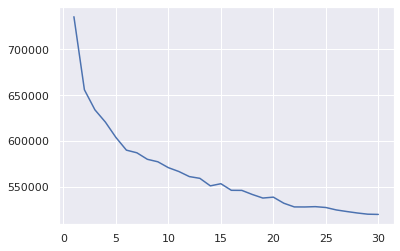

In [ ]:
# KModes
from kmodes.kmodes import KModes

oversample = RandomOverSampler(sampling_strategy = 'not majority')
X_over, y_over = oversample.fit_resample(X, y_GD)

cost = []
for i in range(1,31):
  km = KModes(n_clusters = i, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2) # Instantiate model
  km.fit(X_over) # Fit model
  cost.append(km.cost_)

sb.lineplot(x = range(1,31), y = cost, estimator = None)

Best run was number 4


Clusters                                         0     1     2     3     4  \
Genetic Disorder                                                             
Mitochondrial genetic inheritance disorders   2249  2318  1825  1497  1238   
Multifactorial genetic inheritance disorders  1479  1746  1369  2610  1917   
Single-gene inheritance diseases              2354  2297  1813  1476  1240   

Clusters                                         5  
Genetic Disorder                                    
Mitochondrial genetic inheritance disorders   1086  
Multifactorial genetic inheritance disorders  1092  
Single-gene inheritance diseases              1033

Clusters                                              0          1          2  \
Genetic Disorder                                                                
Mitochondrial genetic inheritance disorders   22.020954  22.696563  17.869382   
Multifactorial genetic inheritance disorders  14.481543  17.095858  13.404484   
Single-gene inheritance diseases              23.049055  22.490943  17.751885   

Clusters                                              3          4          5  
Genetic Disorder                                                               
Mitochondrial genetic inheritance disorders   14.657789  12.121806  10.633506  
Multifactorial genetic inheritance disorders  25.555664  18.770195  10.692255  
Single-gene inheritance diseases              14.452169  12.141388  10.114560

Text(0, 0.5, 'Proportion')

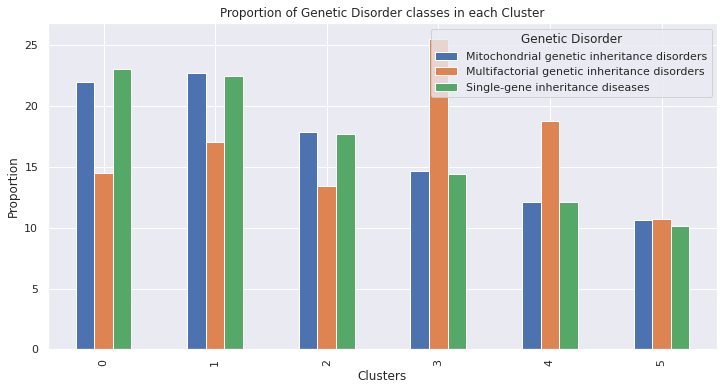

In [ ]:
km = KModes(n_clusters = 6, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2) # Instantiate model

km.fit(X_over) # Fit model
clusters_X_over = km.predict(X_over)

temp = y_over
temp['Clusters'] = clusters_X_over
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack())
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1))
temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1).T.plot.bar(figsize = (12,6))
plt.title('Proportion of Genetic Disorder classes in each Cluster')
plt.ylabel('Proportion')

SMOTE

Instead of oversampling minority class by duplication, SMOTE synthesize new examples from the minority class which are close in the feature space. This helps to provide additional information to the model. The sampling strategy was defaulted to use “not majority” which resample all classes but the majority class. This method was found to be the best imbalance treatment method amongst the ones tried.


In [ ]:
##SMOTE oversampling
from imblearn.over_sampling import SMOTE

In [ ]:
# Naive Bayes
# SMOTE based on Genetic Disorder statification

y_GD = data_drop_encoded[['Genetic Disorder']]

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.618649        0.615182          0.611969         0.602111
std           0.002524        0.007168          0.002275         0.005887
min           0.611236        0.602807          0.607033         0.591224
25%           0.617182        0.609987          0.610879         0.598564
50%           0.618620        0.617086          0.612133         0.601424
75%           0.620252        0.620798          0.613418         0.606234
max           0.622578        0.625326          0.615601         0.614067

In [ ]:
# Support Vector Machine
# SMOTE based on Genetic Disorder statification

from sklearn import svm

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo')  # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_svm, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_svm, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.716231        0.647824          0.639778         0.594778
std           0.001831        0.008413          0.002533         0.007680
min           0.712700        0.631201          0.634858         0.581594
25%           0.715128        0.644419          0.638550         0.590322
50%           0.716127        0.647928          0.639672         0.593832
75%           0.717035        0.651844          0.640835         0.599378
max           0.721064        0.670039          0.646322         0.616999

In [ ]:
# Random Forest
# SMOTE based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3) # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.651123        0.647726          0.649008         0.641026
std           0.003643        0.005246          0.002158         0.007167
min           0.644690        0.635281          0.643874         0.623372
25%           0.649616        0.645153          0.647842         0.636136
50%           0.651707        0.648254          0.648627         0.642054
75%           0.653339        0.651110          0.650310         0.647440
max           0.659500        0.656821          0.653543         0.651603

In [ ]:
# AdaBoost
# SMOTE based on Genetic Disorder statification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

model = DecisionTreeClassifier(max_depth = 2) # Choose Decision Tree as weak model
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X, y_GD)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    ada_tree = AdaBoostClassifier(base_estimator = model, n_estimators = 150, learning_rate = 1) # Instantiate model
    ada_tree.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(ada_tree.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(ada_tree.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(ada_tree, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(ada_tree, X_test, y_test_main, cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())



Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.635311        0.616329          0.618963         0.599152
std           0.022886        0.021980          0.007963         0.007937
min           0.575130        0.558257          0.601403         0.583715
25%           0.622037        0.606193          0.614908         0.594279
50%           0.642589        0.624755          0.619191         0.598889
75%           0.652809        0.632058          0.625444         0.605009
max           0.657786        0.638381          0.631268         0.613737

Best run was number 1
Best run was number 1
Best run was number 4
Best run was number 5
Best run was number 1
Best run was number 3
Best run was number 4
Best run was number 5
Best run was number 5
Best run was number 2
Best run was number 1
Best run was number 4
Best run was number 5
Best run was number 1
Best run was number 4
Best run was number 3
Best run was number 2
Best run was number 4
Best run was number 2
Best run was number 5
Best run was number 1
Best run was number 5
Best run was number 2
Best run was number 1
Best run was number 5
Best run was number 3
Best run was number 4
Best run was number 2
Best run was number 3
Best run was number 2


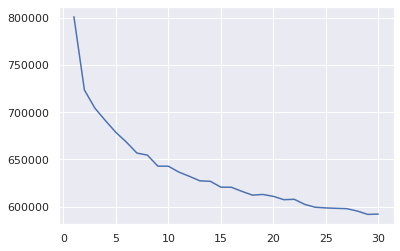

In [ ]:
# KModes
from kmodes.kmodes import KModes

smote_sample = SMOTE()
X_over, y_over = smote_sample.fit_resample(X, y_GD)

cost = []
for i in range(1,31):
  km = KModes(n_clusters = i, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2)  # Instantiate model
  km.fit(X_over) # Fit model
  cost.append(km.cost_)

sb.lineplot(x = range(1,31), y = cost, estimator = None)


Best run was number 1


Clusters                                         0     1     2     3     4  \
Genetic Disorder                                                             
Mitochondrial genetic inheritance disorders   1720  2528  1821  1121  1334   
Multifactorial genetic inheritance disorders  2109  2628  1737  1260  1860   
Single-gene inheritance diseases              1609  2555  1821  1065  1325   

Clusters                                         5  
Genetic Disorder                                    
Mitochondrial genetic inheritance disorders   1689  
Multifactorial genetic inheritance disorders   619  
Single-gene inheritance diseases              1838

Clusters                                              0          1          2  \
Genetic Disorder                                                                
Mitochondrial genetic inheritance disorders   16.841281  24.752766  17.830216   
Multifactorial genetic inheritance disorders  20.650152  25.731910  17.007735   
Single-gene inheritance diseases              15.754431  25.017135  17.830216   

Clusters                                              3          4          5  
Genetic Disorder                                                               
Mitochondrial genetic inheritance disorders   10.976207  13.061784  16.537746  
Multifactorial genetic inheritance disorders  12.337217  18.212083   6.060903  
Single-gene inheritance diseases              10.427886  12.973661  17.996671

Text(0, 0.5, 'Proportion')

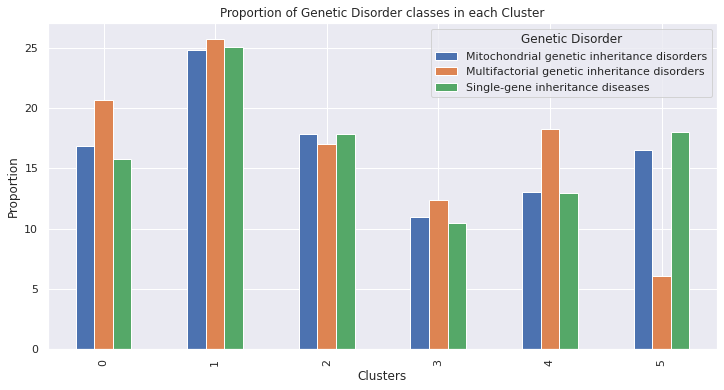

In [ ]:
km = KModes(n_clusters = 6, init = 'random', n_init = 5, verbose = 1, n_jobs  = 2) # Instantiate model

km.fit(X_over) # Fit model
clusters_X_over = km.predict(X_over)


temp = y_over
temp['Clusters'] = clusters_X_over
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack())
display(temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1))
temp.groupby(['Genetic Disorder', 'Clusters']).size().unstack().apply(lambda x: x*100/sum(x),axis = 1).T.plot.bar(figsize = (12,6))
plt.title('Proportion of Genetic Disorder classes in each Cluster')
plt.ylabel('Proportion')


Comparison of imbalance treatment methods

Class imbalance was noticeable in both Genetic Disorder and Disorder Subclass. Various methods of imbalance treatment were used and the results were compared to identify the best imbalance treatment for this dataset. The performance of imbalance treatment decreases in the following order: SMOTE > Oversampling > Undersampling > Imbalance.



Text(0, 0.5, 'Mean Accuracy')

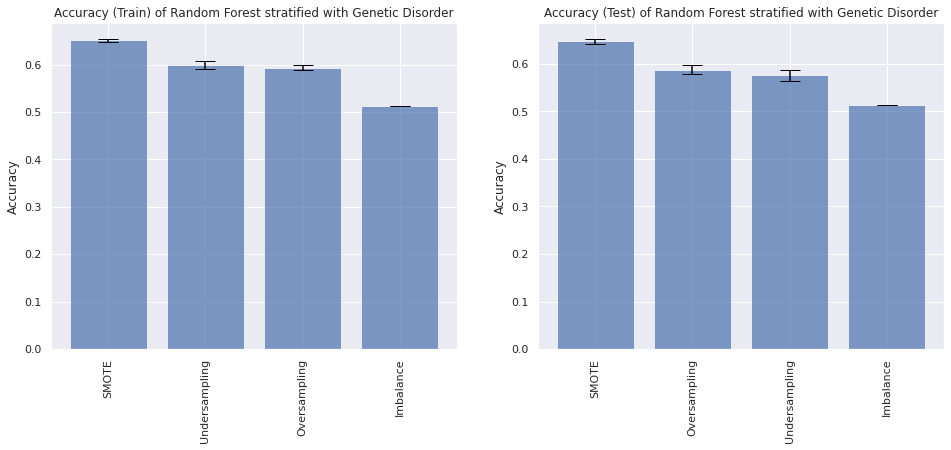

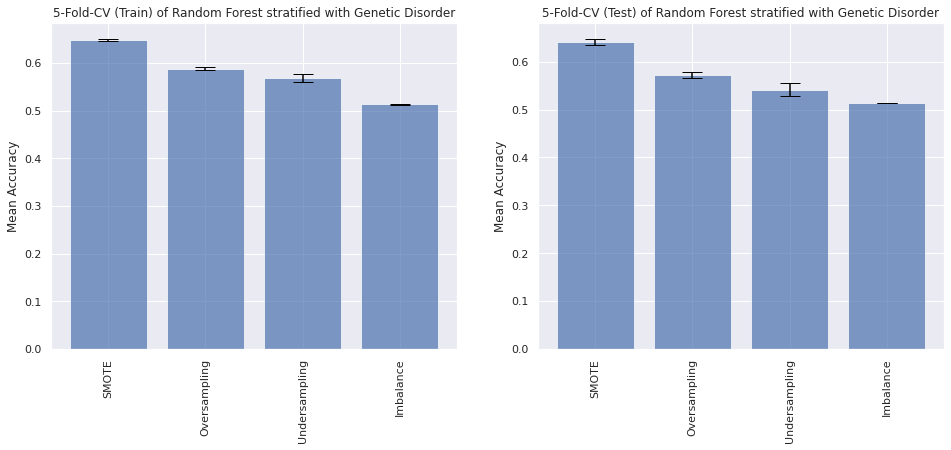

In [ ]:
# Identifying best method to deal with imbalanced class across all models

# Manual keying of values due to long runtime for generating a model and colab shuts off before runtime ends
f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(['SMOTE', 'Undersampling', 'Oversampling', 'Imbalance'], [0.651123,0.598467, 0.593282, 0.5128044],yerr=[0.003643,0.00874,0.005750,2.2588405/(10**16)],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Accuracy (Train) of Random Forest stratified with Genetic Disorder')
ax[0].set_ylabel('Accuracy')

ax[1].bar(['SMOTE', 'Oversampling', 'Undersampling', 'Imbalance'], [0.647726,0.587598,0.575914,0.51293],yerr=[0.005246,0.009317,0.011844,2.258405/(10**16)],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Accuracy (Test) of Random Forest stratified with Genetic Disorder')
ax[1].set_ylabel('Accuracy')

f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(['SMOTE', 'Oversampling', 'Undersampling', 'Imbalance'], [0.649008,0.587925,0.568684,0.51293],yerr=[0.002158,0.003563,0.008015,0.000023],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('5-Fold-CV (Train) of Random Forest stratified with Genetic Disorder')
ax[0].set_ylabel('Mean Accuracy')

ax[1].bar(['SMOTE', 'Oversampling', 'Undersampling', 'Imbalance'], [0.641026,0.572036,0.541317,0.512989],yerr=[0.007167,0.006473,0.013151,0.000215],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('5-Fold-CV (Test) of Random Forest stratified with Genetic Disorder')
ax[1].set_ylabel('Mean Accuracy')

# SMOTE seems to be the best method to deal with class imbalance with all accuracies higher for all models when using SMOTE

Supervised Learning Model Performance Comparison - SMOTE and Stratified against Genetic Disorder

Although the Support Vector Machine had the highest accuracy for train and test set, it was overfitted. Random Forest on the other hand, performed relatively consistently throughout for accuracy and cross validation results. Thus, Random Forest was decided to be the final model  for Genetic Disorder model and Disorder Subclass models. AdaBoost was performing better than Naive Bayes most of the time but was not chosen due to poorer results when compared to Random Forest.

Text(0, 0.5, 'Mean Accuracy')

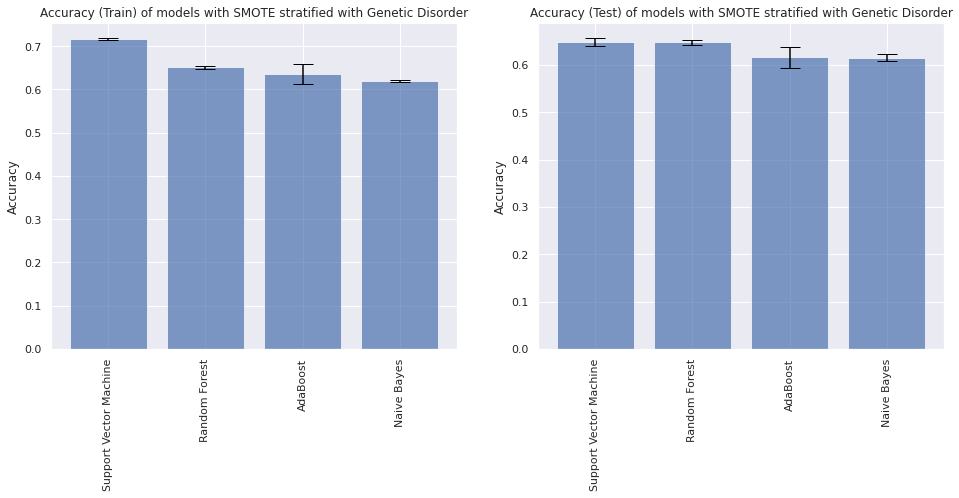

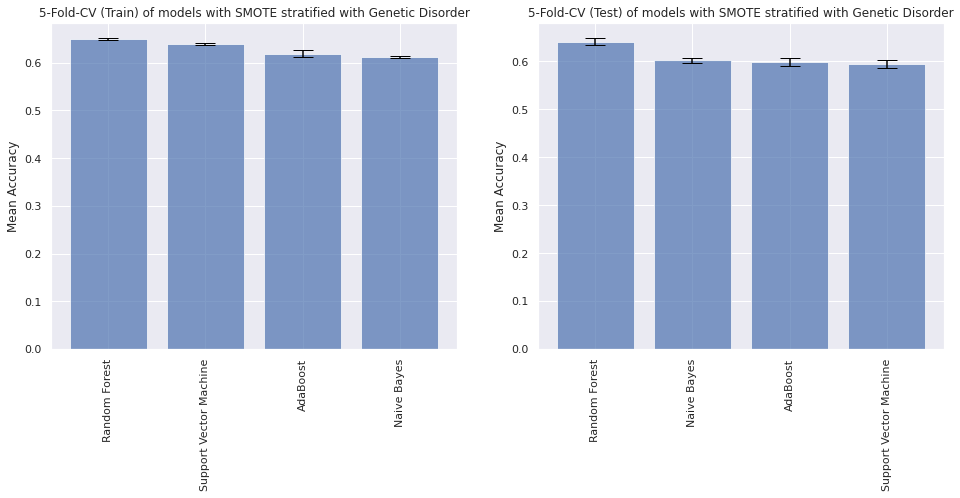

In [ ]:
# Compare different model performance

# Manual keying of values due to long runtime for generating a model and colab shuts off before runtime ends
f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(['Support Vector Machine', 'Random Forest', 'AdaBoost', 'Naive Bayes'], [0.716231,0.651123,0.635311,0.618648],yerr=[0.001831,0.003643,0.022886,0.002524],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Accuracy (Train) of models with SMOTE stratified with Genetic Disorder')
ax[0].set_ylabel('Accuracy')

ax[1].bar(['Support Vector Machine', 'Random Forest', 'AdaBoost', 'Naive Bayes'], [0.647824,0.647726,0.616329,0.615182],yerr=[0.008413,0.005246,0.02198,0.007168],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Accuracy (Test) of models with SMOTE stratified with Genetic Disorder')
ax[1].set_ylabel('Accuracy')

f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(['Random Forest', 'Support Vector Machine', 'AdaBoost', 'Naive Bayes'], [0.649008,0.639778,0.618963,0.611969],yerr=[0.002158,0.002533,0.007963,0.002275],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('5-Fold-CV (Train) of models with SMOTE stratified with Genetic Disorder')
ax[0].set_ylabel('Mean Accuracy')

ax[1].bar(['Random Forest', 'Naive Bayes', 'AdaBoost', 'Support Vector Machine'], [0.641026,0.602111,0.599152,0.594778],yerr=[0.007167,0.005887,0.007937,0.00768],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('5-Fold-CV (Test) of models with SMOTE stratified with Genetic Disorder')
ax[1].set_ylabel('Mean Accuracy')

# Random Forest seems to be the best model due as it is highest in most accuracies

Random Forest Model Performance Comparison after SMOTE - Stratified against Genetic Disorder and Disorder Subclass

In the creation of the Genetic Disorder model, stratification against Genetic Disorder during train test split showed better performance than stratification against Disorder Subclass. As the numbers of Alzheimer’s and Cancer cases are extremely small compared to total number of observations, stratification against Disorder Subclass was done to avoid excluding these data points from the train or test sets for both main and submodels (to keep same train and test set for all models). If prediction of Genetic Disorder classes was the only problem, then stratification against Genetic Disorder would give much better results.


Text(0.5, 1.0, 'Train and Test set Accuracy after stratification against Genetic Disorder and Disorder Subclass')

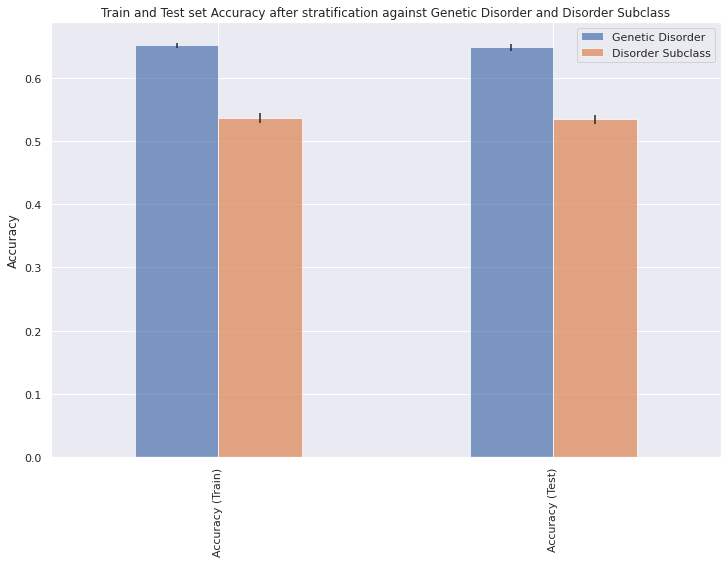

In [ ]:
# Comparing effect of stratification against Genetic Disorder and Disorder Subclass using Random Forest

f, ax = plt.subplots(1,1,figsize=(12,8))
strat = pd.DataFrame({'Genetic Disorder':[0.651123,0.647726],
                      'Disorder Subclass':[0.536099,0.533961],
                      'std_GD':[0.003643,0.005246],
                      'std_DS':[0.007808,0.007643]
                      }, index = ['Accuracy (Train)','Accuracy (Test)'])
yerr = strat[['std_GD', 'std_DS']].to_numpy().T
strat[['Genetic Disorder','Disorder Subclass']].plot.bar(ax = ax,yerr = yerr, alpha=0.7)
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test set Accuracy after stratification against Genetic Disorder and Disorder Subclass')

# Stratifying against Genetic Disorder yielded higher accuracies
# Final model stratified against Disorder Subclass due to Disorder Subclass models should not stratify against Genetic Disorder as we wanted to keep same training and test set for all models
# If only interested in prediction of Genetic Disorder then statifying against Genetic Disorder is the best

Text(0.5, 1.0, 'Train and Test set Mean Accuracy of 5-fold CV \nafter stratification against Genetic Disorder and Disorder Subclass')

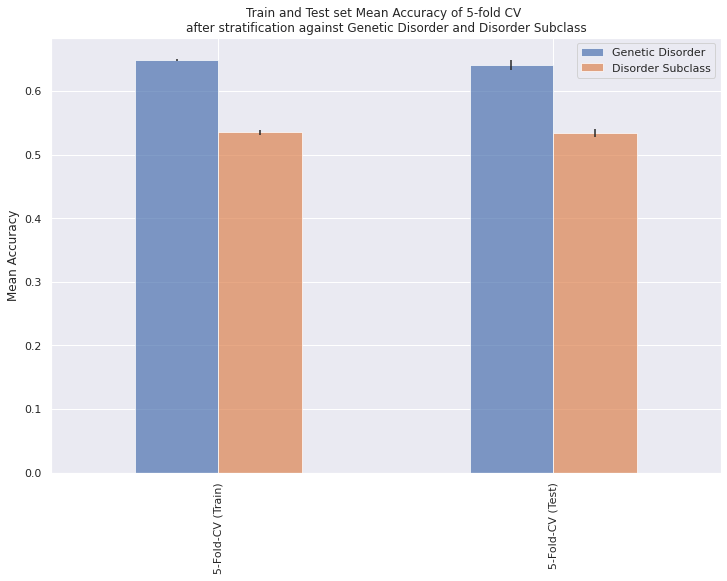

In [ ]:
# Comparing effect of stratification against Genetic Disorder and Disorder Subclass using Random Forest

f, ax = plt.subplots(1,1,figsize=(12,8))
strat = pd.DataFrame({'Genetic Disorder':[0.649008,0.641026],
                      'Disorder Subclass':[0.534877,0.533614],
                      'std_GD':[0.002158,0.007167],
                      'std_DS':[0.004655,0.006263]
                      }, index = ['5-Fold-CV (Train)','5-Fold-CV (Test)'])
yerr = strat[['std_GD', 'std_DS']].to_numpy().T
strat[['Genetic Disorder','Disorder Subclass']].plot.bar(ax = ax,yerr = yerr, alpha=0.7)
ax.set_ylabel('Mean Accuracy')
ax.set_title('Train and Test set Mean Accuracy of 5-fold CV \nafter stratification against Genetic Disorder and Disorder Subclass')

# Stratifying against Genetic Disorder yielded higher mean accuracies
# Final model stratified against Disorder Subclass due to Disorder Subclass models should not stratify against Genetic Disorder as we wanted to keep same training and test set for all models
# If only interested in prediction of Genetic Disorder then statifying against Genetic Disorder is the best

# Final Model

In [ ]:
# Change depth of Random Forest
# SMOTE based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.576755        0.575789          0.574821         0.565203
std           0.005724        0.006046          0.003345         0.006533
min           0.559504        0.565111          0.567867         0.553358
25%           0.572886        0.570659          0.573038         0.559522
50%           0.577985        0.576616          0.575211         0.565682
75%           0.581096        0.581348          0.577118         0.570212
max           0.584472        0.587304          0.581738         0.576695

Tree depth : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.624222        0.622835          0.622047         0.616521
std           0.006845        0.008218          0.003909         0.007359
min           0.612541        0.607050          0.615112         0.598727
25%           0.619202        0.618024          0.620303         0.613576
50%           0.623965        0.623450          0.621721         0.617826
75%           0.628381        0.628305          0.624270         0.621777
max           0.638530        0.642787          0.630900         0.628591

Tree depth : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.651629        0.650087          0.649307         0.643777
std           0.004450        0.006104          0.003686         0.006061
min           0.641304        0.638218          0.641467         0.632343
25%           0.648648        0.645072          0.647168         0.639441
50%           0.651401        0.651110          0.649749         0.644176
75%           0.654737        0.655148          0.651666         0.648129
max           0.658806        0.661717          0.658398         0.657309

Tree depth : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.662896        0.659606          0.659649         0.653982
std           0.002649        0.005077          0.002427         0.004565
min           0.653788        0.650294          0.654196         0.647685
25%           0.661550        0.656087          0.658357         0.650866
50%           0.663376        0.658861          0.659684         0.653393
75%           0.664334        0.664124          0.661887         0.655924
max           0.667251        0.668897          0.662927         0.663023

Tree depth : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.671246        0.665704          0.665518         0.658273
std           0.001778        0.004834          0.002207         0.004534
min           0.666639        0.656005          0.660642         0.646705
25%           0.670291        0.663553          0.663937         0.656374
50%           0.671148        0.666694          0.665640         0.658287
75%           0.672576        0.668570          0.667190         0.661307
max           0.674962        0.674119          0.669577         0.666612

Tree depth : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.679343        0.668957          0.669654         0.660972
std           0.002176        0.005340          0.001595         0.005273
min           0.675207        0.657474          0.666721         0.648827
25%           0.677788        0.664858          0.668496         0.658006
50%           0.679470        0.669060          0.669577         0.661228
75%           0.681021        0.673915          0.670739         0.663961
max           0.683081        0.678198          0.672392         0.672975

Tree depth : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.691154        0.673983          0.673261         0.662854
std           0.002207        0.005199          0.002099         0.004715
min           0.687120        0.667265          0.667986         0.653228
25%           0.689507        0.670570          0.672270         0.659474
50%           0.691343        0.672487          0.673555         0.662695
75%           0.692740        0.679014          0.674513         0.666247
max           0.695280        0.686521          0.676758         0.672647

Tree depth : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.710652        0.677502          0.678442         0.662505
std           0.002114        0.004263          0.001696         0.005428
min           0.705275        0.670529          0.675982         0.651598
25%           0.709834        0.674160          0.677288         0.659474
50%           0.710885        0.679014          0.678532         0.662043
75%           0.711762        0.681095          0.679685         0.666243
max           0.714944        0.683747          0.682184         0.672488

Tree depth : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.743463        0.684851          0.682194         0.664159
std           0.001978        0.004558          0.001809         0.004671
min           0.737669        0.673303          0.677696         0.655677
25%           0.742034        0.681503          0.681551         0.661348
50%           0.743890        0.684971          0.682326         0.663597
75%           0.744808        0.688602          0.683540         0.667634
max           0.745910        0.691416          0.685202         0.673306

Tree depth : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.793346        0.689975          0.688230         0.661059
std           0.002829        0.004239          0.002118         0.005744
min           0.786300        0.680809          0.683407         0.647516
25%           0.791685        0.687133          0.687334         0.658777
50%           0.793664        0.690764          0.688201         0.660494
75%           0.794694        0.693783          0.689629         0.664327
max           0.799396        0.697128          0.692383         0.675753

In [ ]:
# Change number of trees of Random Forest
# SMOTE based on Genetic Disorder statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_GD = data_drop_encoded[['Genetic Disorder']]

for num_tree in range(100,801,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X, y_GD)
      X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Genetic Disorder']) # Train test split stratified by Genetic Disorder
      y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
      y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 4, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.663877        0.658622          0.660263         0.652312
std           0.002853        0.004833          0.002568         0.006647
min           0.658153        0.649804          0.653014         0.635931
25%           0.661785        0.655026          0.658388         0.647237
50%           0.664436        0.657148          0.660601         0.652169
75%           0.666038        0.662655          0.662101         0.655558
max           0.668761        0.669060          0.663906         0.664979

Number of Trees : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.664540        0.660504          0.661644         0.656195
std           0.002383        0.003959          0.002276         0.005401
min           0.657542        0.653557          0.657705         0.648990
25%           0.663263        0.657800          0.659632         0.652578
50%           0.664090        0.660330          0.661030         0.654863
75%           0.666303        0.663022          0.663896         0.658207
max           0.668231        0.667591          0.666109         0.671180

Number of Trees : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.664564        0.660515          0.661348         0.655919
std           0.002626        0.004788          0.002159         0.005653
min           0.658643        0.650620          0.656889         0.648499
25%           0.663427        0.657107          0.659663         0.651153
50%           0.664416        0.660656          0.661234         0.655108
75%           0.666415        0.663593          0.662672         0.659677
max           0.669577        0.670855          0.665416         0.670043

Number of Trees : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.665307        0.661004          0.661749         0.655695
std           0.002474        0.004027          0.002314         0.005802
min           0.661377        0.651273          0.657990         0.644417
25%           0.664283        0.658616          0.660051         0.650744
50%           0.665089        0.661390          0.661173         0.656086
75%           0.666140        0.664532          0.663274         0.659882
max           0.670556        0.666123          0.667741         0.666450

Number of Trees : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.665576        0.662092          0.662115         0.658148
std           0.002653        0.004603          0.002400         0.004808
min           0.661213        0.652415          0.659051         0.650130
25%           0.663702        0.660166          0.660336         0.655352
50%           0.664783        0.661961          0.661927         0.657718
75%           0.667823        0.664613          0.663865         0.660124
max           0.670515        0.670855          0.667782         0.668901

Number of Trees : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.664378        0.661439          0.661254         0.657234
std           0.002063        0.004414          0.002073         0.005785
min           0.660969        0.652415          0.656236         0.643115
25%           0.662723        0.658086          0.659887         0.654087
50%           0.664375        0.662206          0.661397         0.658289
75%           0.665997        0.664287          0.662641         0.660003
max           0.668312        0.671508          0.666477         0.669550

Number of Trees : 700


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.665183        0.662190          0.661914         0.658399
std           0.002098        0.004479          0.001829         0.005114
min           0.660234        0.650457          0.657256         0.649970
25%           0.663947        0.659473          0.661060         0.654250
50%           0.664987        0.662125          0.661703         0.657637
75%           0.666425        0.664613          0.662988         0.662166
max           0.668924        0.672161          0.666680         0.669717

Number of Trees : 800


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.664842        0.661124          0.661938         0.656762
std           0.002271        0.005308          0.002467         0.006613
min           0.660357        0.652742          0.657174         0.647030
25%           0.663467        0.657433          0.660224         0.651887
50%           0.664579        0.661146          0.661968         0.655433
75%           0.666262        0.666408          0.663447         0.661921
max           0.671168        0.669876          0.668067         0.673632

In [ ]:
# Max depth for SG
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  SG_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
    y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
    X_train_SG = X_train_SC.loc[y_train_SG.index]
    X_test_SG = X_test_SC.loc[y_test_SG.index]
    randfor_SG = RandomForestClassifier(n_estimators = 200, max_depth = max_depth) # Instantiate model
    randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
    SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
    SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG)) # Test set accuracy
    SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
    SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(SG_scores).describe())

Depth of tree : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.654247        0.650334          0.644413         0.646583
std           0.005123        0.006954          0.004381         0.006828
min           0.646883        0.639858          0.637110         0.630833
25%           0.650941        0.645430          0.641007         0.642943
50%           0.653626        0.648902          0.644056         0.647468
75%           0.656109        0.653747          0.647588         0.649491
max           0.667232        0.666990          0.651646         0.657961

Depth of tree : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.680133        0.672427          0.666616         0.673364
std           0.004072        0.007275          0.004143         0.008176
min           0.672642        0.655362          0.659397         0.657323
25%           0.676962        0.666990          0.663698         0.667973
50%           0.680071        0.671835          0.666584         0.674923
75%           0.682716        0.677649          0.669490         0.678396
max           0.688227        0.687984          0.673769         0.691886

Depth of tree : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.704667        0.691031          0.687753         0.699648
std           0.004038        0.005756          0.002780         0.008911
min           0.695575        0.679264          0.681603         0.682839
25%           0.701894        0.686854          0.685115         0.692609
50%           0.704336        0.691376          0.688183         0.697702
75%           0.706718        0.694364          0.689535         0.706903
max           0.712452        0.700581          0.692423         0.719659

Depth of tree : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.727277        0.708452          0.704783         0.726220
std           0.003671        0.006431          0.003407         0.009160
min           0.721657        0.696705          0.697107         0.698993
25%           0.724241        0.703165          0.702617         0.721282
50%           0.726542        0.708333          0.704697         0.727416
75%           0.730378        0.713421          0.707038         0.731449
max           0.735707        0.719315          0.712772         0.741303

Depth of tree : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.751241        0.721490          0.721511         0.750727
std           0.003376        0.008320          0.002668         0.005410
min           0.744428        0.703165          0.716567         0.740984
25%           0.749092        0.716651          0.719999         0.747365
50%           0.750888        0.721092          0.721129         0.750514
75%           0.753008        0.728359          0.722966         0.753498
max           0.759609        0.736434          0.729487         0.764557

Depth of tree : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.778895        0.732569          0.738245         0.778712
std           0.003154        0.008229          0.003193         0.006293
min           0.773821        0.711563          0.732071         0.764248
25%           0.776627        0.726583          0.736148         0.774732
50%           0.779312        0.733366          0.737764         0.779583
75%           0.780483        0.737645          0.739640         0.782329
max           0.787791        0.748062          0.746525         0.792023

Depth of tree : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.811108        0.734636          0.754853         0.804921
std           0.002710        0.008301          0.002875         0.007427
min           0.805475        0.716085          0.747333         0.786861
25%           0.809371        0.730055          0.752702         0.798967
50%           0.810966        0.736111          0.755569         0.805913
75%           0.812641        0.740149          0.756962         0.809460
max           0.816295        0.753876          0.758799         0.819145

Depth of tree : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.850493        0.740730          0.772643         0.827736
std           0.003057        0.008499          0.002588         0.005520
min           0.845123        0.718023          0.767925         0.814634
25%           0.848272        0.734335          0.770791         0.824814
50%           0.850008        0.742410          0.772971         0.827553
75%           0.852834        0.746366          0.775010         0.831095
max           0.857316        0.754845          0.776645         0.836601

Depth of tree : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.892043        0.741785          0.790408         0.846946
std           0.003009        0.007817          0.002321         0.007075
min           0.884851        0.726098          0.786255         0.826909
25%           0.889878        0.736273          0.789101         0.844512
50%           0.891917        0.741279          0.790131         0.847899
75%           0.894824        0.747012          0.791989         0.850972
max           0.896883        0.756460          0.795057         0.861142

Depth of tree : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.934547        0.741473          0.808287         0.861254
std           0.002113        0.010273          0.002496         0.006412
min           0.931363        0.723837          0.803212         0.848232
25%           0.932917        0.735304          0.807028         0.857834
50%           0.934472        0.740310          0.807816         0.862109
75%           0.935905        0.749031          0.810096         0.864698
max           0.939357        0.763243          0.812419         0.879553

In [ ]:
# Number of tree for SG
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  SG_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
    y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
    X_train_SG = X_train_SC.loc[y_train_SG.index]
    X_test_SG = X_test_SC.loc[y_test_SG.index]
    randfor_SG = RandomForestClassifier(n_estimators = num_tree, max_depth = 3) # Instantiate model
    randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
    SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
    SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG)) # Test set accuracy
    SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
    SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(SG_scores).describe())

Number of tree : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.704002        0.692474          0.686698         0.700239
std           0.006279        0.007480          0.004329         0.008318
min           0.691941        0.678295          0.676758         0.681546
25%           0.699673        0.687823          0.684874         0.696407
50%           0.703448        0.692668          0.686851         0.701413
75%           0.707183        0.698240          0.690021         0.704970
max           0.717216        0.708656          0.694118         0.715788

Number of tree : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.706778        0.695306          0.689419         0.700293
std           0.003174        0.006811          0.004092         0.008805
min           0.700339        0.675388          0.682248         0.683483
25%           0.704558        0.691860          0.686872         0.695521
50%           0.706274        0.695413          0.689193         0.699802
75%           0.708515        0.700501          0.692100         0.707069
max           0.714470        0.708010          0.697914         0.716116

Number of tree : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.708764        0.696479          0.691088         0.703240
std           0.002719        0.005322          0.003331         0.008204
min           0.704054        0.685724          0.683379         0.686715
25%           0.707122        0.691618          0.689314         0.698665
50%           0.708333        0.698643          0.690969         0.702860
75%           0.710978        0.699855          0.692847         0.707704
max           0.713744        0.705749          0.698237         0.720947

Number of tree : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.707808        0.697341          0.690735         0.703188
std           0.003972        0.007922          0.002813         0.009070
min           0.701147        0.672804          0.683541         0.680902
25%           0.704619        0.691295          0.689334         0.696088
50%           0.707526        0.697997          0.691050         0.703996
75%           0.711382        0.703650          0.692079         0.707875
max           0.715359        0.709625          0.697995         0.721598

Number of tree : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.708586        0.693529          0.691403         0.699720
std           0.003068        0.007920          0.003346         0.008955
min           0.703246        0.680556          0.684268         0.679936
25%           0.706436        0.688307          0.689718         0.693663
50%           0.708333        0.691860          0.691171         0.700115
75%           0.710110        0.697917          0.692787         0.707304
max           0.717700        0.709302          0.699045         0.715459

Number of tree : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.708344        0.694994          0.691039         0.701650
std           0.003087        0.007793          0.002673         0.006945
min           0.701631        0.676357          0.683781         0.687689
25%           0.705749        0.689680          0.689455         0.696731
50%           0.708535        0.696221          0.691777         0.702219
75%           0.710292        0.699855          0.692605         0.704482
max           0.713582        0.708333          0.696542         0.720313

In [ ]:
# Max depth for MF
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  MF_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}


  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)

    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
    y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
    X_train_MF = X_train_SC.loc[y_train_MF.index]
    X_test_MF = X_test_SC.loc[y_test_MF.index]
    randfor_MF = RandomForestClassifier(n_estimators = 200, max_depth = max_depth) # Instantiate model
    randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
    MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
    MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF))  # Test set accuracy
    MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean())  # Train set 5-fold cross-validation
    MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(MF_scores).describe())

Depth of tree : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.710977        0.704307          0.709859         0.732445
std           0.010205        0.012758          0.008162         0.019493
min           0.690568        0.675388          0.697270         0.700264
25%           0.704336        0.697190          0.704053         0.715438
50%           0.712209        0.705588          0.709423         0.736101
75%           0.718831        0.711321          0.713642         0.745726
max           0.731185        0.738695          0.732719         0.771298

Depth of tree : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.841995        0.819520          0.834957         0.881695
std           0.009941        0.018705          0.007838         0.019305
min           0.817991        0.776809          0.818312         0.837200
25%           0.838663        0.809997          0.829233         0.867311
50%           0.841691        0.822513          0.833775         0.883387
75%           0.849302        0.829377          0.841062         0.892267
max           0.861434        0.854005          0.850045         0.918273

Depth of tree : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.879936        0.837242          0.872751         0.927266
std           0.009796        0.030419          0.008717         0.012700
min           0.862322        0.775840          0.855698         0.895985
25%           0.873224        0.818879          0.867608         0.918274
50%           0.881662        0.838663          0.874674         0.926350
75%           0.887274        0.855943          0.877199         0.934427
max           0.900598        0.902132          0.890664         0.949608

Depth of tree : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.903787        0.844283          0.894163         0.948554
std           0.007665        0.027452          0.006882         0.010840
min           0.889616        0.774871          0.879117         0.930546
25%           0.897892        0.828811          0.888565         0.941049
50%           0.904110        0.839955          0.894056         0.947188
75%           0.909339        0.860384          0.899143         0.953726
max           0.916909        0.902778          0.905844         0.975131

Depth of tree : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.926564        0.863803          0.915287         0.971856
std           0.006182        0.029637          0.007378         0.006666
min           0.914002        0.814276          0.896721         0.953164
25%           0.921956        0.834383          0.910387         0.969074
50%           0.926114        0.869671          0.915334         0.971899
75%           0.929163        0.890342          0.918927         0.976018
max           0.940811        0.918605          0.930151         0.986113

Depth of tree : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.953130        0.857041          0.940613         0.976723
std           0.004567        0.031720          0.004007         0.005708
min           0.942668        0.788114          0.931847         0.958331
25%           0.951026        0.832687          0.938246         0.973919
50%           0.954054        0.866279          0.940285         0.977874
75%           0.955325        0.882348          0.943394         0.980220
max           0.962048        0.902778          0.950985         0.984821

Depth of tree : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.968637        0.864320          0.956833         0.985123
std           0.003489        0.032497          0.004549         0.005496
min           0.961160        0.801680          0.946624         0.966733
25%           0.966368        0.837290          0.954779         0.983530
50%           0.968467        0.867087          0.956758         0.986921
75%           0.971334        0.890908          0.959847         0.988857
max           0.976260        0.923450          0.964550         0.991928

Depth of tree : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.977140        0.854027          0.966548         0.989322
std           0.002774        0.030207          0.003320         0.003755
min           0.971657        0.777132          0.958979         0.979652
25%           0.976118        0.845123          0.964288         0.986841
50%           0.977713        0.854974          0.967216         0.990152
75%           0.978985        0.868056          0.968810         0.991929
max           0.980943        0.914729          0.972303         0.995157

Depth of tree : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.983460        0.854479          0.973605         0.990744
std           0.001860        0.033857          0.002570         0.003048
min           0.979570        0.782946          0.967862         0.979652
25%           0.982175        0.819687          0.972404         0.989668
50%           0.983164        0.864987          0.973958         0.991444
75%           0.984859        0.877019          0.974907         0.992494
max           0.987242        0.906654          0.978359         0.995159

Depth of tree : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.990046        0.839750          0.979231         0.993275
std           0.001959        0.032558          0.002651         0.001926
min           0.985223        0.780362          0.973433         0.989346
25%           0.989018        0.820090          0.977006         0.991929
50%           0.990149        0.840278          0.978803         0.993545
75%           0.991360        0.861596          0.981367         0.994835
max           0.993863        0.910207          0.984093         0.996449

In [ ]:
# Number of tree for MF
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  MF_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
    y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
    X_train_MF = X_train_SC.loc[y_train_MF.index]
    X_test_MF = X_test_SC.loc[y_test_MF.index]
    randfor_MF = RandomForestClassifier(n_estimators = num_tree, max_depth = 4) # Instantiate model
    randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
    MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
    MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
    MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
    MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(MF_scores).describe())

Number of tree : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.877433        0.843572          0.866657         0.924737
std           0.013294        0.030882          0.009678         0.016985
min           0.850452        0.773902          0.851096         0.896628
25%           0.868802        0.821705          0.861189         0.911573
50%           0.879764        0.850614          0.865026         0.923773
75%           0.886487        0.867490          0.875019         0.932653
max           0.910368        0.886951          0.885900         0.964469

Number of tree : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.876771        0.850818          0.868438         0.920655
std           0.013485        0.026643          0.010836         0.015779
min           0.848353        0.796512          0.846816         0.886610
25%           0.866380        0.828085          0.860665         0.911492
50%           0.878028        0.854167          0.866802         0.920698
75%           0.888061        0.868056          0.876533         0.929261
max           0.896722        0.902455          0.895428         0.960919

Number of tree : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.881358        0.847707          0.875372         0.917220
std           0.012163        0.032903          0.011036         0.013421
min           0.854490        0.744832          0.851338         0.887912
25%           0.873486        0.835594          0.866984         0.906811
50%           0.882954        0.850291          0.876371         0.918275
75%           0.888303        0.867410          0.883901         0.923123
max           0.904151        0.904393          0.895912         0.947032

Number of tree : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.875291        0.840816          0.868447         0.928645
std           0.012619        0.028740          0.010833         0.016072
min           0.849483        0.783592          0.850612         0.885644
25%           0.866844        0.825501          0.860019         0.921751
50%           0.875283        0.844477          0.867206         0.932169
75%           0.883095        0.857154          0.874392         0.938306
max           0.899952        0.888566          0.893650         0.960917

Number of tree : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.881503        0.844111          0.873757         0.926320
std           0.009563        0.026332          0.007640         0.014391
min           0.858366        0.792313          0.860543         0.899533
25%           0.875989        0.831153          0.866680         0.920293
50%           0.882348        0.849806          0.875200         0.924578
75%           0.889656        0.859981          0.880267         0.937740
max           0.895753        0.890504          0.885576         0.952195

Number of tree : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.881675        0.846565          0.872005         0.927568
std           0.009981        0.030623          0.010248         0.014174
min           0.859981        0.782946          0.853600         0.891140
25%           0.874516        0.823401          0.865490         0.919891
50%           0.884084        0.850775          0.872858         0.927964
75%           0.887779        0.871366          0.878289         0.934749
max           0.905685        0.895995          0.895912         0.956390

In [ ]:
# Max depth for MT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  MT_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
    y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
    X_train_MT = X_train_SC.loc[y_train_MT.index]
    X_test_MT = X_test_SC.loc[y_test_MT.index]
    randfor_MT = RandomForestClassifier(n_estimators = 200, max_depth = max_depth) # Instantiate model
    randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
    MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
    MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
    MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
    MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(MT_scores).describe())

Depth of tree : 1


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.643056        0.640159          0.640687         0.640653
std           0.003382        0.005082          0.003345         0.005983
min           0.637758        0.627261          0.630970         0.622734
25%           0.639878        0.636386          0.639044         0.637677
50%           0.642724        0.641634          0.640216         0.640990
75%           0.645510        0.644057          0.643426         0.645184
max           0.648821        0.649225          0.647442         0.649221

Depth of tree : 2


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.688561        0.682515          0.675514         0.675431
std           0.004245        0.007325          0.002385         0.006774
min           0.678941        0.664406          0.670699         0.659880
25%           0.686127        0.678133          0.674129         0.672800
50%           0.688792        0.682817          0.675180         0.676033
75%           0.691941        0.688307          0.677602         0.680559
max           0.697109        0.693152          0.679742         0.684768

Depth of tree : 3


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.725328        0.716484          0.700135         0.693671
std           0.002644        0.007822          0.002822         0.009464
min           0.720365        0.695413          0.693389         0.667644
25%           0.723595        0.710917          0.698437         0.688313
50%           0.725250        0.716247          0.700173         0.693314
75%           0.727087        0.720688          0.701566         0.699213
max           0.730297        0.737403          0.706148         0.717382

Depth of tree : 4


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.746609        0.733592          0.710671         0.706187
std           0.002823        0.006533          0.002570         0.007792
min           0.740472        0.718992          0.706230         0.690570
25%           0.744529        0.727875          0.708935         0.701397
50%           0.746810        0.735304          0.710872         0.706246
75%           0.748708        0.737322          0.712326         0.711162
max           0.751938        0.743540          0.716889         0.722879

Depth of tree : 5


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.764268        0.739955          0.714903         0.711564
std           0.003353        0.008286          0.002785         0.008289
min           0.757187        0.727067          0.708896         0.689607
25%           0.762193        0.732558          0.713216         0.706088
50%           0.764172        0.738857          0.715396         0.712062
75%           0.766856        0.746124          0.717091         0.717310
max           0.769541        0.756460          0.719312         0.728050

Depth of tree : 6


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.783584        0.743088          0.717797         0.713000
std           0.002763        0.005649          0.002949         0.007259
min           0.776001        0.732235          0.712449         0.701569
25%           0.782401        0.739099          0.715578         0.707864
50%           0.783672        0.744025          0.717900         0.712225
75%           0.784864        0.746689          0.719596         0.717553
max           0.790375        0.755168          0.724804         0.732249

Depth of tree : 7


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.809230        0.747255          0.718676         0.717869
std           0.002558        0.007010          0.002795         0.009853
min           0.803537        0.729651          0.712530         0.696082
25%           0.807332        0.743863          0.717133         0.711418
50%           0.809472        0.747578          0.718829         0.716582
75%           0.811370        0.751453          0.720082         0.726514
max           0.813630        0.764535          0.723836         0.740964

Depth of tree : 8


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.846396        0.744455          0.721777         0.718497
std           0.002836        0.006697          0.002687         0.007724
min           0.841893        0.731589          0.717134         0.701577
25%           0.844396        0.740068          0.719577         0.714331
50%           0.845809        0.743379          0.721857         0.718045
75%           0.848999        0.747901          0.723595         0.722972
max           0.851179        0.756783          0.727632         0.737101

Depth of tree : 9


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.895303        0.742356          0.722955         0.719286
std           0.002209        0.005563          0.002467         0.006516
min           0.891069        0.728682          0.719637         0.702546
25%           0.894239        0.739745          0.721153         0.715222
50%           0.895349        0.742571          0.722869         0.719664
75%           0.896701        0.745801          0.724766         0.723141
max           0.899548        0.753876          0.729733         0.733878

Depth of tree : 10


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.945841        0.740590          0.724781         0.719686
std           0.002177        0.006721          0.002528         0.008715
min           0.942183        0.724160          0.719316         0.692534
25%           0.944707        0.738534          0.723395         0.714980
50%           0.945736        0.739987          0.725090         0.719503
75%           0.946867        0.745720          0.726484         0.723622
max           0.951712        0.752261          0.730379         0.737108

In [ ]:
# Number of tree for MT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  MT_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}


  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)

    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
    y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
    X_train_MT = X_train_SC.loc[y_train_MT.index]
    X_test_MT = X_test_SC.loc[y_test_MT.index]
    randfor_MT = RandomForestClassifier(n_estimators = num_tree, max_depth = 7) # Instantiate model
    randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
    MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
    MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
    MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
    MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(MT_scores).describe())

Number of tree : 100


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.807068        0.743691          0.718167         0.715232
std           0.003064        0.006791          0.003248         0.009247
min           0.799015        0.730620          0.710350         0.698012
25%           0.805374        0.737807          0.716366         0.708920
50%           0.806969        0.744671          0.718265         0.715783
75%           0.808382        0.748466          0.719940         0.719984
max           0.812096        0.756137          0.723755         0.736121

Number of tree : 200


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.808621        0.746813          0.719098         0.718485
std           0.003031        0.007935          0.002086         0.009013
min           0.799580        0.726098          0.715679         0.700276
25%           0.806706        0.744509          0.717618         0.713688
50%           0.808584        0.745801          0.719596         0.717394
75%           0.810219        0.751292          0.720323         0.724818
max           0.815811        0.768088          0.723271         0.735488

Number of tree : 300


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.810995        0.746630          0.721018         0.717344
std           0.002215        0.007252          0.002274         0.008868
min           0.806848        0.734819          0.715438         0.699957
25%           0.809532        0.740714          0.719718         0.712872
50%           0.811087        0.746124          0.721051         0.718362
75%           0.812702        0.751857          0.722302         0.722487
max           0.815326        0.760013          0.724968         0.734188

Number of tree : 400


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.810543        0.747351          0.719868         0.717924
std           0.001819        0.005781          0.002296         0.008460
min           0.806525        0.729005          0.714549         0.699958
25%           0.809452        0.744671          0.718163         0.711588
50%           0.810643        0.747578          0.720162         0.717885
75%           0.811612        0.749919          0.721253         0.723135
max           0.814276        0.758721          0.724078         0.737427

Number of tree : 500


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.810950        0.745327          0.721806         0.719367
std           0.002331        0.006559          0.002621         0.007913
min           0.806605        0.731912          0.716648         0.701888
25%           0.809492        0.741360          0.719637         0.712309
50%           0.810845        0.743056          0.722019         0.720788
75%           0.812157        0.749112          0.723594         0.724098
max           0.815649        0.758398          0.726097         0.734838

Number of tree : 600


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.811300        0.747244          0.720972         0.721218
std           0.002402        0.006467          0.003174         0.009238
min           0.807090        0.728682          0.711561         0.700920
25%           0.809633        0.743056          0.719254         0.714732
50%           0.811208        0.748547          0.721171         0.722079
75%           0.812722        0.752503          0.722987         0.727654
max           0.815165        0.757429          0.726499         0.746467

Main Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.672668        0.665742          0.641988         0.637953
std           0.002337        0.004212          0.002265         0.005978
min           0.667727        0.656877          0.638596         0.627353
25%           0.671410        0.662588          0.640534         0.634693
50%           0.672644        0.665851          0.641534         0.639264
75%           0.674000        0.668625          0.643248         0.641221
max           0.677887        0.674335          0.648184         0.650521

Patient Age  Blood cell count (mcL)  Mother's age  Father's age  \
count  6000.000000             6000.000000   6000.000000   6000.000000   
mean      0.000368                0.000751      0.000419      0.000546   
std       0.001082                0.002949      0.001068      0.001304   
min       0.000000                0.000000      0.000000      0.000000   
25%       0.000000                0.000000      0.000000      0.000000   
50%       0.000000                0.000000      0.000000      0.000000   
75%       0.000000                0.000000      0.000000      0.000000   
max       0.012513                0.066577      0.011802      0.017028   

       Test 1  Test 2  Test 3  Test 4  Test 5  No. of previous abortion  ...  \
count  6000.0  6000.0  6000.0  6000.0  6000.0               6000.000000  ...   
mean      0.0     0.0     0.0     0.0     0.0                  0.000833  ...   
std       0.0     0.0     0.0     0.0     0.0                  0.001943  ...   
min       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
25%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
50%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
75%       0.0     0.0     0.0     0.0     0.0                  0.000960  ...   
max       0.0     0.0     0.0     0.0     0.0                  0.028099  ...   

       H/O substance abuse_Not applicable  H/O substance abuse_Yes  \
count                         6000.000000              6000.000000   
mean                             0.001937                 0.002375   
std                              0.011497                 0.011514   
min                              0.000000                 0.000000   
25%                              0.000000                 0.000000   
50%                              0.000000                 0.000000   
75%                              0.000000                 0.000000   
max                              0.397531                 0.317561   

       Assisted conception IVF/ART_No  Assisted conception IVF/ART_Yes  \
count                     6000.000000                      6000.000000   
mean                         0.000829                         0.000949   
std                          0.004999                         0.006456   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                          0.200624                         0.294489   

       History of anomalies in previous pregnancies_No  \
count                                      6000.000000   
mean                                          0.001329   
std                                           0.008360   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           0.279577   

       History of anomalies in previous pregnancies_Yes  \
count                                       6000.000000   
mean                                           0.001315   
std                                            0.007838   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            0.214982   

       Blood test result_abnormal  Blood test result_inconclusive  \
count                 6000.000000                     6000.000000   
mean                     0.004809                        0.001862   
std                      0.021688                        0.

SG Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.704371        0.692366          0.686819         0.698344
std           0.003994        0.007756          0.003902         0.005540
min           0.696867        0.672481          0.679987         0.684460
25%           0.701752        0.689438          0.683803         0.695520
50%           0.704094        0.693314          0.687012         0.699315
75%           0.706961        0.697190          0.689798         0.702538
max           0.714309        0.705749          0.697269         0.706417

Patient Age  Blood cell count (mcL)  Mother's age  Father's age  \
count  6200.000000             6200.000000   6200.000000   6200.000000   
mean      0.000362                0.000737      0.000417      0.000530   
std       0.001087                0.002947      0.001124      0.001288   
min       0.000000                0.000000      0.000000      0.000000   
25%       0.000000                0.000000      0.000000      0.000000   
50%       0.000000                0.000000      0.000000      0.000000   
75%       0.000000                0.000000      0.000000      0.000000   
max       0.012709                0.066577      0.026353      0.017028   

       Test 1  Test 2  Test 3  Test 4  Test 5  No. of previous abortion  ...  \
count  6200.0  6200.0  6200.0  6200.0  6200.0               6200.000000  ...   
mean      0.0     0.0     0.0     0.0     0.0                  0.000811  ...   
std       0.0     0.0     0.0     0.0     0.0                  0.001923  ...   
min       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
25%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
50%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
75%       0.0     0.0     0.0     0.0     0.0                  0.000813  ...   
max       0.0     0.0     0.0     0.0     0.0                  0.028099  ...   

       H/O substance abuse_Not applicable  H/O substance abuse_Yes  \
count                         6200.000000              6200.000000   
mean                             0.001876                 0.002311   
std                              0.011316                 0.011349   
min                              0.000000                 0.000000   
25%                              0.000000                 0.000000   
50%                              0.000000                 0.000000   
75%                              0.000000                 0.000000   
max                              0.397531                 0.317561   

       Assisted conception IVF/ART_No  Assisted conception IVF/ART_Yes  \
count                     6200.000000                      6200.000000   
mean                         0.000815                         0.000922   
std                          0.004947                         0.006355   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                          0.200624                         0.294489   

       History of anomalies in previous pregnancies_No  \
count                                      6200.000000   
mean                                          0.001289   
std                                           0.008228   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           0.279577   

       History of anomalies in previous pregnancies_Yes  \
count                                       6200.000000   
mean                                           0.001279   
std                                            0.007719   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            0.214982   

       Blood test result_abnormal  Blood test result_inconclusive  \
count                 6200.000000                     6200.000000   
mean                     0.004663                        0.001812   
std                      0.021354                        0.

MT Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.723759        0.712339          0.698275         0.693157
std           0.002666        0.009546          0.002312         0.008021
min           0.717377        0.695736          0.694197         0.677977
25%           0.722162        0.704942          0.697307         0.688394
50%           0.723716        0.713340          0.698073         0.693478
75%           0.726058        0.719234          0.699527         0.698164
max           0.727955        0.732881          0.703888         0.707367

Patient Age  Blood cell count (mcL)  Mother's age  Father's age  \
count  6200.000000             6200.000000   6200.000000   6200.000000   
mean      0.000357                0.000731      0.000415      0.000530   
std       0.001068                0.002911      0.001100      0.001288   
min       0.000000                0.000000      0.000000      0.000000   
25%       0.000000                0.000000      0.000000      0.000000   
50%       0.000000                0.000000      0.000000      0.000000   
75%       0.000000                0.000000      0.000000      0.000000   
max       0.012513                0.066577      0.016415      0.017028   

       Test 1  Test 2  Test 3  Test 4  Test 5  No. of previous abortion  ...  \
count  6200.0  6200.0  6200.0  6200.0  6200.0               6200.000000  ...   
mean      0.0     0.0     0.0     0.0     0.0                  0.000811  ...   
std       0.0     0.0     0.0     0.0     0.0                  0.001926  ...   
min       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
25%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
50%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
75%       0.0     0.0     0.0     0.0     0.0                  0.000813  ...   
max       0.0     0.0     0.0     0.0     0.0                  0.028099  ...   

       H/O substance abuse_Not applicable  H/O substance abuse_Yes  \
count                         6200.000000              6200.000000   
mean                             0.001893                 0.002305   
std                              0.011342                 0.011344   
min                              0.000000                 0.000000   
25%                              0.000000                 0.000000   
50%                              0.000000                 0.000000   
75%                              0.000000                 0.000000   
max                              0.397531                 0.317561   

       Assisted conception IVF/ART_No  Assisted conception IVF/ART_Yes  \
count                     6200.000000                      6200.000000   
mean                         0.000844                         0.000946   
std                          0.005132                         0.006466   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                          0.200624                         0.294489   

       History of anomalies in previous pregnancies_No  \
count                                      6200.000000   
mean                                          0.001289   
std                                           0.008227   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           0.279577   

       History of anomalies in previous pregnancies_Yes  \
count                                       6200.000000   
mean                                           0.001273   
std                                            0.007714   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            0.214982   

       Blood test result_abnormal  Blood test result_inconclusive  \
count                 6200.000000                     6200.000000   
mean                     0.004657                        0.001802   
std                      0.021352                        0.

MF Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.879476        0.840956          0.870608         0.927655
std           0.011141        0.037391          0.010443         0.016040
min           0.853036        0.734496          0.850369         0.900827
25%           0.870579        0.829134          0.864562         0.917953
50%           0.880774        0.845284          0.871042         0.925868
75%           0.889878        0.866198          0.877642         0.939843
max           0.897852        0.895672          0.887676         0.956713

Patient Age  Blood cell count (mcL)  Mother's age  Father's age  \
count  6200.000000             6200.000000   6200.000000   6200.000000   
mean      0.000359                0.000733      0.000433      0.000532   
std       0.001074                0.002923      0.001312      0.001305   
min       0.000000                0.000000      0.000000      0.000000   
25%       0.000000                0.000000      0.000000      0.000000   
50%       0.000000                0.000000      0.000000      0.000000   
75%       0.000000                0.000000      0.000000      0.000000   
max       0.012513                0.066577      0.040020      0.018049   

       Test 1  Test 2  Test 3  Test 4  Test 5  No. of previous abortion  ...  \
count  6200.0  6200.0  6200.0  6200.0  6200.0               6200.000000  ...   
mean      0.0     0.0     0.0     0.0     0.0                  0.000833  ...   
std       0.0     0.0     0.0     0.0     0.0                  0.002132  ...   
min       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
25%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
50%       0.0     0.0     0.0     0.0     0.0                  0.000000  ...   
75%       0.0     0.0     0.0     0.0     0.0                  0.000819  ...   
max       0.0     0.0     0.0     0.0     0.0                  0.050130  ...   

       H/O substance abuse_Not applicable  H/O substance abuse_Yes  \
count                         6200.000000              6200.000000   
mean                             0.001884                 0.002370   
std                              0.011321                 0.011482   
min                              0.000000                 0.000000   
25%                              0.000000                 0.000000   
50%                              0.000000                 0.000000   
75%                              0.000000                 0.000000   
max                              0.397531                 0.317561   

       Assisted conception IVF/ART_No  Assisted conception IVF/ART_Yes  \
count                     6200.000000                      6200.000000   
mean                         0.000829                         0.000938   
std                          0.004979                         0.006384   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                          0.200624                         0.294489   

       History of anomalies in previous pregnancies_No  \
count                                      6200.000000   
mean                                          0.001291   
std                                           0.008231   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           0.279577   

       History of anomalies in previous pregnancies_Yes  \
count                                       6200.000000   
mean                                           0.001287   
std                                            0.007732   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            0.214982   

       Blood test result_abnormal  Blood test result_inconclusive  \
count                 6200.000000                     6200.000000   
mean                     0.004669                        0.001814   
std                      0.021355                        0.

Accuracy(Train)  Accuracy(Test)
count        30.000000       30.000000
mean          0.241253        0.237446
std           0.000889        0.003182
min           0.239126        0.231912
25%           0.240721        0.234981
50%           0.241239        0.237780
75%           0.242019        0.239745
max           0.242652        0.244294

Elapsed time:  2228.606140613556 seconds


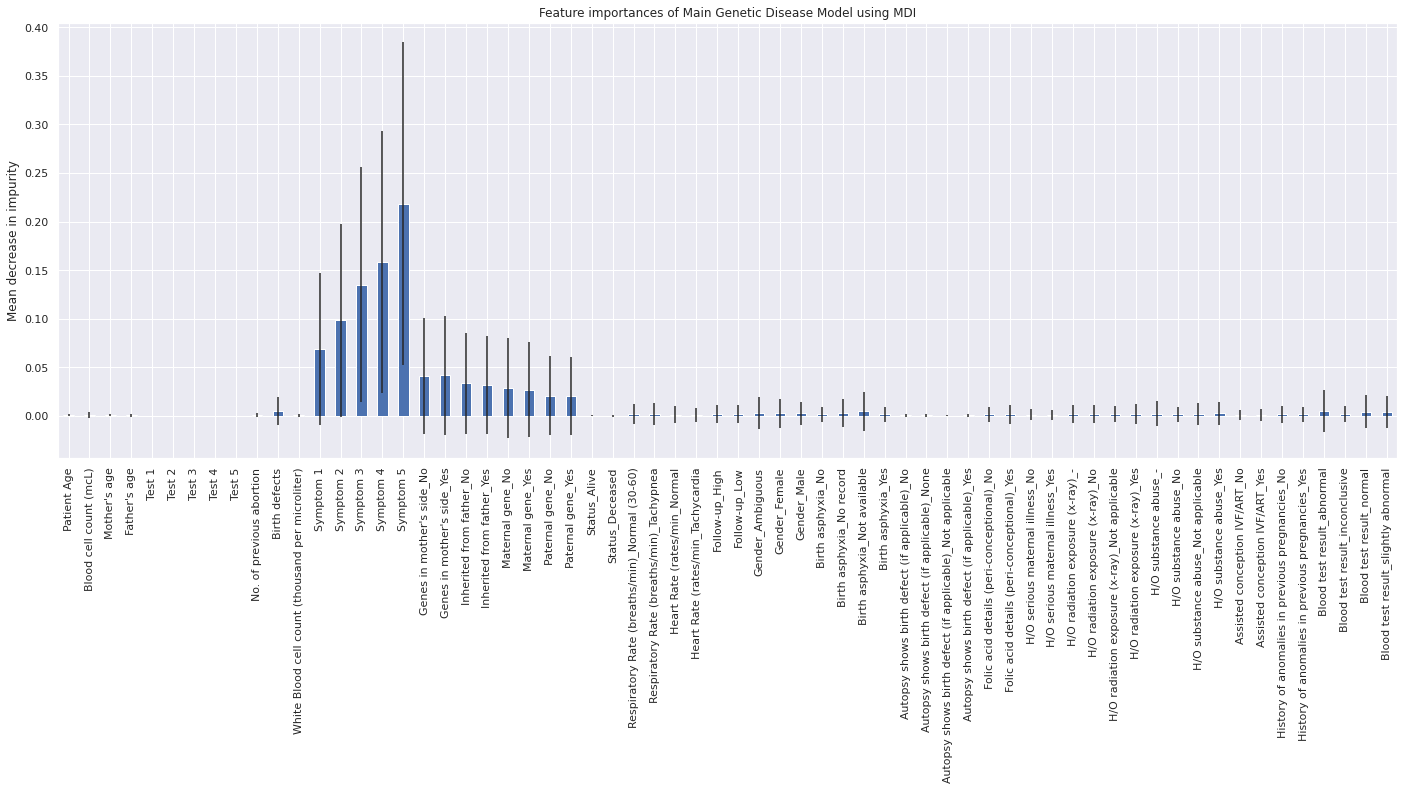

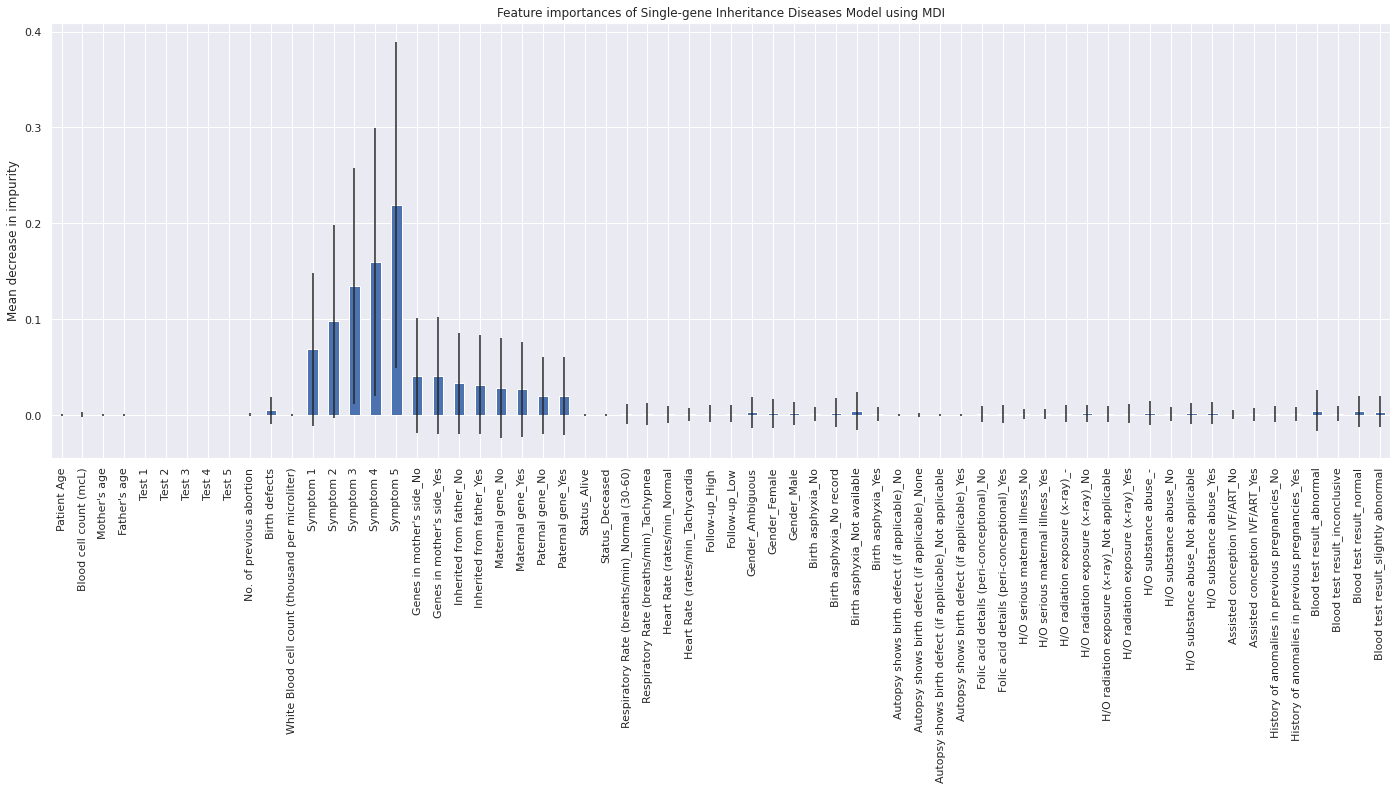

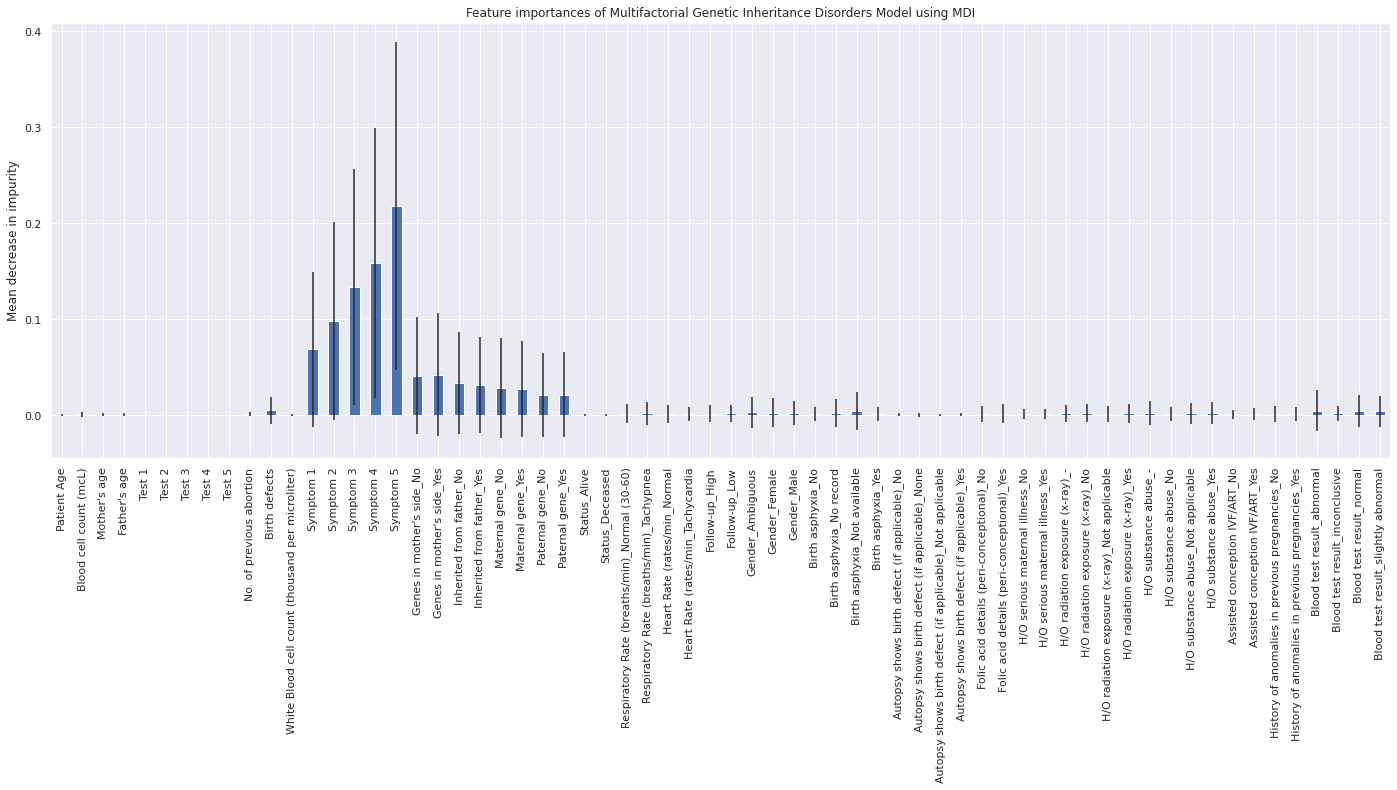

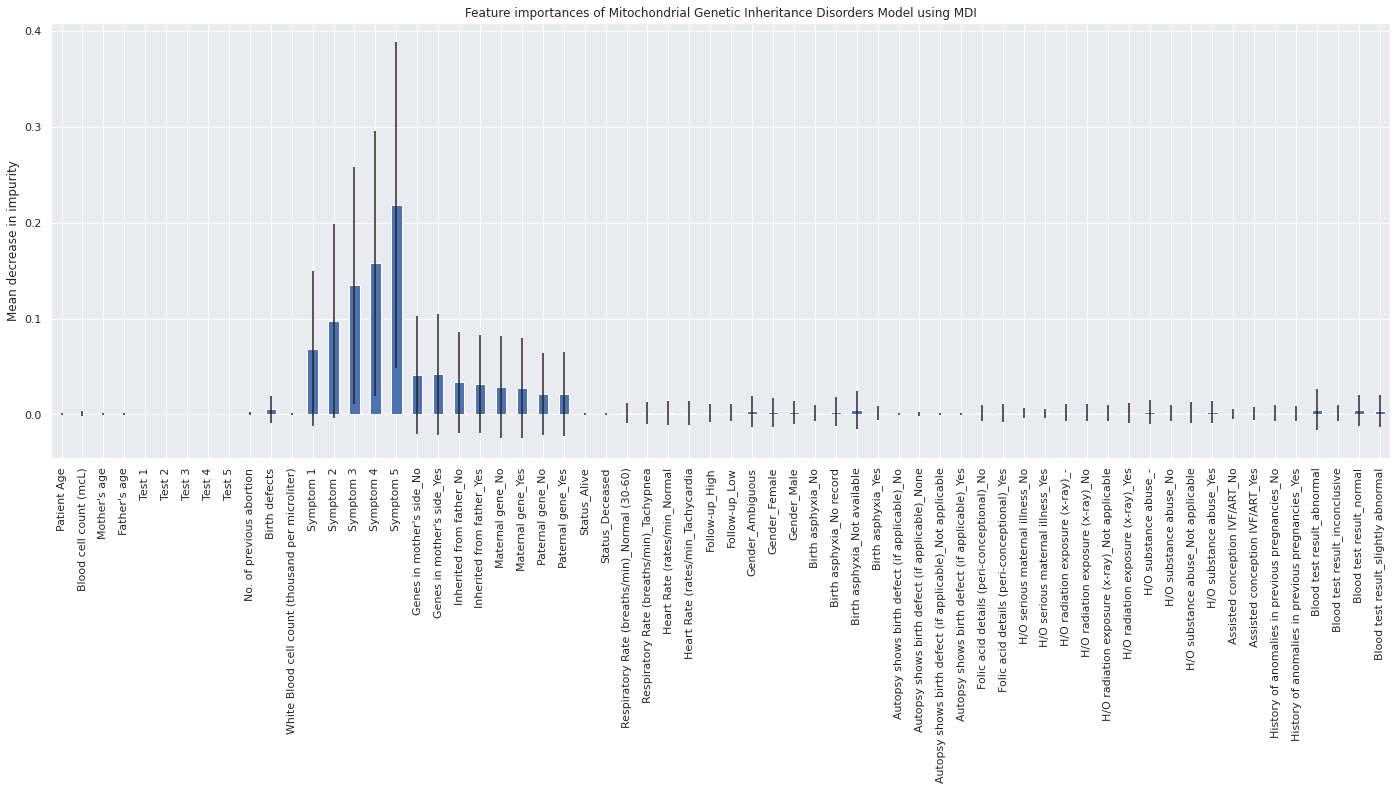

In [ ]:
# Completed
# Stratify with main and subclass
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

main_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

final_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}

impt_main = pd.DataFrame()
impt_MF = pd.DataFrame()
impt_SG = pd.DataFrame()
impt_MT = pd.DataFrame()

start_time = time.time()

# Iterate the model for 30 times to get average performance
for i in range(30):
  X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
  smote_sample = SMOTE()
  X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
  X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  X_train_GD, y_train_GD = smote_sample.fit_resample(X_train_GD_pre, y_train['Genetic Disorder'])
  X_test_GD, y_test_GD = smote_sample.fit_resample(X_test_GD_pre, y_test['Genetic Disorder'])

  randfor_GD = RandomForestClassifier(n_estimators = 200, max_depth = 5) # Instantiate model
  randfor_GD.fit(X_train_GD, y_train_GD) # Fit model
  main_scores['Accuracy(Train)'].append(randfor_GD.score(X_train_GD, y_train_GD)) # Train set accuracy
  main_scores['Accuracy(Test)'].append(randfor_GD.score(X_test_GD, y_test_GD)) # Test set accuracy
  impt_main = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_GD.estimators_])], axis = 0)
  main_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_GD, X_train_GD, y_train_GD, cv = 5).mean()) # Train set 5-fold cross-validation
  main_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_GD, X_test_GD, y_test_GD, cv = 5).mean()) # Test set 5-fold cross-validation

### Subclass
  smote_sample = SMOTE()
  X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
  X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
  y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
  y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
  X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
  X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

  y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
  y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
  X_train_SG = X_train_SC.loc[y_train_SG.index]
  X_test_SG = X_test_SC.loc[y_test_SG.index]
  randfor_SG = RandomForestClassifier(n_estimators = 300, max_depth = 3) # Instantiate model
  randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
  SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
  SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG)) # Test set accuracy
  impt_SG = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_SG.estimators_])], axis = 0)
  SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
  SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation


  y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
  y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
  X_train_MF = X_train_SC.loc[y_train_MF.index]
  X_test_MF = X_test_SC.loc[y_test_MF.index]
  randfor_MF = RandomForestClassifier(n_estimators = 300, max_depth = 4) # Instantiate model
  randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
  MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
  MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
  impt_MF = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MF.estimators_])], axis = 0)
  MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
  MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation


  y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
  y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
  X_train_MT = X_train_SC.loc[y_train_MT.index]
  X_test_MT = X_test_SC.loc[y_test_MT.index]
  randfor_MT = RandomForestClassifier(n_estimators = 200, max_depth = 7) # Instantiate model
  randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
  MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
  MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
  impt_MT = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MT.estimators_])], axis = 0)
  MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
  MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  
# Using prediced Genetic Disorder from Genetic Disorder model and input into Disorder Subclass models
  X_train_result = pd.concat([y_train_SC, y_train_main,pd.DataFrame(randfor_GD.predict(X_train_SC), columns = ['Predicted_main'])], axis = 1)

  X_train_result_MT = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index)], 
                                              axis = 1)
  X_train_result_SG = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'].index)],
                                              axis = 1)
  X_train_result_MF = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index)],
                                              axis = 1)
  X_train_result_final = pd.concat([X_train_result_MT,X_train_result_SG,X_train_result_MF],axis = 0)
  final_scores['Accuracy(Train)'].append(accuracy(X_train_result_final['Disorder Subclass'], X_train_result_final['Predicted_sub']))  # Train set accuracy

  X_test_result = pd.concat([y_test_SC, y_test_main, pd.DataFrame(randfor_GD.predict(X_test_SC), columns = ['Predicted_main'])], axis = 1)

  X_test_result_MT = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index)], 
                                              axis = 1)
  X_test_result_SG = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'].index)],
                                              axis = 1)
  X_test_result_MF = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index)],
                                              axis = 1)
  X_test_result_final = pd.concat([X_test_result_MT,X_test_result_SG,X_test_result_MF],axis = 0)
  final_scores['Accuracy(Test)'].append(accuracy(X_test_result_final['Disorder Subclass'], X_test_result_final['Predicted_sub'])) # Test set accuracy

print('Main Model')
display(pd.DataFrame(main_scores).describe())
impt_main.columns = [feature for feature in X_train_GD]
display(impt_main.describe())

print('SG Model')
display(pd.DataFrame(SG_scores).describe())
impt_SG.columns = [feature for feature in X_train_GD]
display(impt_SG.describe())

print('MT Model')
display(pd.DataFrame(MT_scores).describe())
impt_MT.columns = [feature for feature in X_train_GD]
display(impt_MT.describe())

print('MF Model')
display(pd.DataFrame(MF_scores).describe())
impt_MF.columns = [feature for feature in X_train_GD]
display(impt_MF.describe())

display(pd.DataFrame(final_scores).describe())

# Plot Variable Importance for the models
fig, ax = plt.subplots(figsize = (24,8))
impt_main.describe().loc['mean'].plot.bar(yerr=impt_main.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Main Genetic Disease Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_SG.describe().loc['mean'].plot.bar(yerr=impt_SG.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Single-gene Inheritance Diseases Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MF.describe().loc['mean'].plot.bar(yerr=impt_MF.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Multifactorial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MT.describe().loc['mean'].plot.bar(yerr=impt_MT.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Mitochondrial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time, "seconds")

Final Models Evaluation

Variable importance was found to be similar for Genetic Disorder model and Disorder Subclass models. Most of the variables turned out to be useless as predicted from the exploratory data analysis. Therefore, only useful predictors were kept to create models that are lower in complexity. The mean and standard deviation of accumulation of the impurity decrease for each variable within each tree of the Random Forest models was compared visually and plotted as illustrated above. Only the genetic inheritance factors and symptoms were found to be important predictors for the Genetic and Disorder Subclass. This is due to the important role of genes in the manifestation of diseases. Given that different diseases can have different symptoms, it is also essential in the identification of disease.


Main Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.626800        0.632659          0.622731         0.638362
std           0.003100        0.005704          0.002652         0.005639
min           0.619094        0.622287          0.617870         0.628654
25%           0.624674        0.629915          0.620900         0.634937
50%           0.627091        0.631751          0.622644         0.637302
75%           0.628937        0.636197          0.624235         0.642441
max           0.632477        0.644477          0.628070         0.650357

Symptom 1    Symptom 2    Symptom 3    Symptom 4    Symptom 5  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean      0.058907     0.103567     0.184396     0.194702     0.317713   
std       0.030645     0.051072     0.079582     0.079429     0.109079   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.035496     0.063032     0.121744     0.132462     0.234835   
50%       0.056957     0.098468     0.183326     0.196248     0.341435   
75%       0.081478     0.143946     0.249242     0.258998     0.407038   
max       0.183787     0.303184     0.423040     0.448767     0.617334   

       Genes in mother's side_No  Genes in mother's side_Yes  \
count                6000.000000                 6000.000000   
mean                    0.026990                    0.027396   
std                     0.025583                    0.025047   
min                     0.000000                    0.000000   
25%                     0.005985                    0.006726   
50%                     0.020613                    0.021385   
75%                     0.040935                    0.041693   
max                     0.129384                    0.130876   

       Inherited from father_No  Inherited from father_Yes  Maternal gene_No  \
count               6000.000000                6000.000000       6000.000000   
mean                   0.022417                   0.021836          0.011625   
std                    0.021512                   0.021600          0.012256   
min                    0.000000                   0.000000          0.000000   
25%                    0.005802                   0.005572          0.001938   
50%                    0.016615                   0.015713          0.008382   
75%                    0.032323                   0.030888          0.017416   
max                    0.120888                   0.117455          0.094936   

       Maternal gene_Yes  Paternal gene_No  Paternal gene_Yes  
count        6000.000000       6000.000000        6000.000000  
mean            0.011547          0.009489           0.009413  
std             0.012415          0.010365           0.010451  
min             0.000000          0.000000           0.000000  
25%             0.001984          0.001083           0.000927  
50%             0.008213          0.006198           0.006063  
75%             0.016968          0.014883           0.014318  
max             0.099319          0.070869           0.073122

SG Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.703962        0.705200          0.702566         0.721245
std           0.006787        0.012787          0.004404         0.010598
min           0.686047        0.686047          0.693960         0.693812
25%           0.700238        0.694525          0.699957         0.714485
50%           0.703852        0.707364          0.703691         0.722074
75%           0.709242        0.713017          0.705245         0.726434
max           0.716651        0.731589          0.710677         0.744204

Symptom 1    Symptom 2    Symptom 3    Symptom 4    Symptom 5  \
count  6300.000000  6300.000000  6300.000000  6300.000000  6300.000000   
mean      0.058249     0.103898     0.182660     0.197079     0.319098   
std       0.032651     0.056090     0.083721     0.089285     0.118286   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.034216     0.061656     0.119309     0.131621     0.232531   
50%       0.056175     0.097989     0.180377     0.196431     0.341383   
75%       0.081230     0.144552     0.249026     0.260641     0.408812   
max       0.271744     0.485837     0.621699     0.754949     0.806549   

       Genes in mother's side_No  Genes in mother's side_Yes  \
count                6300.000000                 6300.000000   
mean                    0.026643                    0.026887   
std                     0.026141                    0.025695   
min                     0.000000                    0.000000   
25%                     0.004968                    0.005518   
50%                     0.020024                    0.020604   
75%                     0.040640                    0.040952   
max                     0.221202                    0.244367   

       Inherited from father_No  Inherited from father_Yes  Maternal gene_No  \
count               6300.000000                6300.000000       6300.000000   
mean                   0.022014                   0.021410          0.011892   
std                    0.021992                   0.022004          0.014465   
min                    0.000000                   0.000000          0.000000   
25%                    0.004852                   0.004649          0.001309   
50%                    0.015928                   0.015140          0.008120   
75%                    0.032152                   0.030735          0.017394   
max                    0.172704                   0.215332          0.190492   

       Maternal gene_Yes  Paternal gene_No  Paternal gene_Yes  
count        6300.000000       6300.000000        6300.000000  
mean            0.011902          0.009222           0.009045  
std             0.015358          0.010471           0.010420  
min             0.000000          0.000000           0.000000  
25%             0.001322          0.000374           0.000095  
50%             0.007890          0.005752           0.005573  
75%             0.016909          0.014511           0.013867  
max             0.329262          0.092500           0.073122

MT Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.746482        0.728004          0.726774         0.724062
std           0.002758        0.008889          0.003740         0.008982
min           0.741602        0.708010          0.721012         0.702214
25%           0.744590        0.722545          0.724100         0.719887
50%           0.746447        0.728359          0.726704         0.724338
75%           0.747981        0.735788          0.729490         0.729736
max           0.753553        0.742248          0.733447         0.739036

Symptom 1    Symptom 2    Symptom 3    Symptom 4    Symptom 5  \
count  6200.000000  6200.000000  6200.000000  6200.000000  6200.000000   
mean      0.059292     0.104132     0.183067     0.194816     0.317070   
std       0.030719     0.051011     0.079211     0.079006     0.108416   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.035815     0.063619     0.120575     0.132692     0.234857   
50%       0.057303     0.098935     0.181495     0.196423     0.341069   
75%       0.081879     0.144547     0.247303     0.258649     0.405315   
max       0.183787     0.303184     0.423040     0.448767     0.617334   

       Genes in mother's side_No  Genes in mother's side_Yes  \
count                6200.000000                 6200.000000   
mean                    0.026941                    0.027310   
std                     0.025352                    0.024826   
min                     0.000000                    0.000000   
25%                     0.006169                    0.006854   
50%                     0.020670                    0.021499   
75%                     0.040679                    0.041288   
max                     0.129384                    0.130876   

       Inherited from father_No  Inherited from father_Yes  Maternal gene_No  \
count               6200.000000                6200.000000       6200.000000   
mean                   0.022323                   0.021733          0.011906   
std                    0.021238                   0.021342          0.012442   
min                    0.000000                   0.000000          0.000000   
25%                    0.006068                   0.005743          0.002077   
50%                    0.016683                   0.015766          0.008573   
75%                    0.031902                   0.030599          0.017811   
max                    0.120888                   0.117455          0.094936   

       Maternal gene_Yes  Paternal gene_No  Paternal gene_Yes  
count        6200.000000       6200.000000        6200.000000  
mean            0.011819          0.009852           0.009738  
std             0.012621          0.010736           0.010729  
min             0.000000          0.000000           0.000000  
25%             0.002148          0.001263           0.001075  
50%             0.008423          0.006478           0.006325  
75%             0.017327          0.015423           0.014735  
max             0.099319          0.070869           0.073122

MF Model


Accuracy(Train)  Accuracy(Test)  5-Fold-CV(Train)  5-Fold-CV(Test)
count        30.000000       30.000000         30.000000        30.000000
mean          0.903965        0.877412          0.900999         0.924874
std           0.006976        0.023072          0.006743         0.011863
min           0.890019        0.815891          0.884609         0.900192
25%           0.901001        0.868217          0.895531         0.916997
50%           0.904191        0.880814          0.902254         0.924750
75%           0.907421        0.891796          0.904292         0.932817
max           0.919493        0.908269          0.916505         0.944767

Symptom 1    Symptom 2    Symptom 3    Symptom 4    Symptom 5  \
count  6300.000000  6300.000000  6300.000000  6300.000000  6300.000000   
mean      0.059717     0.104681     0.183373     0.195738     0.315002   
std       0.037368     0.059493     0.087307     0.088778     0.117863   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.034514     0.062061     0.117762     0.130111     0.227927   
50%       0.056521     0.097536     0.179894     0.194555     0.337664   
75%       0.081639     0.143953     0.248705     0.259442     0.407236   
max       0.390661     0.535599     0.596557     0.634964     0.675483   

       Genes in mother's side_No  Genes in mother's side_Yes  \
count                6300.000000                 6300.000000   
mean                    0.027016                    0.027313   
std                     0.027203                    0.025964   
min                     0.000000                    0.000000   
25%                     0.005365                    0.006177   
50%                     0.020297                    0.021174   
75%                     0.040708                    0.041428   
max                     0.263687                    0.228983   

       Inherited from father_No  Inherited from father_Yes  Maternal gene_No  \
count               6300.000000                6300.000000       6300.000000   
mean                   0.022771                   0.022216          0.011648   
std                    0.024663                   0.024610          0.013934   
min                    0.000000                   0.000000          0.000000   
25%                    0.005287                   0.005079          0.001450   
50%                    0.016294                   0.015435          0.008130   
75%                    0.032111                   0.030826          0.017126   
max                    0.266165                   0.250876          0.237674   

       Maternal gene_Yes  Paternal gene_No  Paternal gene_Yes  
count        6300.000000       6300.000000        6300.000000  
mean            0.011494          0.009464           0.009567  
std             0.013813          0.010646           0.011091  
min             0.000000          0.000000           0.000000  
25%             0.001375          0.000753           0.000754  
50%             0.007878          0.005987           0.005974  
75%             0.016792          0.014874           0.014479  
max             0.248493          0.099725           0.097529

Accuracy(Train)  Accuracy(Test)
count        30.000000       30.000000
mean          0.248827        0.242668
std           0.000919        0.002963
min           0.247201        0.236003
25%           0.248197        0.240848
50%           0.248816        0.242786
75%           0.249327        0.245263
max           0.251184        0.247416

Elapsed time:  1268.2370827198029 seconds


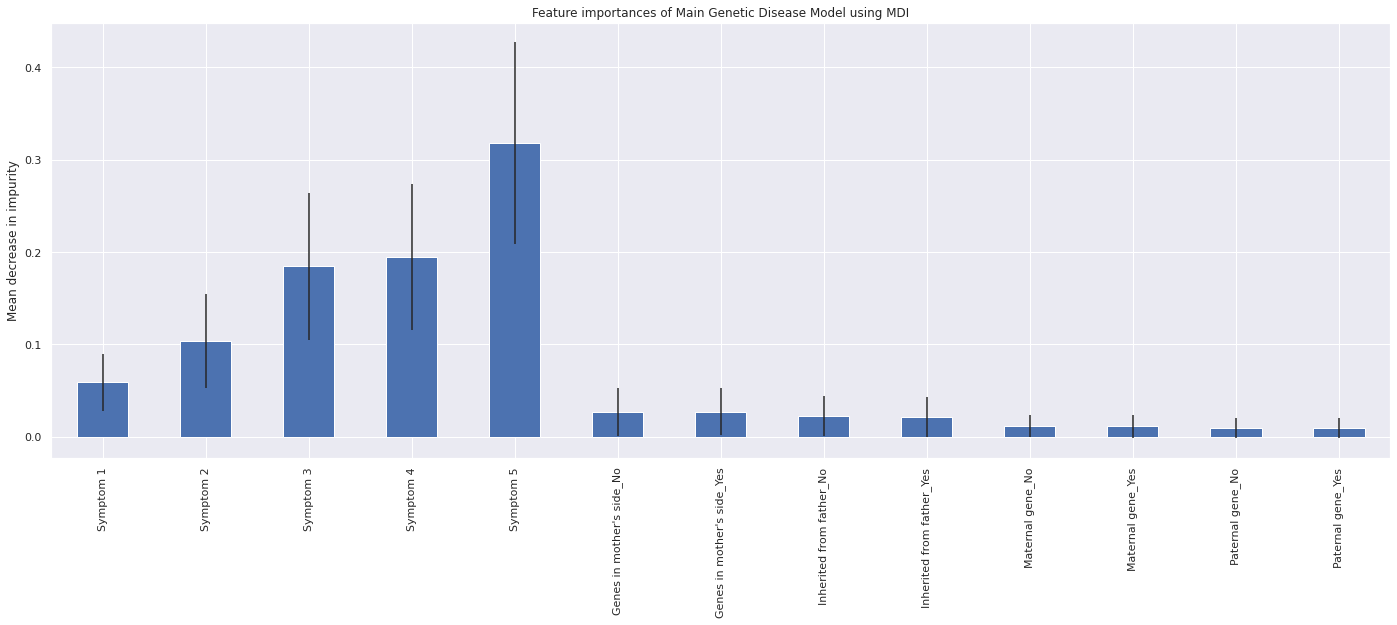

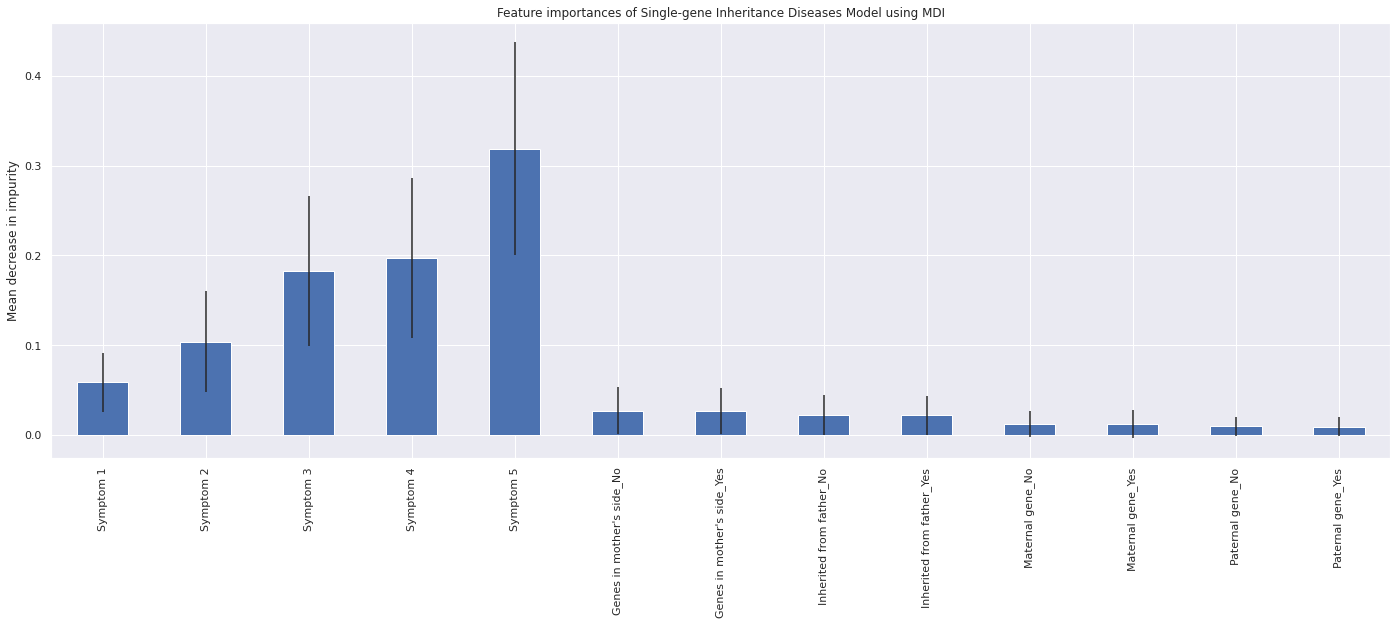

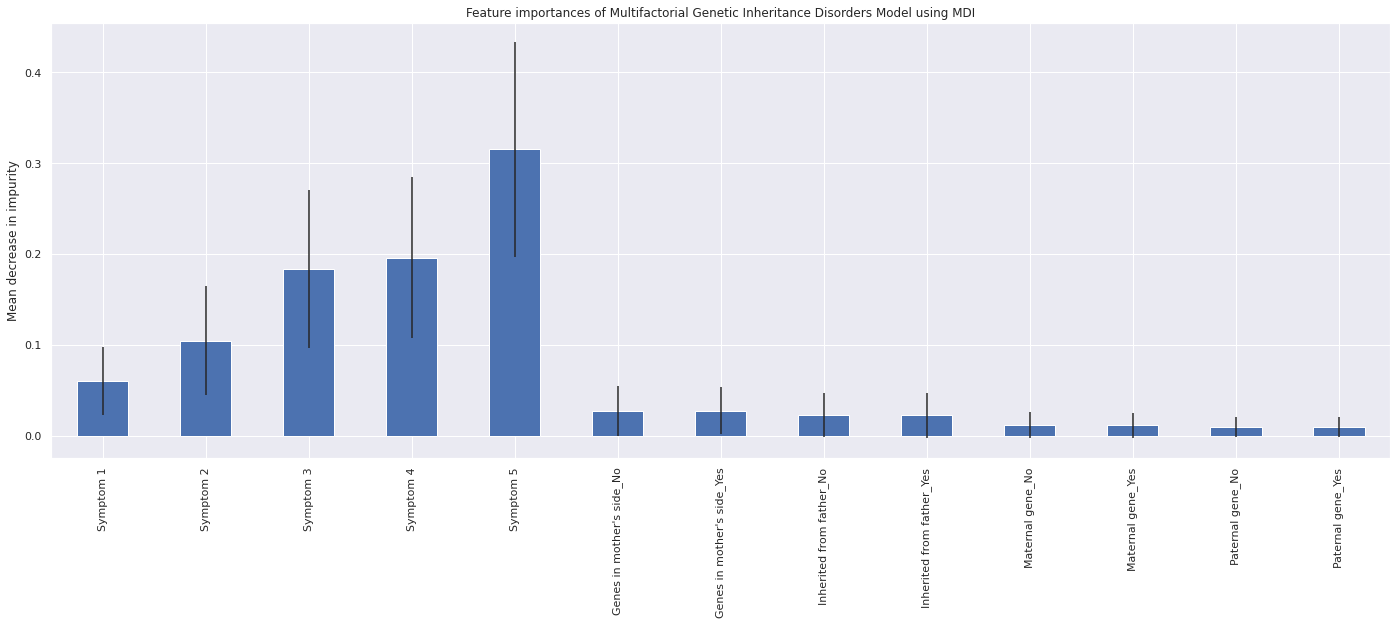

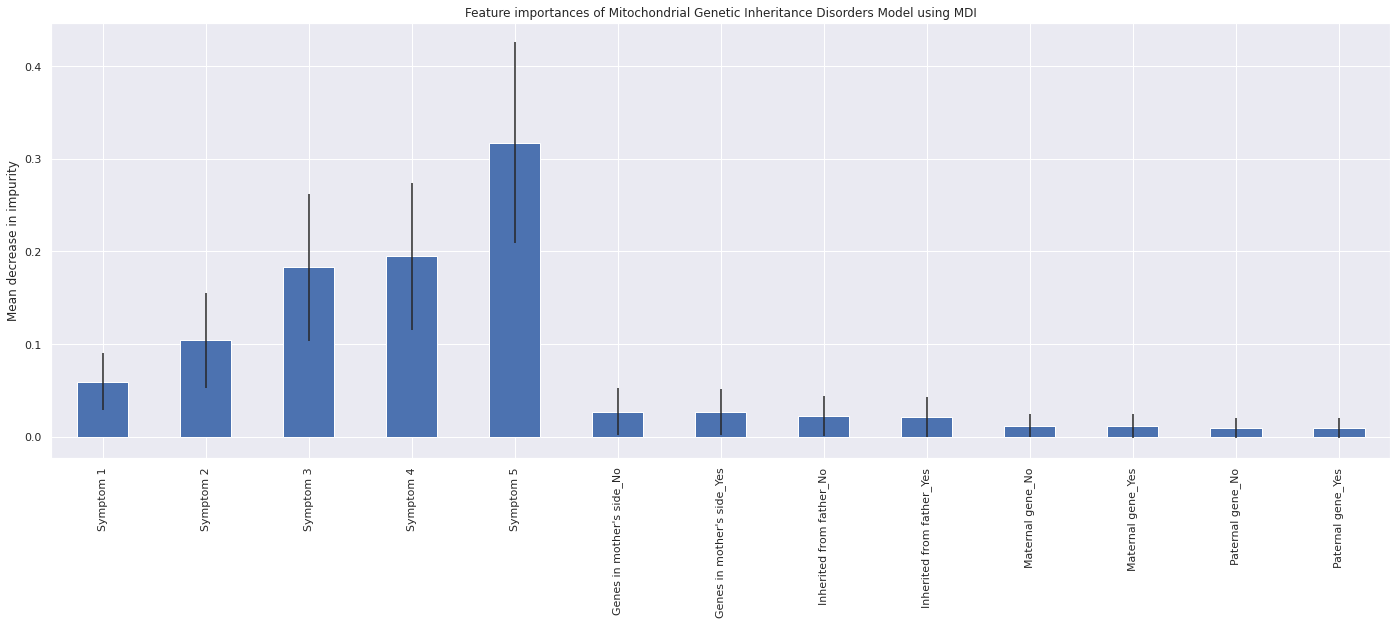

In [ ]:
# Completed
# Stratify with main and subclass
# only symptom and gene variables 
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5',
          "Genes in mother's side_No", "Genes in mother's side_Yes",
          'Inherited from father_No', 'Inherited from father_Yes',
          'Maternal gene_No', 'Maternal gene_Yes',
          'Paternal gene_No', 'Paternal gene_Yes']].copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_drop_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

main_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

final_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}

impt_main = pd.DataFrame()
impt_MF = pd.DataFrame()
impt_SG = pd.DataFrame()
impt_MT = pd.DataFrame()

start_time = time.time()

# Genetic Disorder Model Training
# Iterate the model for 30 times to get average performance
for i in range(30):
  X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
  smote_sample = SMOTE()
  X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
  X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  X_train_GD, y_train_GD = smote_sample.fit_resample(X_train_GD_pre, y_train['Genetic Disorder'])
  X_test_GD, y_test_GD = smote_sample.fit_resample(X_test_GD_pre, y_test['Genetic Disorder'])

  randfor_GD = RandomForestClassifier(n_estimators = 200, max_depth = 5) # Instantiate model
  randfor_GD.fit(X_train_GD, y_train_GD) # Fit model
  main_scores['Accuracy(Train)'].append(randfor_GD.score(X_train_GD, y_train_GD)) # Train set accuracy
  main_scores['Accuracy(Test)'].append(randfor_GD.score(X_test_GD, y_test_GD)) # Test set accuracy
  impt_main = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_GD.estimators_])], axis = 0)
  main_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_GD, X_train_GD, y_train_GD, cv = 5).mean()) # Train set 5-fold cross-validation
  main_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_GD, X_test_GD, y_test_GD, cv = 5).mean()) # Test set 5-fold cross-validation

# Disorder Subclass Models Training
  smote_sample = SMOTE()
  X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
  X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
  y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
  y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
  X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
  X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

  # Single-gene inheritance diseases Model
  y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
  y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene inheritance diseases'].index]
  X_train_SG = X_train_SC.loc[y_train_SG.index]
  X_test_SG = X_test_SC.loc[y_test_SG.index]
  randfor_SG = RandomForestClassifier(n_estimators = 300, max_depth = 3) # Instantiate model
  randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
  SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
  SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG)) # Test set accuracy
  impt_SG = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_SG.estimators_])], axis = 0)
  SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
  SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation

  # Multifactorial genetic inheritance disorders Model
  y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
  y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial genetic inheritance disorders'].index]
  X_train_MF = X_train_SC.loc[y_train_MF.index]
  X_test_MF = X_test_SC.loc[y_test_MF.index]
  randfor_MF = RandomForestClassifier(n_estimators = 300, max_depth = 4) # Instantiate model
  randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
  MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
  MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
  impt_MF = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MF.estimators_])], axis = 0)
  MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
  MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation

  # Mitochondrial genetic inheritance disorders Model
  y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
  y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial genetic inheritance disorders'].index]
  X_train_MT = X_train_SC.loc[y_train_MT.index]
  X_test_MT = X_test_SC.loc[y_test_MT.index]
  randfor_MT = RandomForestClassifier(n_estimators = 200, max_depth = 7) # Instantiate model
  randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
  MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
  MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
  impt_MT = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MT.estimators_])], axis = 0)
  MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
  MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  
# Using prediced Genetic Disorder from Genetic Disorder model and input into Disorder Subclass models
  X_train_result = pd.concat([y_train_SC, y_train_main,pd.DataFrame(randfor_GD.predict(X_train_SC), columns = ['Predicted_main'])], axis = 1)

  X_train_result_MT = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index)], 
                                              axis = 1)
  X_train_result_SG = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Single-gene inheritance diseases'].index)],
                                              axis = 1)
  X_train_result_MF = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index)],
                                              axis = 1)
  X_train_result_final = pd.concat([X_train_result_MT,X_train_result_SG,X_train_result_MF],axis = 0)
  final_scores['Accuracy(Train)'].append(accuracy(X_train_result_final['Disorder Subclass'], X_train_result_final['Predicted_sub'])) # Train set accuracy

  X_test_result = pd.concat([y_test_SC, y_test_main, pd.DataFrame(randfor_GD.predict(X_test_SC), columns = ['Predicted_main'])], axis = 1)

  X_test_result_MT = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial genetic inheritance disorders'].index)], 
                                              axis = 1)
  X_test_result_SG = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Single-gene inheritance diseases'].index)],
                                              axis = 1)
  X_test_result_MF = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Multifactorial genetic inheritance disorders'].index)],
                                              axis = 1)
  X_test_result_final = pd.concat([X_test_result_MT,X_test_result_SG,X_test_result_MF],axis = 0)
  final_scores['Accuracy(Test)'].append(accuracy(X_test_result_final['Disorder Subclass'], X_test_result_final['Predicted_sub'])) # Test set accuracy

print('Main Model')
display(pd.DataFrame(main_scores).describe())
impt_main.columns = [feature for feature in X_train_GD]
display(impt_main.describe())

print('SG Model')
display(pd.DataFrame(SG_scores).describe())
impt_SG.columns = [feature for feature in X_train_GD]
display(impt_SG.describe())

print('MT Model')
display(pd.DataFrame(MT_scores).describe())
impt_MT.columns = [feature for feature in X_train_GD]
display(impt_MT.describe())

print('MF Model')
display(pd.DataFrame(MF_scores).describe())
impt_MF.columns = [feature for feature in X_train_GD]
display(impt_MF.describe())

display(pd.DataFrame(final_scores).describe())

# Plot Variable Importance for the models
fig, ax = plt.subplots(figsize = (24,8))
impt_main.describe().loc['mean'].plot.bar(yerr=impt_main.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Main Genetic Disease Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_SG.describe().loc['mean'].plot.bar(yerr=impt_SG.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Single-gene Inheritance Diseases Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MF.describe().loc['mean'].plot.bar(yerr=impt_MF.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Multifactorial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MT.describe().loc['mean'].plot.bar(yerr=impt_MT.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Mitochondrial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time, "seconds")

Text(0, 0.5, 'Accuracy')

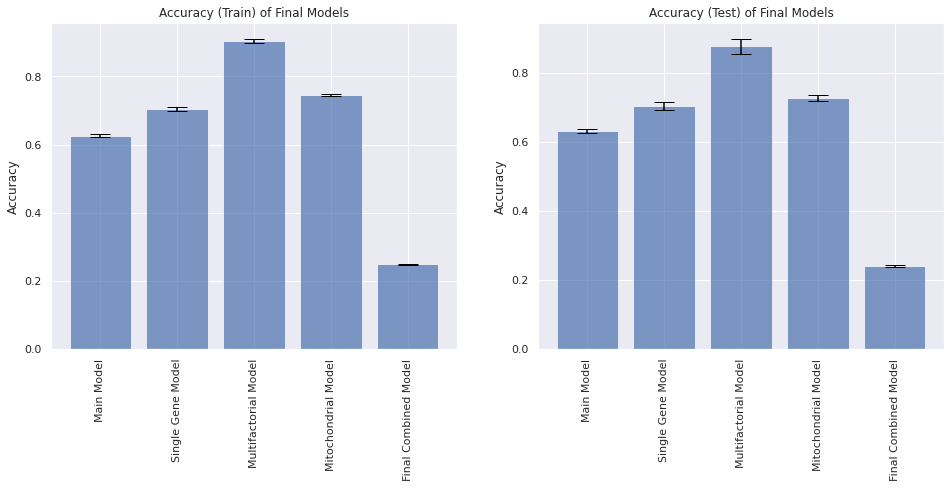

In [ ]:
# Evaluate accuracy of final models
f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].bar(['Main Model', 'Single Gene Model', 'Multifactorial Model', 'Mitochondrial Model', 'Final Combined Model'], [np.mean(main_scores['Accuracy(Train)']),np.mean(SG_scores['Accuracy(Train)']),np.mean(MF_scores['Accuracy(Train)']),np.mean(MT_scores['Accuracy(Train)']),np.mean(final_scores['Accuracy(Train)'])],yerr=[np.std(main_scores['Accuracy(Train)']),np.std(SG_scores['Accuracy(Train)']),np.std(MF_scores['Accuracy(Train)']),np.std(MT_scores['Accuracy(Train)']),np.std(final_scores['Accuracy(Train)'])],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Accuracy (Train) of Final Models')
ax[0].set_ylabel('Accuracy')

ax[1].bar(['Main Model', 'Single Gene Model', 'Multifactorial Model', 'Mitochondrial Model', 'Final Combined Model'], [np.mean(main_scores['Accuracy(Test)']),np.mean(SG_scores['Accuracy(Test)']),np.mean(MF_scores['Accuracy(Test)']),np.mean(MT_scores['Accuracy(Test)']),np.mean(final_scores['Accuracy(Test)'])],yerr=[np.std(main_scores['Accuracy(Test)']),np.std(SG_scores['Accuracy(Test)']),np.std(MF_scores['Accuracy(Test)']),np.std(MT_scores['Accuracy(Test)']),np.std(final_scores['Accuracy(Test)'])],align='center', alpha=0.7, ecolor='black', capsize=10)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Accuracy (Test) of Final Models')
ax[1].set_ylabel('Accuracy')